In [1]:
import pickle
import numpy as np
import os
import nibabel as nib
import sys
import matplotlib.pyplot as plt
import glob
#import h5py
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
pre_GED = sorted(glob.glob("GED/sub-UNI*ses-pre_GED.pkl"))
pre_GED

baseline_pre_GED = {} #get only baseline scans, not post-treatment (earlier dates)
for file in pre_GED:
    basename = os.path.basename(file)
    pattern = basename[0:10] #extract only sub-UNIxxx
    
    # Only add the file if its starting pattern hasn't been encountered yet - will add the first items in sorted list
    if pattern not in baseline_pre_GED:
        baseline_pre_GED[pattern] = file

# drop UNI00x and UNI999
for key in list(baseline_pre_GED.keys()):
    if key.startswith('sub-UNI00') or key.startswith('sub-UNI9'):
        del baseline_pre_GED[key]
        
post_GED = sorted(glob.glob("GED/sub-UNI*ses-post_GED.pkl"))
#post_GED

baseline_post_GED = {} #get only baseline scans, not post-treatment (earlier dates)
for file in post_GED:
    basename = os.path.basename(file)
    pattern = basename[0:10] #extract only sub-UNIxxx
    
    # Only add the file if its starting pattern hasn't been encountered yet - will add the first items in sorted list
    if pattern not in baseline_post_GED:
        baseline_post_GED[pattern] = file

# drop UNI00x and UNI999
for key in list(baseline_post_GED.keys()):
    if key.startswith('sub-UNI00') or key.startswith('sub-UNI9'):
        del baseline_post_GED[key]
        
#baseline_pre_GED, baseline_post_GED

all_baseline_pre_GED = baseline_pre_GED.copy()

set(baseline_pre_GED.keys()) == set(baseline_post_GED.keys()) #False
set(baseline_pre_GED.keys()) ^ set(baseline_post_GED.keys()) #keys not in common: {'sub-UNI105' (pre_GED)}


del baseline_pre_GED['sub-UNI105']  #comment these lines to keep originals

set(baseline_pre_GED.keys()) == set(baseline_post_GED.keys()) #True

#check if they are the same sessions
common_keys = set(baseline_pre_GED) & set(baseline_post_GED)
mismatches = []
for key in common_keys:
    # Split the values at '_' and take the first part
    part1 = baseline_pre_GED[key].split('_')[0]
    part2 = baseline_post_GED[key].split('_')[0]
    if part1 != part2:
        print(f"Mismatch for key '{key}': '{part1}' != '{part2}'")
        mismatches.append(key)
    #Mismatch for key 'sub-UNI090': 'GED/sub-UNI09020240709' != 'GED/sub-UNI09020240722'
    #Mismatch for key 'sub-UNI091': 'GED/sub-UNI09120240708' != 'GED/sub-UNI09120240724'

#unequal sessions, delete from both lists
for key in mismatches:
    del baseline_pre_GED[key]
    del baseline_post_GED[key]

print(set(baseline_pre_GED.keys()) == set(baseline_post_GED.keys())) #True

#2nd pass, should be no mismatch
common_keys = set(baseline_pre_GED) & set(baseline_post_GED)
mismatches = []
for key in common_keys:
    # Split the values at '_' and take the first part
    part1 = baseline_pre_GED[key].split('_')[0]
    part2 = baseline_post_GED[key].split('_')[0]
    if part1 != part2:
        print(f"Mismatch for key '{key}': '{part1}' != '{part2}'")
        mismatches.append(key)

Mismatch for key 'sub-UNI091': 'GED/sub-UNI09120240708' != 'GED/sub-UNI09120240724'
Mismatch for key 'sub-UNI090': 'GED/sub-UNI09020240709' != 'GED/sub-UNI09020240722'
True


In [4]:
all_pre_GED_data_dict = {}

for key in all_baseline_pre_GED.keys():
    file = all_baseline_pre_GED[key]
    with open(file,'rb') as f:
        data = pickle.load(f)
    f.close()
    newkey = key.split('-')[1] #scratch the sub-
    all_pre_GED_data_dict[newkey] = data

In [5]:
pre_GED_data_dict = {}

for key in baseline_pre_GED.keys():
    file = baseline_pre_GED[key]
    with open(file,'rb') as f:
        data = pickle.load(f)
    f.close()
    newkey = key.split('-')[1] #scratch the sub-
    pre_GED_data_dict[newkey] = data

In [6]:
post_GED_data_dict = {}

for key in baseline_post_GED.keys():
    file = baseline_post_GED[key]
    with open(file,'rb') as f:
        data = pickle.load(f)
    f.close()
    newkey = key.split('-')[1] #scratch the sub-
    post_GED_data_dict[newkey] = data

In [7]:
pre_GED_data_dict['UNI012'].shape

(200, 730)

In [8]:
def power(array): #harmonics x timepoints
    result = np.array([np.sum(np.abs(array[i,:])) for i in range(array.shape[0])])
    return result

#def energy(array):
#    result = np.array([np.sum((eigvals[i]**2)*(array[i,:]**2)) for i in range(array.shape[0])])
#    return result

In [9]:
all_pre_GED_power_dict = {key:power(all_pre_GED_data_dict[key]) for key in all_pre_GED_data_dict.keys()}
pre_GED_power_dict = {key:power(pre_GED_data_dict[key]) for key in pre_GED_data_dict.keys()}
post_GED_power_dict = {key:power(post_GED_data_dict[key]) for key in post_GED_data_dict.keys()}

#pre_GED_energy_dict = {key:energy(pre_GED_data_dict[key]) for key in pre_GED_data_dict.keys()}
#post_GED_energy_dict = {key:energy(post_GED_data_dict[key]) for key in post_GED_data_dict.keys()}

In [95]:
clindata = pd.read_csv('clindata.csv')

def convert_record_id(id):
    return 'UNI%.3d'%(id)

clindata['Participant ID'] = clindata['record_id'].apply(convert_record_id).replace({'UNI170':'UNI178'}) #UNI178 in BIDS is UNI170 in clinical dataset
#clindata = clindata[clindata['redcap_event_name'] == 'baseline_arm_1']
# clindata['elig_type_bl'] 0 - HC, 1 - MDD, random_group = ketamine, midazolam,  
clindata = clindata[['Participant ID','visit','redcap_event_name','noload_age','regist_sex','demo_race','demo_hisp','random_group','elig_type_bl', 'baseline_cast', 'baseline_cast_ext', 'cast_total','cast_ext_total']]
clindata.head()

/tmp/ipykernel_44625/3296739050.py:1: DtypeWarning: Columns (158,163,171,193,373,374,376,415,423,470,474,476,478,491,498,510,512,515,526,528,529,748,869,956,959,979,981,984,993,999,1002,1005,1008,1017,1019,1107,1110,1112,1272,1278,1281) have mixed types. Specify dtype option on import or set low_memory=False.
  clindata = pd.read_csv('clindata.csv')


In [97]:
baseline_clindata = clindata[clindata['redcap_event_name'] == 'baseline_arm_1']
baseline_summary = baseline_clindata[baseline_clindata['Participant ID'].isin(all_pre_GED_data_dict.keys())] #exclude the 001,...009,999

In [98]:
baseline_summary.describe(include='all')
#df[df['Cohort?'] == 'HC'].describe(include='all'), df[df['Cohort?'] == 'MDD'].describe(include='all') #very disjoint rn, HC age mean is 29.2+/-11.25, MDD age mean 40.23+/-14.10, sex HC 40.0%F, MDD 70.18%F
# age 40.34 +/- 13.8
# 59 females, 35 males, CAST 7.24 +/- 3.22

,Participant ID,visit,redcap_event_name,noload_age,regist_sex,demo_race,demo_hisp,random_group,elig_type_bl,baseline_cast,baseline_cast_ext,cast_total,cast_ext_total
count,94,94.0,94,94.000000,94,94,94,61.000000,94.000000,94.000000,94.000000,94.000000,94.000000
unique,94,NaN,1,NaN,2,6,3,NaN,NaN,NaN,NaN,NaN,NaN
top,UNI012,NaN,baseline_arm_1,NaN,Female,White,Not hispanic/latino,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,94,NaN,59,59,86,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.0,NaN,40.340426,NaN,NaN,NaN,0.491803,0.648936,13.127660,24.723404,13.127660,24.723404
std,NaN,0.0,NaN,13.803189,NaN,NaN,NaN,0.504082,0.479862,5.824003,11.012607,5.824003,11.012607
min,NaN,0.0,NaN,18.000000,NaN,NaN,NaN,0.000000,0.000000,5.000000,10.000000,5.000000,10.000000
25%,NaN,0.0,NaN,27.000000,NaN,NaN,NaN,0.000000,0.000000,7.000000,13.000000,7.000000,13.000000
50%,NaN,0.0,NaN,38.500000,NaN,NaN,NaN,0.000000,1.000000,13.500000,25.000000,13.500000,25.000000
75%,NaN,0.0,NaN,53.000000,NaN,NaN,NaN,1.000000,1.000000,18.000000,33.750000,18.000000,33.750000


In [99]:
baseline_summary[baseline_summary['elig_type_bl'] == 0].describe(include='all')
# HC 33, age 39.8 +/- 14.0, female 16, male 17, CAST 7.24 +/- 3.22

,Participant ID,visit,redcap_event_name,noload_age,regist_sex,demo_race,demo_hisp,random_group,elig_type_bl,baseline_cast,baseline_cast_ext,cast_total,cast_ext_total
count,33,33.0,33,33.000000,33,33,33,0.0,33.0,33.000000,33.000000,33.000000,33.000000
unique,33,NaN,1,NaN,2,4,2,NaN,NaN,NaN,NaN,NaN,NaN
top,UNI016,NaN,baseline_arm_1,NaN,Male,White,Not hispanic/latino,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,33,NaN,17,17,31,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.0,NaN,39.848485,NaN,NaN,NaN,NaN,0.0,7.242424,14.060606,7.242424,14.060606
std,NaN,0.0,NaN,14.013657,NaN,NaN,NaN,NaN,0.0,3.221319,5.999684,3.221319,5.999684
min,NaN,0.0,NaN,22.000000,NaN,NaN,NaN,NaN,0.0,5.000000,10.000000,5.000000,10.000000
25%,NaN,0.0,NaN,25.000000,NaN,NaN,NaN,NaN,0.0,5.000000,10.000000,5.000000,10.000000
50%,NaN,0.0,NaN,39.000000,NaN,NaN,NaN,NaN,0.0,6.000000,12.000000,6.000000,12.000000
75%,NaN,0.0,NaN,52.000000,NaN,NaN,NaN,NaN,0.0,7.000000,16.000000,7.000000,16.000000


In [100]:
baseline_summary[baseline_summary['elig_type_bl'] == 1].describe(include='all')
# MDD 61, age 40.6 +/- 13.8, female 43, male 18, CAST 16.3 +/- 4.2

,Participant ID,visit,redcap_event_name,noload_age,regist_sex,demo_race,demo_hisp,random_group,elig_type_bl,baseline_cast,baseline_cast_ext,cast_total,cast_ext_total
count,61,61.0,61,61.000000,61,61,61,61.000000,61.0,61.000000,61.000000,61.000000,61.000000
unique,61,NaN,1,NaN,2,5,3,NaN,NaN,NaN,NaN,NaN,NaN
top,UNI012,NaN,baseline_arm_1,NaN,Female,White,Not hispanic/latino,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,61,NaN,43,42,55,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.0,NaN,40.606557,NaN,NaN,NaN,0.491803,1.0,16.311475,30.491803,16.311475,30.491803
std,NaN,0.0,NaN,13.797679,NaN,NaN,NaN,0.504082,0.0,4.205318,8.510039,4.205318,8.510039
min,NaN,0.0,NaN,18.000000,NaN,NaN,NaN,0.000000,1.0,5.000000,10.000000,5.000000,10.000000
25%,NaN,0.0,NaN,28.000000,NaN,NaN,NaN,0.000000,1.0,13.000000,24.000000,13.000000,24.000000
50%,NaN,0.0,NaN,38.000000,NaN,NaN,NaN,0.000000,1.0,17.000000,32.000000,17.000000,32.000000
75%,NaN,0.0,NaN,53.000000,NaN,NaN,NaN,1.000000,1.0,19.000000,36.000000,19.000000,36.000000


In [101]:
baseline_summary[baseline_summary['random_group'] == 0].describe(include='all')
# MDD 0 31, age 43.0 +/- 14.6, female 19, male 12, CAST 16.09 +/- 4.59

,Participant ID,visit,redcap_event_name,noload_age,regist_sex,demo_race,demo_hisp,random_group,elig_type_bl,baseline_cast,baseline_cast_ext,cast_total,cast_ext_total
count,31,31.0,31,31.000000,31,31,31,31.0,31.0,31.000000,31.000000,31.000000,31.000000
unique,31,NaN,1,NaN,2,4,3,NaN,NaN,NaN,NaN,NaN,NaN
top,UNI012,NaN,baseline_arm_1,NaN,Female,White,Not hispanic/latino,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,31,NaN,19,22,29,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.0,NaN,43.032258,NaN,NaN,NaN,0.0,1.0,16.096774,30.516129,16.096774,30.516129
std,NaN,0.0,NaN,14.572769,NaN,NaN,NaN,0.0,0.0,4.599673,8.551300,4.599673,8.551300
min,NaN,0.0,NaN,18.000000,NaN,NaN,NaN,0.0,1.0,5.000000,10.000000,5.000000,10.000000
25%,NaN,0.0,NaN,28.000000,NaN,NaN,NaN,0.0,1.0,13.000000,27.000000,13.000000,27.000000
50%,NaN,0.0,NaN,49.000000,NaN,NaN,NaN,0.0,1.0,17.000000,31.000000,17.000000,31.000000
75%,NaN,0.0,NaN,56.000000,NaN,NaN,NaN,0.0,1.0,19.500000,36.500000,19.500000,36.500000


In [102]:
baseline_summary[baseline_summary['random_group'] == 1].describe(include='all')
# MDD 1 30, age 38.1 +/- 12.7, female 24, male 6, CAST 16.53 +/- 3.82

,Participant ID,visit,redcap_event_name,noload_age,regist_sex,demo_race,demo_hisp,random_group,elig_type_bl,baseline_cast,baseline_cast_ext,cast_total,cast_ext_total
count,30,30.0,30,30.000000,30,30,30,30.0,30.0,30.000000,30.000000,30.000000,30.000000
unique,30,NaN,1,NaN,2,5,2,NaN,NaN,NaN,NaN,NaN,NaN
top,UNI019,NaN,baseline_arm_1,NaN,Female,White,Not hispanic/latino,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,30,NaN,24,20,26,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.0,NaN,38.100000,NaN,NaN,NaN,1.0,1.0,16.533333,30.466667,16.533333,30.466667
std,NaN,0.0,NaN,12.704466,NaN,NaN,NaN,0.0,0.0,3.821295,8.613275,3.821295,8.613275
min,NaN,0.0,NaN,20.000000,NaN,NaN,NaN,1.0,1.0,9.000000,16.000000,9.000000,16.000000
25%,NaN,0.0,NaN,27.250000,NaN,NaN,NaN,1.0,1.0,15.000000,23.000000,15.000000,23.000000
50%,NaN,0.0,NaN,35.000000,NaN,NaN,NaN,1.0,1.0,16.500000,33.000000,16.500000,33.000000
75%,NaN,0.0,NaN,45.000000,NaN,NaN,NaN,1.0,1.0,18.750000,35.500000,18.750000,35.500000


In [ ]:
power_pre_df = pd.DataFrame.from_dict(pre_GED_power_dict,orient='index')
power_pre_df = power_pre_df.stack().reset_index()
power_pre_df.columns = ['Participant ID', 'wavenumber', 'power']
power_pre_df['wavenumber'] = power_pre_df['wavenumber']+1
power_pre_df['pre_post'] = 0
power_post_df = pd.DataFrame.from_dict(post_GED_power_dict,orient='index')
power_post_df = power_post_df.stack().reset_index()
power_post_df.columns = ['Participant ID', 'wavenumber', 'power']
power_post_df['wavenumber'] = power_post_df['wavenumber']+1
power_post_df['pre_post'] = 1
power_df = pd.concat([power_pre_df, power_post_df], ignore_index=True)
power_df

In [122]:
clindata = clindata[clindata['Participant ID'].isin(all_pre_GED_data_dict.keys())] 
power_df_clindata = pd.merge(clindata, power_df, on='Participant ID', how='left')
# df1: has 'Participant ID', 'redcap_event_name', ...
# df2: has 'Participant ID' + extra columns to add
#power_df_cols = [c for c in power_df.columns if c != "Participant ID"]
#is_baseline = power_df_clindata["redcap_event_name"].eq("baseline_arm_1")
#power_df_clindata.loc[~is_baseline, power_df_cols] = np.nan
'''
df = df1.merge(df2, on="Participant ID", how="left", suffixes=("", "_df2"))

df2_cols = [c for c in df2.columns if c != "Participant ID"]

is_baseline = df["redcap_event_name"].eq("baseline_arm_1")

df.loc[~is_baseline, df2_cols] = np.nan


baseline = df["redcap_event_name"].eq("baseline_arm_1")

df_baseline = df[baseline]          # keep all 200 rows
df_nonbaseline = df[~baseline]      # will collapse these

df_nonbaseline = df_nonbaseline.drop_duplicates(
    subset=["Participant ID", "redcap_event_name"]
)

df_final = pd.concat([df_baseline, df_nonbaseline], ignore_index=True)

df_final.loc[df_final["redcap_event_name"] != "baseline_arm_1", "wavenumber"] = np.nan

df_final.groupby("redcap_event_name").size()

'''
power_df_clindata = power_df_clindata.rename(columns={'Participant ID': 'subj', 'regist_sex': 'sex', 'noload_age':'age','elig_type_bl':'group'})


baseline_power_df_clindata = power_df_clindata["redcap_event_name"].eq("baseline_arm_1")

power_df_clindata_baseline = power_df_clindata[baseline_power_df_clindata]          # keep all 200 rows
power_df_clindata_nonbaseline = power_df_clindata[~baseline_power_df_clindata]      # will collapse these

power_df_clindata_nonbaseline = power_df_clindata_nonbaseline.drop_duplicates(
    subset=["subj", "redcap_event_name"]
)

power_df_clindata_final = pd.concat([power_df_clindata_baseline, power_df_clindata_nonbaseline], ignore_index=True)
power_df_clindata_final.loc[power_df_clindata_final["redcap_event_name"] != "baseline_arm_1", "wavenumber"] = np.nan
power_df_clindata_final.loc[power_df_clindata_final["redcap_event_name"] != "baseline_arm_1", "power"] = np.nan
power_df_clindata_final.loc[power_df_clindata_final["redcap_event_name"] != "baseline_arm_1", "pre_post"] = np.nan
power_df_clindata_final = power_df_clindata_final.sort_values(by=['subj', 'visit','wavenumber'], ascending=True) #sort

#power_df_clindata_final = power_df_clindata_final.rename(columns={'Participant ID': 'subj', 'regist_sex': 'sex', 'noload_age':'age','elig_type_bl':'group'})
#power_df_demog['group'] = power_df_demog['group'].map({'HC': 0, 'MDD': 1}) #remap HC as 0, MDD as 1
power_df_clindata_final


,subj,visit,redcap_event_name,age,sex,demo_race,demo_hisp,random_group,group,baseline_cast,baseline_cast_ext,cast_total,cast_ext_total,wavenumber,power,pre_post
36404,UNI012,-1,screening_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,NaN,NaN,22.0,45.0,NaN,NaN,NaN
0,UNI012,0,baseline_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,21.0,44.0,21.0,44.0,1.0,697.608842,0.0
200,UNI012,0,baseline_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,21.0,44.0,21.0,44.0,1.0,1093.689850,1.0
1,UNI012,0,baseline_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,21.0,44.0,21.0,44.0,2.0,4047.547582,0.0
201,UNI012,0,baseline_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,21.0,44.0,21.0,44.0,2.0,4376.212367,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35600,UNI178,0,baseline_arm_1,56.0,Female,Asian,Not hispanic/latino,NaN,0.0,5.0,10.0,5.0,10.0,198.0,958.675431,1.0
35401,UNI178,0,baseline_arm_1,56.0,Female,Asian,Not hispanic/latino,NaN,0.0,5.0,10.0,5.0,10.0,199.0,594.507440,0.0
35601,UNI178,0,baseline_arm_1,56.0,Female,Asian,Not hispanic/latino,NaN,0.0,5.0,10.0,5.0,10.0,199.0,553.422700,1.0
35402,UNI178,0,baseline_arm_1,56.0,Female,Asian,Not hispanic/latino,NaN,0.0,5.0,10.0,5.0,10.0,200.0,539.333398,0.0


In [61]:
baseline_power_demog = pd.merge(baseline_clindata, power_df, on='Participant ID', how='inner')
baseline_power_demog

,Participant ID,redcap_event_name,noload_age,regist_sex,demo_race,demo_hisp,random_group,elig_type_bl,baseline_cast,baseline_cast_ext,cast_total,cast_ext_total,wavenumber,power,pre_post
0,UNI012,baseline_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,21.0,44.0,21.0,44.0,1,697.608842,0
1,UNI012,baseline_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,21.0,44.0,21.0,44.0,2,4047.547582,0
2,UNI012,baseline_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,21.0,44.0,21.0,44.0,3,603.356513,0
3,UNI012,baseline_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,21.0,44.0,21.0,44.0,4,643.104090,0
4,UNI012,baseline_arm_1,61.0,Female,White,Not hispanic/latino,0.0,1.0,21.0,44.0,21.0,44.0,5,367.672133,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36395,UNI172,baseline_arm_1,51.0,Male,White,Not hispanic/latino,NaN,0.0,12.0,22.0,12.0,22.0,196,400.123533,1
36396,UNI172,baseline_arm_1,51.0,Male,White,Not hispanic/latino,NaN,0.0,12.0,22.0,12.0,22.0,197,1435.012617,1
36397,UNI172,baseline_arm_1,51.0,Male,White,Not hispanic/latino,NaN,0.0,12.0,22.0,12.0,22.0,198,774.776162,1
36398,UNI172,baseline_arm_1,51.0,Male,White,Not hispanic/latino,NaN,0.0,12.0,22.0,12.0,22.0,199,1526.831203,1


In [30]:
demographics = pd.read_excel('demographics.xlsx', sheet_name=1)
df = demographics[demographics['Participant ID'].isin(pre_GED_data_dict.keys())] #grab only the subjects with imaging data
df.head()

,record_id,regist_sex_Male_is_0_Female_is_1,age_in_yrs,Study Status,Participant ID,Screening Date,Cohort?,Hispanic / Latino,Race
0,60,0,31,Complete,UNI060,09.29.2023,HC,No,Asian
1,55,0,24,Complete,UNI055,09.15.2023,HC,No,White
2,47,0,23,Complete,UNI047,06.29.23,HC,No,White
3,43,0,23,Complete,UNI043,06.14.23,HC,Yes,White
5,144,0,27,completed,UNI144,01.30.2025,HC,No,Asian


In [31]:
df.describe(include='all') #age mean 38.6 total, std 14.2

,record_id,regist_sex_Male_is_0_Female_is_1,age_in_yrs,Study Status,Participant ID,Screening Date,Cohort?,Hispanic / Latino,Race
count,75.00000,75.000000,75.000000,75,75,74,75,73,74
unique,NaN,NaN,NaN,7,75,69,2,3,10
top,NaN,NaN,NaN,Complete,UNI060,9.10.2024,MDD,No,White
freq,NaN,NaN,NaN,37,1,2,56,33,48
mean,85.88000,0.653333,38.680000,NaN,NaN,NaN,NaN,NaN,NaN
std,41.17496,0.479113,14.166157,NaN,NaN,NaN,NaN,NaN,NaN
min,12.00000,0.000000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,52.00000,0.000000,27.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,85.00000,1.000000,34.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,123.00000,1.000000,53.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df.value_counts('Cohort?')

Cohort?
MDD    56
HC     19
Name: count, dtype: int64

In [43]:
df[df['Cohort?'] == 'HC'].describe(include='all'), df[df['Cohort?'] == 'MDD'].describe(include='all') #very disjoint rn, HC age mean is 29.2+/-11.25, MDD age mean 40.23+/-14.10, sex HC 40.0%F, MDD 70.18%F

(         record_id  regist_sex_Male_is_0_Female_is_1  age_in_yrs Study Status  \
 count    19.000000                         19.000000   19.000000           19   
 unique         NaN                               NaN         NaN            5   
 top            NaN                               NaN         NaN     Complete   
 freq           NaN                               NaN         NaN            7   
 mean     99.000000                          0.526316   32.789474          NaN   
 std      49.129082                          0.512989   12.416740          NaN   
 min      16.000000                          0.000000   22.000000          NaN   
 25%      51.000000                          0.000000   23.500000          NaN   
 50%     134.000000                          1.000000   27.000000          NaN   
 75%     141.500000                          1.000000   39.500000          NaN   
 max     150.000000                          1.000000   59.000000          NaN   
 
        Partic

In [57]:
power_pre_df = pd.DataFrame.from_dict(pre_GED_power_dict,orient='index')
power_pre_df = power_pre_df.stack().reset_index()
power_pre_df.columns = ['Participant ID', 'wavenumber', 'power']
power_pre_df['wavenumber'] = power_pre_df['wavenumber']+1
power_pre_df['pre_post'] = 0
power_post_df = pd.DataFrame.from_dict(post_GED_power_dict,orient='index')
power_post_df = power_post_df.stack().reset_index()
power_post_df.columns = ['Participant ID', 'wavenumber', 'power']
power_post_df['wavenumber'] = power_post_df['wavenumber']+1
power_post_df['pre_post'] = 1
power_df = pd.concat([power_pre_df, power_post_df], ignore_index=True)
power_df

,Participant ID,wavenumber,power,pre_post
0,UNI012,1,697.608842,0
1,UNI012,2,4047.547582,0
2,UNI012,3,603.356513,0
3,UNI012,4,643.104090,0
4,UNI012,5,367.672133,0
...,...,...,...,...
36395,UNI178,196,243.220041,1
36396,UNI178,197,378.940442,1
36397,UNI178,198,958.675431,1
36398,UNI178,199,553.422700,1


In [45]:
power_df_demog = pd.merge(df, power_df, on='Participant ID', how='inner')
power_df_demog = power_df_demog.sort_values(by=['Participant ID', 'wavenumber'], ascending=True) #sort

power_df_demog

,record_id,regist_sex_Male_is_0_Female_is_1,age_in_yrs,Study Status,Participant ID,Screening Date,Cohort?,Hispanic / Latino,Race,wavenumber,power,pre_post
23600,12,1,61,Complete,UNI012,2022-07-11 00:00:00,MDD,No,White,1,697.608842,0
23800,12,1,61,Complete,UNI012,2022-07-11 00:00:00,MDD,No,White,1,1093.689850,1
23601,12,1,61,Complete,UNI012,2022-07-11 00:00:00,MDD,No,White,2,4047.547582,0
23801,12,1,61,Complete,UNI012,2022-07-11 00:00:00,MDD,No,White,2,4376.212367,1
23602,12,1,61,Complete,UNI012,2022-07-11 00:00:00,MDD,No,White,3,603.356513,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12797,150,1,24,in screening,UNI150,NaN,HC,NaN,NaN,198,1817.866859,1
12598,150,1,24,in screening,UNI150,NaN,HC,NaN,NaN,199,1418.178341,0
12798,150,1,24,in screening,UNI150,NaN,HC,NaN,NaN,199,1369.643284,1
12599,150,1,24,in screening,UNI150,NaN,HC,NaN,NaN,200,1277.788708,0


In [46]:
power_df_demog = pd.merge(df, power_df, on='Participant ID', how='inner')
power_df_demog = power_df_demog.sort_values(by=['Participant ID', 'wavenumber'], ascending=True) #sort
power_df_demog = power_df_demog[['Participant ID','regist_sex_Male_is_0_Female_is_1','age_in_yrs','Cohort?','Hispanic / Latino','Race','wavenumber','power','pre_post']] #take only useful columns
power_df_demog = power_df_demog.rename(columns={'Participant ID': 'subj', 'regist_sex_Male_is_0_Female_is_1': 'sex', 'age_in_yrs':'age','Cohort?':'group','Hispanic / Latino':'hispanic','Race':'race'})
power_df_demog['group'] = power_df_demog['group'].map({'HC': 0, 'MDD': 1}) #remap HC as 0, MDD as 1
power_df_demog

,subj,sex,age,group,hispanic,race,wavenumber,power,pre_post
23600,UNI012,1,61,1,No,White,1,697.608842,0
23800,UNI012,1,61,1,No,White,1,1093.689850,1
23601,UNI012,1,61,1,No,White,2,4047.547582,0
23801,UNI012,1,61,1,No,White,2,4376.212367,1
23602,UNI012,1,61,1,No,White,3,603.356513,0
...,...,...,...,...,...,...,...,...,...
12797,UNI150,1,24,0,NaN,NaN,198,1817.866859,1
12598,UNI150,1,24,0,NaN,NaN,199,1418.178341,0
12798,UNI150,1,24,0,NaN,NaN,199,1369.643284,1
12599,UNI150,1,24,0,NaN,NaN,200,1277.788708,0


/tmp/ipykernel_4848/2303889936.py:1: UserWarning: 
The palette list has fewer values (6) than needed (75) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=power_df_demog, x='wavenumber', y='power', hue='subj', palette=sns.color_palette("husl"), alpha=0.5, legend=False)


KeyboardInterrupt: 

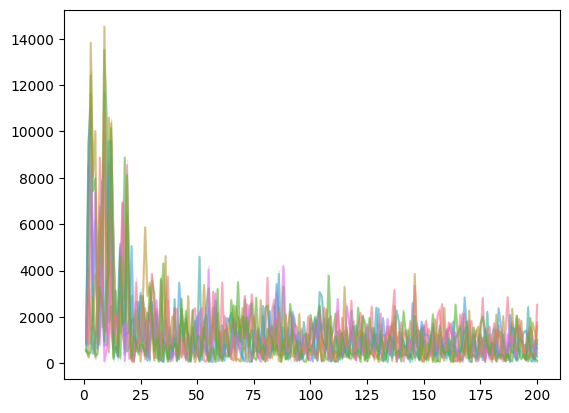

In [32]:
sns.lineplot(data=power_df_demog, x='wavenumber', y='power', hue='subj', palette=sns.color_palette("husl"), alpha=0.5, legend=False)
plt.show()

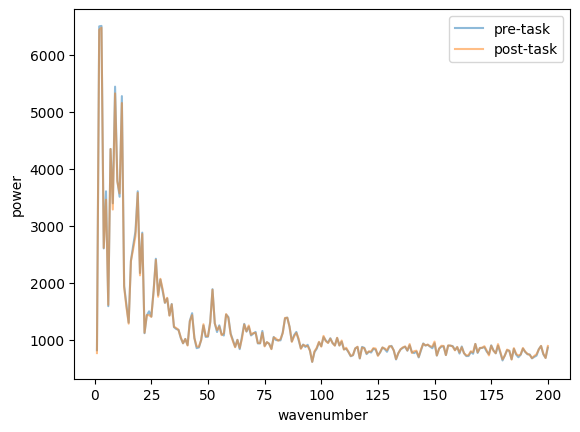

In [47]:
mean_power = power_df_demog.groupby(['pre_post', 'wavenumber'])['power'].mean().reset_index()
mean_power
ax = sns.lineplot(data=mean_power, x='wavenumber', y='power', hue='pre_post', alpha=0.5,legend=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["pre-task", "post-task"], title=None)

In [49]:
power_glm_pre_post = {}
for wn, subset in power_df_demog.groupby('wavenumber'):
    model = sm.MixedLM.from_formula(
        formula = 'power ~ pre_post + age + sex', 
        groups = 'subj',
        data=subset)
    result = model.fit(reml=False) #reml is for residual maximum likelihood, False for conventional ML?
    power_glm_pre_post[wn] = result
    print(f"Results for wavenumber = {wn}")
    print(result.summary())
    print("\n" + "="*80 + "\n")

Results for wavenumber = 1
           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               57756.4281
Min. group size:   2        Log-Likelihood:      -1074.4946
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept   828.336  108.216  7.654 0.000  616.236 1040.436
pre_post    -50.737   39.245 -1.293 0.196 -127.656   26.181
age          -0.088    2.357 -0.037 0.970   -4.708    4.532
sex         -12.145   69.694 -0.174 0.862 -148.743  124.454
subj Var  53600.639   79.258                               



Results for wavenumber = 2
              Mixed Linear Model Regression Results
Mo

In [50]:
power_glm_pre_post_groupcov = {}
for wn, subset in power_df_demog.groupby('wavenumber'):
    model = sm.MixedLM.from_formula(
        formula = 'power ~ pre_post + age + sex + pre_post*group', 
        groups = 'subj',
        data=subset)
    result = model.fit(reml=False) #reml is for residual maximum likelihood, False for conventional ML?
    power_glm_pre_post_groupcov[wn] = result
    print(f"Results for wavenumber = {wn}")
    print(result.summary())
    print("\n" + "="*80 + "\n")

Results for wavenumber = 1
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                57756.3768
Min. group size:      2         Log-Likelihood:       -1074.4056
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------
Intercept        815.702  116.950  6.975 0.000  586.485 1044.920
pre_post         -50.206   77.972 -0.644 0.520 -203.028  102.616
age               -0.338    2.428 -0.139 0.889   -5.096    4.420
sex              -16.770   70.469 -0.238 0.812 -154.886  121.347
group             33.912   91.406  0.371 0.711 -145.241  213.064
pre_post:gro

In [51]:
rows = []
for wn, res in power_glm_pre_post.items():
    # Depending on your model, the intercept might be called 'Intercept' or 'const'
    if 'Intercept' in res.params:
        intercept = res.params['Intercept']
        p_intercept = res.pvalues['Intercept']
    elif 'const' in res.params:
        intercept = res.params['const']
        p_intercept = res.pvalues['const']
    else:
        intercept = None
        p_intercept = None

    # Extract coefficients for pre_post, age, and sex (assuming they are named exactly as such)
    beta_pre_post = res.params.get('pre_post', None)
    p_pre_post    = res.pvalues.get('pre_post', None)
    beta_age   = res.params.get('age', None)
    p_age      = res.pvalues.get('age', None)
    beta_sex   = res.params.get('sex', None)
    p_sex      = res.pvalues.get('sex', None)

    rows.append({
        'wavenumber': wn,
        'intercept': intercept,
        'beta_pre_post': beta_pre_post,
        'beta_age': beta_age,
        'beta_sex': beta_sex,
        'p_intercept': p_intercept,
        'p_pre_post': p_pre_post,
        'p_age': p_age,
        'p_sex': p_sex
    })

# Create a summary DataFrame
power_glm_pre_post_df = pd.DataFrame(rows)
pd.options.display.max_rows = 100  # Change 50 to your desired number
power_glm_pre_post_df

,wavenumber,intercept,beta_pre_post,beta_age,beta_sex,p_intercept,p_pre_post,p_age,p_sex
0,1,828.335851,-50.737325,-0.087953,-12.144633,1.941296e-14,0.196068,0.970235,0.861665
1,2,8030.389511,-58.620003,-18.077572,-1270.008674,9.124016e-07,0.289526,0.617728,0.235695
2,3,6530.600777,-31.761516,-14.060520,799.660396,4.497474e-05,0.509555,0.691604,0.445458
3,4,2408.225369,9.616797,-4.133228,543.559809,1.274065e-03,0.810520,0.802788,0.266657
4,5,2684.084390,-147.603852,11.198930,748.586524,1.938572e-02,0.000058,0.659584,0.319332
...,...,...,...,...,...,...,...,...,...
195,196,604.492461,-5.878377,5.389263,33.802161,3.449318e-03,0.614925,0.238929,0.802728
196,197,581.072880,2.831811,7.575801,24.515513,6.537584e-03,0.775425,0.109324,0.860884
197,198,760.580395,10.669905,0.340302,-43.220440,2.368118e-04,0.318772,0.940784,0.749658
198,199,763.936743,-2.126702,-2.349699,13.871183,1.658272e-05,0.834469,0.549648,0.904916


In [52]:
def hedges_g(sample1, sample2):
    # Sample sizes
    n1 = len(sample1)
    n2 = len(sample2)
    
    # Means
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    
    # Sample standard deviations (using ddof=1 for an unbiased estimator)
    std1 = np.std(sample1, ddof=1)
    std2 = np.std(sample2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    
    # Degrees of freedom
    #df = n1 + n2 - 2
    
    # Correction factor J for Hedges' g
    #J = 1 - (3 / (4 * df - 1))
    
    # Hedges' g
    #g = d * J
    #return g

    return d #just the uncorrected version

In [57]:
power_p_pre_post.sort_values()

7      0.000019
11     0.000034
4      0.000058
8      0.000083
17     0.000248
         ...   
85     0.972374
6      0.978059
46     0.979124
162    0.985600
167    0.995186
Name: p_pre_post, Length: 200, dtype: float64

In [58]:
np.where(power_p_pre_post < 0.05)

(array([  4,   7,   8,  10,  11,  16,  17,  23,  42,  53,  56,  64,  73,
         79,  89,  92,  93, 128, 140, 148, 166, 173, 177, 186, 194, 199]),)

In [34]:
power_p_pre_post_bonfcorr.sort_values()[0:10]

7      0.003738
11     0.006753
4      0.011587
8      0.016595
17     0.049562
64     0.367005
186    0.411166
23     0.558520
177    0.783291
53     1.551364
Name: p_pre_post, dtype: float64

In [62]:
import statsmodels.stats.multitest as smm

# False discovery rate
# Example array of p-values from multiple tests
# Adjust the p-values using the Benjamini-Hochberg method for FDR control
# alpha is the desired overall false discovery rate (e.g., 0.05)
power_pre_post_rejected, power_pre_post_pvals_corrected, power_pre_post_alphacSidak, power_pre_post_alphacBonf = smm.multipletests(power_p_pre_post, alpha=0.05, method='fdr_bh')

pd.Series(power_pre_post_pvals_corrected).sort_values()[0:10]

7      0.003376
11     0.003376
4      0.003862
8      0.004149
17     0.009912
64     0.058738
186    0.058738
23     0.069815
177    0.087032
53     0.155136
dtype: float64

In [60]:
power_pre_post_pvals_corrected

array([0.69251275, 0.71487814, 0.84925808, 0.94899633, 0.0038625 ,
       0.69251275, 0.98901366, 0.00337629, 0.00414868, 0.69251275,
       0.31434688, 0.00337629, 0.79455646, 0.58089433, 0.83274022,
       0.92116621, 0.17116547, 0.0099123 , 0.60704347, 0.58089433,
       0.70716245, 0.89631751, 0.91434339, 0.06981504, 0.94899633,
       0.77660845, 0.79455646, 0.58608178, 0.79455646, 0.42006599,
       0.95699965, 0.84925808, 0.94797451, 0.91434339, 0.89631751,
       0.69251275, 0.95699965, 0.84088235, 0.96146157, 0.96146157,
       0.88084962, 0.89631751, 0.28862   , 0.96146157, 0.52051651,
       0.69251275, 0.98901366, 0.52108533, 0.58852304, 0.92116621,
       0.69251275, 0.79455646, 0.94899633, 0.15513635, 0.69251275,
       0.69251275, 0.23159191, 0.8522714 , 0.57897829, 0.79148299,
       0.58608178, 0.89113172, 0.96146157, 0.58608178, 0.05873801,
       0.79455646, 0.89631751, 0.60704347, 0.69251275, 0.83274022,
       0.69251275, 0.79455646, 0.95559527, 0.29011267, 0.79455

In [27]:
power_smd_pre_post[0:10]

array([ 0.1510029 ,  0.01302855,  0.00726168, -0.00467982,  0.04689592,
       -0.015813  , -0.00025812,  0.04531163,  0.02330665,  0.00796021])

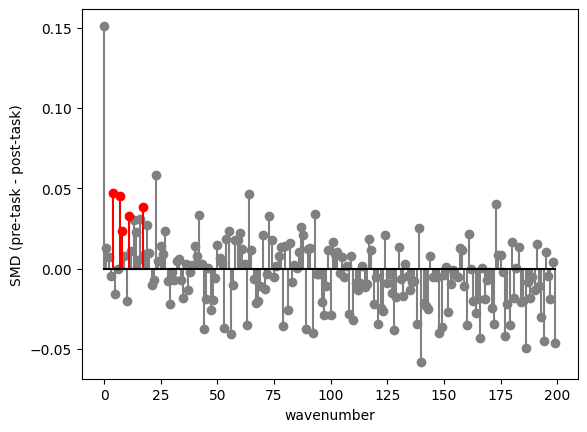

In [56]:
n_waves = pre_GED_data_dict['UNI012'].shape[0]
power_p_pre_post = power_glm_pre_post_df['p_pre_post']
power_p_pre_post_bonfcorr = power_glm_pre_post_df['p_pre_post']*n_waves

# Define a condition for highlighting (e.g., y values > 5)
alpha_thr = 0.05
power_mask_pre_post = power_p_pre_post_bonfcorr < alpha_thr

# Plot non-highlighted stems
#plt.stem(np.where(~power_mask_pre_post)[0], power_p_pre_post[~power_mask_pre_post], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
#plt.stem(np.where(power_mask_pre_post)[0], power_p_pre_post[power_mask_pre_post],  linefmt='red', markerfmt='ro', basefmt='k-')
#plt.show()

power_smd_pre_post = []
for wn, subset in power_df_demog.groupby(['wavenumber']):
    g = hedges_g(subset[subset['pre_post'] == 0]['power'],subset[subset['pre_post'] == 1]['power'])
    power_smd_pre_post.append(g)
power_smd_pre_post = np.array(power_smd_pre_post)

# Plot non-highlighted stems
plt.stem(np.where(~power_mask_pre_post)[0], power_smd_pre_post[~np.array(power_mask_pre_post)], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(power_mask_pre_post)[0], power_smd_pre_post[np.array(power_mask_pre_post)],  linefmt='red', markerfmt='ro', basefmt='k-')
plt.xlabel("wavenumber")
plt.ylabel("SMD (pre-task - post-task)")
plt.show()

In [43]:
rows = []
for wn, res in power_glm_pre_post_groupcov.items():
    # Depending on your model, the intercept might be called 'Intercept' or 'const'
    if 'Intercept' in res.params:
        intercept = res.params['Intercept']
        p_intercept = res.pvalues['Intercept']
    elif 'const' in res.params:
        intercept = res.params['const']
        p_intercept = res.pvalues['const']
    else:
        intercept = None
        p_intercept = None

    # Extract coefficients for pre_post, age, and sex (assuming they are named exactly as such)
    beta_pre_post = res.params.get('pre_post', None)
    p_pre_post    = res.pvalues.get('pre_post', None)
    beta_age   = res.params.get('age', None)
    p_age      = res.pvalues.get('age', None)
    beta_sex   = res.params.get('sex', None)
    p_sex      = res.pvalues.get('sex', None)
    beta_group   = res.params.get('group', None)
    p_group      = res.pvalues.get('group', None)
    beta_pre_post_group   = res.params.get('pre_post:group', None)
    p_pre_post_group      = res.pvalues.get('pre_post:group', None)

    rows.append({
        'wavenumber': wn,
        'intercept': intercept,
        'beta_pre_post': beta_pre_post,
        'beta_age': beta_age,
        'beta_sex': beta_sex,
        'beta_group' : beta_group,
        'beta_pre_post_group' : beta_pre_post_group,
        'p_intercept': p_intercept,
        'p_pre_post': p_pre_post,
        'p_age': p_age,
        'p_sex': p_sex,
        'p_group' : p_group,
        'p_pre_post_group' : p_pre_post_group
    })

# Create a summary DataFrame
power_glm_pre_post_groupcov_df = pd.DataFrame(rows)
pd.options.display.max_rows = 100  # Change 50 to your desired number
power_glm_pre_post_groupcov_df

,wavenumber,intercept,beta_pre_post,beta_age,beta_sex,beta_group,beta_pre_post_group,p_intercept,p_pre_post,p_age,p_sex,p_group,p_pre_post_group
0,1,815.702143,-50.206244,-0.337836,-16.769643,33.911862,-0.711269,3.062968e-12,0.519639,0.889321,0.811902,0.710636,0.993711
1,2,8637.830649,-72.799220,-5.948237,-1045.510472,-1638.316039,18.990022,2.600088e-07,0.507873,0.871957,0.329102,0.175814,0.881355
2,3,6482.621277,22.869167,-14.478012,791.933146,92.647225,-73.166093,9.477347e-05,0.810550,0.692007,0.455391,0.938362,0.507519
3,4,2289.181636,62.022248,-6.008962,508.842417,286.981001,-70.185872,3.141069e-03,0.434631,0.724391,0.303669,0.608292,0.444882
4,5,2973.922795,-85.864400,17.678427,868.513592,-828.773743,-82.686766,1.194438e-02,0.236039,0.497124,0.250467,0.331578,0.324124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,580.577905,-8.981427,4.874753,24.279258,67.014398,4.155870,6.756812e-03,0.698816,0.300922,0.859122,0.665274,0.877055
196,197,558.538328,-21.396788,6.875765,11.558763,77.781712,32.449016,1.159785e-02,0.271386,0.157752,0.934796,0.626394,0.149495
197,198,774.305584,-12.329539,0.385264,-42.388239,-21.439353,30.802827,3.123828e-04,0.557868,0.934995,0.757213,0.890099,0.205848
198,199,801.119466,2.992009,-1.546761,28.732518,-104.397009,-6.855417,1.252517e-05,0.882294,0.701240,0.806063,0.430895,0.769414


In [ ]:
# MDD vs HC first

Skip to Main
import pickle
import numpy as np
import os
import nibabel as nib
import sys
import matplotlib.pyplot as plt
import glob
#import h5py
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
'''
fsavg_mat = h5py.File('combined_harmonics_fsaverage5_white_Gibbs_nsamples20712081_smoothIter0_szBnd5_extScaling2_10taZsc10_localSpread2_anisotropy0_callosectomy0.mat','r')
harmonics = np.array(fsavg_mat.get('H'))
eigvals = np.array(fsavg_mat.get('eigvals'))
eigvals = np.diag(eigvals)
'''

"\nfsavg_mat = h5py.File('combined_harmonics_fsaverage5_white_Gibbs_nsamples20712081_smoothIter0_szBnd5_extScaling2_10taZsc10_localSpread2_anisotropy0_callosectomy0.mat','r')\nharmonics = np.array(fsavg_mat.get('H'))\neigvals = np.array(fsavg_mat.get('eigvals'))\neigvals = np.diag(eigvals)\n"

pre_GED = sorted(glob.glob("GED/sub-UNI*ses-pre_GED.pkl"))
pre_GED

baseline_pre_GED = {} #get only baseline scans, not post-treatment (earlier dates)
for file in pre_GED:
    basename = os.path.basename(file)
    pattern = basename[0:10] #extract only sub-UNIxxx
    
    # Only add the file if its starting pattern hasn't been encountered yet - will add the first items in sorted list
    if pattern not in baseline_pre_GED:
        baseline_pre_GED[pattern] = file

# drop UNI00x and UNI999
for key in list(baseline_pre_GED.keys()):
    if key.startswith('sub-UNI00') or key.startswith('sub-UNI9'):
        del baseline_pre_GED[key]
        
post_GED = sorted(glob.glob("GED/sub-UNI*ses-post_GED.pkl"))
post_GED

baseline_post_GED = {} #get only baseline scans, not post-treatment (earlier dates)
for file in post_GED:
    basename = os.path.basename(file)
    pattern = basename[0:10] #extract only sub-UNIxxx
    
    # Only add the file if its starting pattern hasn't been encountered yet - will add the first items in sorted list
    if pattern not in baseline_post_GED:
        baseline_post_GED[pattern] = file

# drop UNI00x and UNI999
for key in list(baseline_post_GED.keys()):
    if key.startswith('sub-UNI00') or key.startswith('sub-UNI9'):
        del baseline_post_GED[key]
        
baseline_pre_GED, baseline_post_GED

Mismatch for key 'sub-UNI091': 'GED/sub-UNI09120240708' != 'GED/sub-UNI09120240724'
Mismatch for key 'sub-UNI090': 'GED/sub-UNI09020240709' != 'GED/sub-UNI09020240722'
True

pre_GED_data_dict = {}

for key in baseline_pre_GED.keys():
    file = baseline_pre_GED[key]
    with open(file,'rb') as f:
        data = pickle.load(f)
    f.close()
    newkey = key.split('-')[1] #scratch the sub-
    pre_GED_data_dict[newkey] = data
post_GED_data_dict = {}

for key in baseline_post_GED.keys():
    file = baseline_post_GED[key]
    with open(file,'rb') as f:
        data = pickle.load(f)
    f.close()
    newkey = key.split('-')[1] #scratch the sub-
    post_GED_data_dict[newkey] = data
def power(array): #harmonics x timepoints
    result = np.array([np.sum(np.abs(array[i,:])) for i in range(array.shape[0])])
    return result

#def energy(array):
#    result = np.array([np.sum((eigvals[i]**2)*(array[i,:]**2)) for i in range(array.shape[0])])
#    return result
pre_GED_power_dict = {key:power(pre_GED_data_dict[key]) for key in pre_GED_data_dict.keys()}
post_GED_power_dict = {key:power(post_GED_data_dict[key]) for key in post_GED_data_dict.keys()}

#pre_GED_energy_dict = {key:energy(pre_GED_data_dict[key]) for key in pre_GED_data_dict.keys()}
#post_GED_energy_dict = {key:energy(post_GED_data_dict[key]) for key in post_GED_data_dict.keys()}
demographics = pd.read_excel('demographics.xlsx', sheet_name=1)
df = demographics[demographics['Participant ID'].isin(pre_GED_data_dict.keys())] #grab only the subjects with imaging data
df.head()
	record_id 	regist_sex_Male_is_0_Female_is_1 	age_in_yrs 	Study Status 	Participant ID 	Screening Date 	Cohort? 	Hispanic / Latino 	Race
0 	60 	0 	31 	Complete 	UNI060 	09.29.2023 	HC 	No 	Asian
1 	55 	0 	24 	Complete 	UNI055 	09.15.2023 	HC 	No 	White
2 	47 	0 	23 	Complete 	UNI047 	06.29.23 	HC 	No 	White
3 	43 	0 	23 	Complete 	UNI043 	06.14.23 	HC 	Yes 	White
5 	144 	0 	27 	completed 	UNI144 	01.30.2025 	HC 	No 	Asian
df.describe(include='all') #age mean 38.6 total, std 14.2
	record_id 	regist_sex_Male_is_0_Female_is_1 	age_in_yrs 	Study Status 	Participant ID 	Screening Date 	Cohort? 	Hispanic / Latino 	Race
count 	75.00000 	75.000000 	75.000000 	75 	75 	74 	75 	73 	74
unique 	NaN 	NaN 	NaN 	7 	75 	69 	2 	3 	10
top 	NaN 	NaN 	NaN 	Complete 	UNI060 	9.10.2024 	MDD 	No 	White
freq 	NaN 	NaN 	NaN 	37 	1 	2 	56 	33 	48
mean 	85.88000 	0.653333 	38.680000 	NaN 	NaN 	NaN 	NaN 	NaN 	NaN
std 	41.17496 	0.479113 	14.166157 	NaN 	NaN 	NaN 	NaN 	NaN 	NaN
min 	12.00000 	0.000000 	18.000000 	NaN 	NaN 	NaN 	NaN 	NaN 	NaN
25% 	52.00000 	0.000000 	27.000000 	NaN 	NaN 	NaN 	NaN 	NaN 	NaN
50% 	85.00000 	1.000000 	34.000000 	NaN 	NaN 	NaN 	NaN 	NaN 	NaN
75% 	123.00000 	1.000000 	53.000000 	NaN 	NaN 	NaN 	NaN 	NaN 	NaN
max 	150.00000 	1.000000 	65.000000 	NaN 	NaN 	NaN 	NaN 	NaN 	NaN
df.value_counts('Cohort?')

Cohort?
MDD    56
HC     19
Name: count, dtype: int64

df[df['Cohort?'] == 'HC'].describe(include='all'), df[df['Cohort?'] == 'MDD'].describe(include='all') #very disjoint rn, HC age mean is 29.2+/-11.25, MDD age mean 40.23+/-14.10, sex HC 40.0%F, MDD 70.18%F

(         record_id  regist_sex_Male_is_0_Female_is_1  age_in_yrs Study Status  \
 count    19.000000                         19.000000   19.000000           19   
 unique         NaN                               NaN         NaN            5   
 top            NaN                               NaN         NaN     Complete   
 freq           NaN                               NaN         NaN            7   
 mean     99.000000                          0.526316   32.789474          NaN   
 std      49.129082                          0.512989   12.416740          NaN   
 min      16.000000                          0.000000   22.000000          NaN   
 25%      51.000000                          0.000000   23.500000          NaN   
 50%     134.000000                          1.000000   27.000000          NaN   
 75%     141.500000                          1.000000   39.500000          NaN   
 max     150.000000                          1.000000   59.000000          NaN   
 
        Participant ID Screening Date Cohort? Hispanic / Latino   Race  
 count              19             18      19                18     18  
 unique             19             17       1                 3      2  
 top            UNI060     01.14.2025      HC               No   White  
 freq                1              2      19                 9     10  
 mean              NaN            NaN     NaN               NaN    NaN  
 std               NaN            NaN     NaN               NaN    NaN  
 min               NaN            NaN     NaN               NaN    NaN  
 25%               NaN            NaN     NaN               NaN    NaN  
 50%               NaN            NaN     NaN               NaN    NaN  
 75%               NaN            NaN     NaN               NaN    NaN  
 max               NaN            NaN     NaN               NaN    NaN  ,
          record_id  regist_sex_Male_is_0_Female_is_1  age_in_yrs Study Status  \
 count    56.000000                         56.000000   56.000000           56   
 unique         NaN                               NaN         NaN            5   
 top            NaN                               NaN         NaN     Complete   
 freq           NaN                               NaN         NaN           30   
 mean     81.428571                          0.696429   40.678571          NaN   
 std      37.569745                          0.463961   14.265161          NaN   
 min      12.000000                          0.000000   18.000000          NaN   
 25%      52.500000                          0.000000   27.750000          NaN   
 50%      80.500000                          1.000000   36.500000          NaN   
 75%     114.750000                          1.000000   53.500000          NaN   
 max     148.000000                          1.000000   65.000000          NaN   
 
        Participant ID Screening Date Cohort? Hispanic / Latino   Race  
 count              56             56      56                55     56  
 unique             56             52       1                 3     10  
 top            UNI083     04.05.2024     MDD                No  White  
 freq                1              2      56                25     38  
 mean              NaN            NaN     NaN               NaN    NaN  
 std               NaN            NaN     NaN               NaN    NaN  
 min               NaN            NaN     NaN               NaN    NaN  
 25%               NaN            NaN     NaN               NaN    NaN  
 50%               NaN            NaN     NaN               NaN    NaN  
 75%               NaN            NaN     NaN               NaN    NaN  
 max               NaN            NaN     NaN               NaN    NaN  )

power_pre_df = pd.DataFrame.from_dict(pre_GED_power_dict,orient='index')
power_pre_df = power_pre_df.stack().reset_index()
power_pre_df.columns = ['Participant ID', 'wavenumber', 'power']
power_pre_df['wavenumber'] = power_pre_df['wavenumber']+1
power_pre_df['pre_post'] = 0
power_post_df = pd.DataFrame.from_dict(post_GED_power_dict,orient='index')
power_post_df = power_post_df.stack().reset_index()
power_post_df.columns = ['Participant ID', 'wavenumber', 'power']
power_post_df['wavenumber'] = power_post_df['wavenumber']+1
power_post_df['pre_post'] = 1
power_df = pd.concat([power_pre_df, power_post_df], ignore_index=True)
power_df
	Participant ID 	wavenumber 	power 	pre_post
0 	UNI012 	1 	697.608842 	0
1 	UNI012 	2 	4047.547582 	0
2 	UNI012 	3 	603.356513 	0
3 	UNI012 	4 	643.104090 	0
4 	UNI012 	5 	367.672133 	0
... 	... 	... 	... 	...
36395 	UNI178 	196 	243.220041 	1
36396 	UNI178 	197 	378.940442 	1
36397 	UNI178 	198 	958.675431 	1
36398 	UNI178 	199 	553.422700 	1
36399 	UNI178 	200 	450.824982 	1

36400 rows × 4 columns
power_df_demog = pd.merge(df, power_df, on='Participant ID', how='inner')
power_df_demog = power_df_demog.sort_values(by=['Participant ID', 'wavenumber'], ascending=True) #sort

power_df_demog
	record_id 	regist_sex_Male_is_0_Female_is_1 	age_in_yrs 	Study Status 	Participant ID 	Screening Date 	Cohort? 	Hispanic / Latino 	Race 	wavenumber 	power 	pre_post
23600 	12 	1 	61 	Complete 	UNI012 	2022-07-11 00:00:00 	MDD 	No 	White 	1 	697.608842 	0
23800 	12 	1 	61 	Complete 	UNI012 	2022-07-11 00:00:00 	MDD 	No 	White 	1 	1093.689850 	1
23601 	12 	1 	61 	Complete 	UNI012 	2022-07-11 00:00:00 	MDD 	No 	White 	2 	4047.547582 	0
23801 	12 	1 	61 	Complete 	UNI012 	2022-07-11 00:00:00 	MDD 	No 	White 	2 	4376.212367 	1
23602 	12 	1 	61 	Complete 	UNI012 	2022-07-11 00:00:00 	MDD 	No 	White 	3 	603.356513 	0
... 	... 	... 	... 	... 	... 	... 	... 	... 	... 	... 	... 	...
12797 	150 	1 	24 	in screening 	UNI150 	NaN 	HC 	NaN 	NaN 	198 	1817.866859 	1
12598 	150 	1 	24 	in screening 	UNI150 	NaN 	HC 	NaN 	NaN 	199 	1418.178341 	0
12798 	150 	1 	24 	in screening 	UNI150 	NaN 	HC 	NaN 	NaN 	199 	1369.643284 	1
12599 	150 	1 	24 	in screening 	UNI150 	NaN 	HC 	NaN 	NaN 	200 	1277.788708 	0
12799 	150 	1 	24 	in screening 	UNI150 	NaN 	HC 	NaN 	NaN 	200 	1298.607534 	1

30000 rows × 12 columns
power_df_demog = pd.merge(df, power_df, on='Participant ID', how='inner')
power_df_demog = power_df_demog.sort_values(by=['Participant ID', 'wavenumber'], ascending=True) #sort
power_df_demog = power_df_demog[['Participant ID','regist_sex_Male_is_0_Female_is_1','age_in_yrs','Cohort?','Hispanic / Latino','Race','wavenumber','power','pre_post']] #take only useful columns
power_df_demog = power_df_demog.rename(columns={'Participant ID': 'subj', 'regist_sex_Male_is_0_Female_is_1': 'sex', 'age_in_yrs':'age','Cohort?':'group','Hispanic / Latino':'hispanic','Race':'race'})
power_df_demog['group'] = power_df_demog['group'].map({'HC': 0, 'MDD': 1}) #remap HC as 0, MDD as 1
power_df_demog
	subj 	sex 	age 	group 	hispanic 	race 	wavenumber 	power 	pre_post
23600 	UNI012 	1 	61 	1 	No 	White 	1 	697.608842 	0
23800 	UNI012 	1 	61 	1 	No 	White 	1 	1093.689850 	1
23601 	UNI012 	1 	61 	1 	No 	White 	2 	4047.547582 	0
23801 	UNI012 	1 	61 	1 	No 	White 	2 	4376.212367 	1
23602 	UNI012 	1 	61 	1 	No 	White 	3 	603.356513 	0
... 	... 	... 	... 	... 	... 	... 	... 	... 	...
12797 	UNI150 	1 	24 	0 	NaN 	NaN 	198 	1817.866859 	1
12598 	UNI150 	1 	24 	0 	NaN 	NaN 	199 	1418.178341 	0
12798 	UNI150 	1 	24 	0 	NaN 	NaN 	199 	1369.643284 	1
12599 	UNI150 	1 	24 	0 	NaN 	NaN 	200 	1277.788708 	0
12799 	UNI150 	1 	24 	0 	NaN 	NaN 	200 	1298.607534 	1

30000 rows × 9 columns
sns.lineplot(data=power_df_demog, x='wavenumber', y='power', hue='subj', palette=sns.color_palette("husl"), alpha=0.5, legend=False)
plt.show()

/tmp/ipykernel_4848/2303889936.py:1: UserWarning: 
The palette list has fewer values (6) than needed (75) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=power_df_demog, x='wavenumber', y='power', hue='subj', palette=sns.color_palette("husl"), alpha=0.5, legend=False)

---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
Cell In[32], line 1
----> 1 sns.lineplot(data=power_df_demog, x='wavenumber', y='power', hue='subj', palette=sns.color_palette("husl"), alpha=0.5, legend=False)
      2 plt.show()

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/seaborn/relational.py:515, in lineplot(data, x, y, hue, size, style, units, weights, palette, hue_order, hue_norm, sizes, size_order, size_norm, dashes, markers, style_order, estimator, errorbar, n_boot, seed, orient, sort, err_style, err_kws, legend, ci, ax, **kwargs)
    512 color = kwargs.pop("color", kwargs.pop("c", None))
    513 kwargs["color"] = _default_color(ax.plot, hue, color, kwargs)
--> 515 p.plot(ax, kwargs)
    516 return ax

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/seaborn/relational.py:295, in _LinePlotter.plot(self, ax, kws)
    291     grouped = sub_data.groupby(orient, sort=self.sort)
    292     # Could pass as_index=False instead of reset_index,
    293     # but that fails on a corner case with older pandas.
    294     sub_data = (
--> 295         grouped
    296         .apply(agg, other, **groupby_apply_include_groups(False))
    297         .reset_index()
    298     )
    299 else:
    300     sub_data[f"{other}min"] = np.nan

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/pandas/core/groupby/groupby.py:1821, in GroupBy.apply(self, func, include_groups, *args, **kwargs)
   1818     f = func
   1820 if not include_groups:
-> 1821     return self._python_apply_general(f, self._obj_with_exclusions)
   1823 # ignore SettingWithCopy here in case the user mutates
   1824 with option_context("mode.chained_assignment", None):

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/pandas/core/groupby/groupby.py:1887, in GroupBy._python_apply_general(self, f, data, not_indexed_same, is_transform, is_agg)
   1852 @final
   1853 def _python_apply_general(
   1854     self,
   (...)   1859     is_agg: bool = False,
   1860 ) -> NDFrameT:
   1861     """
   1862     Apply function f in python space
   1863 
   (...)   1885         data after applying f
   1886     """
-> 1887     values, mutated = self._grouper.apply_groupwise(f, data, self.axis)
   1888     if not_indexed_same is None:
   1889         not_indexed_same = mutated

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/pandas/core/groupby/ops.py:928, in BaseGrouper.apply_groupwise(self, f, data, axis)
    926 # group might be modified
    927 group_axes = group.axes
--> 928 res = f(group)
    929 if not mutated and not _is_indexed_like(res, group_axes, axis):
    930     mutated = True

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/pandas/core/groupby/groupby.py:1811, in GroupBy.apply.<locals>.f(g)
   1809 @wraps(func)
   1810 def f(g):
-> 1811     return func(g, *args, **kwargs)

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/seaborn/_statistics.py:517, in EstimateAggregator.__call__(self, data, var)
    515 elif self.error_method == "ci":
    516     units = data.get("units", None)
--> 517     boots = bootstrap(vals, units=units, func=self.estimator, **self.boot_kws)
    518     err_min, err_max = _percentile_interval(boots, self.error_level)
    520 return pd.Series({var: estimate, f"{var}min": err_min, f"{var}max": err_max})

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/seaborn/algorithms.py:98, in bootstrap(*args, **kwargs)
     96 boot_dist = []
     97 for i in range(int(n_boot)):
---> 98     resampler = integers(0, n, n, dtype=np.intp)  # intp is indexing dtype
     99     sample = [a.take(resampler, axis=0) for a in args]
    100     boot_dist.append(f(*sample, **func_kwargs))

File numpy/random/_generator.pyx:677, in numpy.random._generator.Generator.integers()

File numpy/random/_bounded_integers.pyx:1315, in numpy.random._bounded_integers._rand_int64()

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3445, in prod(a, axis, dtype, out, keepdims, initial, where)
   3328 @array_function_dispatch(_prod_dispatcher)
   3329 def prod(a, axis=None, dtype=None, out=None, keepdims=np._NoValue,
   3330          initial=np._NoValue, where=np._NoValue):
   3331     """
   3332     Return the product of array elements over a given axis.
   3333 
   (...)   3443     10
   3444     """
-> 3445     return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
   3446                           keepdims=keepdims, initial=initial, where=where)

File ~/cdrc/python_cdrc_2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:77, in _wrapreduction(obj, ufunc, method, axis, dtype, out, **kwargs)
     75     reduction = getattr(obj, method)
     76 except AttributeError:
---> 77     pass
     78 else:
     79     # This branch is needed for reductions like any which don't
     80     # support a dtype.
     81     if dtype is not None:

KeyboardInterrupt: 

mean_power = power_df_demog.groupby(['pre_post', 'wavenumber'])['power'].mean().reset_index()
mean_power
ax = sns.lineplot(data=mean_power, x='wavenumber', y='power', hue='pre_post', alpha=0.5,legend=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["pre-task", "post-task"], title=None)

<matplotlib.legend.Legend at 0x7e72236dfe00>

power_glm_pre_post = {}
for wn, subset in power_df_demog.groupby('wavenumber'):
    model = sm.MixedLM.from_formula(
        formula = 'power ~ pre_post + age + sex', 
        groups = 'subj',
        data=subset)
    result = model.fit(reml=False) #reml is for residual maximum likelihood, False for conventional ML?
    power_glm_pre_post[wn] = result
    print(f"Results for wavenumber = {wn}")
    print(result.summary())
    print("\n" + "="*80 + "\n")

Results for wavenumber = 1
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               57756.4281
Min. group size:   2        Log-Likelihood:      -1074.4946
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept   828.336  108.216  7.654 0.000  616.236 1040.436
pre_post    -50.737   39.245 -1.293 0.196 -127.656   26.181
age          -0.088    2.357 -0.037 0.970   -4.708    4.532
sex         -12.145   69.694 -0.174 0.862 -148.743  124.454
subj Var  53600.639   79.258                               
===========================================================


================================================================================

Results for wavenumber = 2
              Mixed Linear Model Regression Results
=================================================================
Model:                MixedLM   Dependent Variable:   power      
No. Observations:     150       Method:               ML         
No. Groups:           75        Scale:                114867.5907
Min. group size:      2         Log-Likelihood:       -1305.1947 
Max. group size:      2         Converged:            Yes        
Mean group size:      2.0                                        
-----------------------------------------------------------------
             Coef.      Std.Err.   z    P>|z|   [0.025    0.975] 
-----------------------------------------------------------------
Intercept     8030.390  1635.635  4.910 0.000  4824.605 11236.174
pre_post       -58.620    55.346 -1.059 0.290  -167.095    49.855
age            -18.078    36.222 -0.499 0.618   -89.072    52.917
sex          -1270.009  1071.001 -1.186 0.236 -3369.131   829.114
subj Var  19419751.291 13269.197                                 
=================================================================


================================================================================

Results for wavenumber = 3
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                86968.7619
Min. group size:      2         Log-Likelihood:       -1293.1353
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
             Coef.      Std.Err.   z    P>|z|   [0.025   0.975] 
----------------------------------------------------------------
Intercept     6530.601  1600.514  4.080 0.000  3393.651 9667.550
pre_post       -31.762    48.158 -0.660 0.510  -126.149   62.626
age            -14.061    35.446 -0.397 0.692   -83.533   55.412
sex            799.660  1048.035  0.763 0.445 -1254.451 2853.772
subj Var  18607362.890 14605.410                                
================================================================


================================================================================

Results for wavenumber = 4
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               60333.3847
Min. group size:     2        Log-Likelihood:      -1222.3022
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    2408.225  747.488  3.222 0.001  943.176 3873.275
pre_post        9.617   40.111  0.240 0.811  -68.999   88.233
age            -4.133   16.550 -0.250 0.803  -36.571   28.304
sex           543.560  489.343  1.111 0.267 -415.535 1502.654
subj Var  4035890.993 3822.367                               
=============================================================


================================================================================

Results for wavenumber = 5
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               50529.6229
Min. group size:     2        Log-Likelihood:      -1247.8501
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    2684.084 1148.011  2.338 0.019  434.023 4934.145
pre_post     -147.604   36.708 -4.021 0.000 -219.550  -75.658
age            11.199   25.424  0.440 0.660  -38.631   61.029
sex           748.587  751.720  0.996 0.319 -724.758 2221.931
subj Var  9570052.283 9857.902                               
=============================================================


================================================================================

Results for wavenumber = 6
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               16981.1203
Min. group size:     2        Log-Likelihood:      -1152.1540
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1345.668  552.871  2.434 0.015  262.061 2429.275
pre_post       23.839   21.280  1.120 0.263  -17.869   65.547
age             6.591   12.243  0.538 0.590  -17.405   30.587
sex           -17.021  362.000 -0.047 0.962 -726.528  692.487
subj Var  2216686.755 3943.276                               
=============================================================


================================================================================

Results for wavenumber = 7
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   power     
No. Observations:   150       Method:               ML        
No. Groups:         75        Scale:                28291.1047
Min. group size:    2         Log-Likelihood:       -1220.7537
Max. group size:    2         Converged:            Yes       
Mean group size:    2.0                                       
--------------------------------------------------------------
             Coef.     Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------
Intercept    3898.909  1068.982  3.647 0.000 1803.742 5994.075
pre_post        0.755    27.467  0.028 0.978  -53.079   54.590
age            -0.463    23.675 -0.020 0.984  -46.864   45.939
sex           715.360   700.003  1.022 0.307 -656.622 2087.341
subj Var  8306310.604 11423.688                               
==============================================================


================================================================================

Results for wavenumber = 8
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               24450.0587
Min. group size:     2        Log-Likelihood:      -1199.3938
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1790.723  864.929  2.070 0.038   95.493 3485.952
pre_post     -109.286   25.534 -4.280 0.000 -159.332  -59.240
age            35.301   19.155  1.843 0.065   -2.242   72.844
sex           366.456  566.368  0.647 0.518 -743.605 1476.517
subj Var  5434608.391 8044.523                               
=============================================================


================================================================================

Results for wavenumber = 9
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 34011.8302
Min. group size:     2          Log-Likelihood:        -1269.3581
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
             Coef.      Std.Err.   z    P>|z|   [0.025    0.975] 
-----------------------------------------------------------------
Intercept     6764.727  1863.834  3.629 0.000  3111.679 10417.775
pre_post      -118.526    30.116 -3.936 0.000  -177.553   -59.500
age            -23.553    41.280 -0.571 0.568  -104.461    57.355
sex           -628.367  1220.559 -0.515 0.607 -3020.619  1763.884
subj Var  25279717.537 31676.247                                 
=================================================================


================================================================================

Results for wavenumber = 10
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                22914.2679
Min. group size:      2         Log-Likelihood:       -1223.6551
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
             Coef.      Std.Err.   z    P>|z|   [0.025   0.975] 
----------------------------------------------------------------
Intercept     2154.279  1234.608  1.745 0.081  -265.508 4574.066
pre_post       -27.066    24.719 -1.095 0.274   -75.515   21.383
age             35.497    27.344  1.298 0.194   -18.096   89.090
sex            417.389   808.487  0.516 0.606 -1167.216 2001.993
subj Var  11087763.295 16927.541                                
================================================================


================================================================================

Results for wavenumber = 11
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   power     
No. Observations:   150       Method:               ML        
No. Groups:         75        Scale:                31457.0541
Min. group size:    2         Log-Likelihood:       -1222.9844
Max. group size:    2         Converged:            Yes       
Mean group size:    2.0                                       
--------------------------------------------------------------
             Coef.     Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------
Intercept    4567.635  1044.381  4.374 0.000 2520.685 6614.585
pre_post       59.226    28.963  2.045 0.041    2.460  115.993
age           -38.464    23.130 -1.663 0.096  -83.797    6.870
sex           658.884   683.885  0.963 0.335 -681.505 1999.274
subj Var  7925957.754 10340.616                               
==============================================================


================================================================================

Results for wavenumber = 12
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   power     
No. Observations:    150       Method:               ML        
No. Groups:          75        Scale:                32397.1941
Min. group size:     2         Log-Likelihood:       -1243.2386
Max. group size:     2         Converged:            Yes       
Mean group size:     2.0                                       
---------------------------------------------------------------
             Coef.      Std.Err.   z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------
Intercept     4880.504  1348.133  3.620 0.000 2238.212 7522.796
pre_post      -121.876    29.393 -4.146 0.000 -179.484  -64.267
age            -14.346    29.858 -0.480 0.631  -72.866   44.175
sex           1456.195   882.821  1.649 0.099 -274.101 3186.492
subj Var  13217821.254 16977.178                               
===============================================================


================================================================================

Results for wavenumber = 13
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   power     
No. Observations:   150       Method:               ML        
No. Groups:         75        Scale:                20034.1958
Min. group size:    2         Log-Likelihood:       -1172.9900
Max. group size:    2         Converged:            Yes       
Mean group size:    2.0                                       
--------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------
Intercept    3323.057  671.982  4.945 0.000  2005.996 4640.118
pre_post      -21.080   23.114 -0.912 0.362   -66.382   24.222
age           -33.095   14.881 -2.224 0.026   -62.262   -3.928
sex          -145.559  440.007 -0.331 0.741 -1007.956  716.838
subj Var  3277477.916 5362.998                                
==============================================================


================================================================================

Results for wavenumber = 14
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               21669.3995
Min. group size:     2        Log-Likelihood:      -1146.0616
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1388.509  451.314  3.077 0.002  503.950 2273.069
pre_post      -37.382   24.039 -1.555 0.120  -84.497    9.733
age             6.223    9.993  0.623 0.533  -13.362   25.808
sex           -23.133  295.454 -0.078 0.938 -602.213  555.947
subj Var  1471436.666 2325.079                               
=============================================================


================================================================================

Results for wavenumber = 15
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               24729.3370
Min. group size:    2        Log-Likelihood:      -1123.3208
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1474.435  312.124  4.724 0.000  862.684 2086.187
pre_post     -19.337   25.680 -0.753 0.451  -69.669   30.994
age           -2.085    6.907 -0.302 0.763  -15.623   11.453
sex         -140.698  204.233 -0.689 0.491 -540.987  259.590
subj Var  695901.721 1040.134                               
============================================================


================================================================================

Results for wavenumber = 16
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               23725.2115
Min. group size:     2        Log-Likelihood:      -1166.6422
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1263.658  567.444  2.227 0.026  151.487 2375.828
pre_post       -8.757   25.153 -0.348 0.728  -58.056   40.542
age            19.159   12.565  1.525 0.127   -5.469   43.786
sex           592.182  371.520  1.594 0.111 -135.984 1320.348
subj Var  2331887.106 3513.994                               
=============================================================


================================================================================

Results for wavenumber = 17
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               21029.6235
Min. group size:     2        Log-Likelihood:      -1177.8515
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    2321.883  699.805  3.318 0.001  950.292 3693.475
pre_post      -61.491   23.681 -2.597 0.009 -107.905  -15.077
age           -12.085   15.498 -0.780 0.436  -42.460   18.290
sex          1226.984  458.226  2.678 0.007  328.877 2125.092
subj Var  3554876.316 5676.867                               
=============================================================


================================================================================

Results for wavenumber = 18
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   power     
No. Observations:   150       Method:               ML        
No. Groups:         75        Scale:                17797.0891
Min. group size:    2         Log-Likelihood:       -1178.1641
Max. group size:    2         Converged:            Yes       
Mean group size:    2.0                                       
--------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------
Intercept    3126.817  763.854  4.093 0.000  1629.690 4623.943
pre_post      -79.832   21.785 -3.665 0.000  -122.530  -37.134
age             0.946   16.917  0.056 0.955   -32.211   34.102
sex          -398.579  500.186 -0.797 0.426 -1378.926  581.768
subj Var  4239356.143 7354.118                                
==============================================================


================================================================================

Results for wavenumber = 19
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   power     
No. Observations:   150       Method:               ML        
No. Groups:         75        Scale:                16050.1874
Min. group size:    2         Log-Likelihood:       -1202.9278
Max. group size:    2         Converged:            Yes       
Mean group size:    2.0                                       
--------------------------------------------------------------
             Coef.     Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------
Intercept    2406.573  1118.963  2.151 0.031  213.445 4599.701
pre_post      -28.594    20.688 -1.382 0.167  -69.142   11.955
age            17.445    24.783  0.704 0.481  -31.129   66.018
sex           804.149   732.762  1.097 0.272 -632.037 2240.336
subj Var  9109406.160 16619.898                               
==============================================================


================================================================================

Results for wavenumber = 20
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   power     
No. Observations:   150       Method:               ML        
No. Groups:         75        Scale:                27854.1465
Min. group size:    2         Log-Likelihood:       -1171.7897
Max. group size:    2         Converged:            Yes       
Mean group size:    2.0                                       
--------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------
Intercept    2569.551  560.935  4.581 0.000  1470.139 3668.962
pre_post      -41.997   27.254 -1.541 0.123   -95.414   11.420
age            -4.231   12.420 -0.341 0.733   -28.575   20.112
sex          -357.158  367.240 -0.973 0.331 -1076.935  362.619
subj Var  2276129.301 3168.833                                
==============================================================


================================================================================

Results for wavenumber = 21
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   power     
No. Observations:   150       Method:               ML        
No. Groups:         75        Scale:                19602.2157
Min. group size:    2         Log-Likelihood:       -1192.0609
Max. group size:    2         Converged:            Yes       
Mean group size:    2.0                                       
--------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------
Intercept    5056.439  875.983  5.772 0.000  3339.543 6773.334
pre_post      -24.553   22.863 -1.074 0.283   -69.364   20.258
age           -47.707   19.400 -2.459 0.014   -85.731   -9.683
sex          -505.775  573.620 -0.882 0.378 -1630.050  618.500
subj Var  5577417.280 9215.725                                
==============================================================


================================================================================

Results for wavenumber = 22
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               15574.9991
Min. group size:    2        Log-Likelihood:      -1103.8664
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1387.881  303.350  4.575 0.000  793.326 1982.436
pre_post       8.559   20.380  0.420 0.674  -31.384   48.503
age           -1.858    6.715 -0.277 0.782  -15.019   11.303
sex         -307.275  198.547 -1.548 0.122 -696.420   81.871
subj Var  661596.648 1238.667                               
============================================================


================================================================================

Results for wavenumber = 23
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               15698.8634
Min. group size:     2        Log-Likelihood:      -1120.3150
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1737.298  376.172  4.618 0.000 1000.014 2474.581
pre_post        7.680   20.461  0.375 0.707  -32.422   47.782
age            -1.978    8.329 -0.237 0.812  -18.302   14.346
sex          -359.737  246.259 -1.461 0.144 -842.395  122.921
subj Var  1021895.930 1897.757                               
=============================================================


================================================================================

Results for wavenumber = 24
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               19118.2954
Min. group size:     2        Log-Likelihood:      -1136.4528
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1334.987  422.705  3.158 0.002  506.500 2163.474
pre_post      -67.505   22.579 -2.990 0.003 -111.759  -23.250
age             5.250    9.359  0.561 0.575  -13.093   23.594
sex           -59.555  276.725 -0.215 0.830 -601.926  482.816
subj Var  1290740.061 2171.470                               
=============================================================


================================================================================

Results for wavenumber = 25
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               18646.5689
Min. group size:     2        Log-Likelihood:      -1135.8970
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1772.414  424.854  4.172 0.000  939.716 2605.111
pre_post       -5.615   22.299 -0.252 0.801  -49.320   38.090
age            -3.044    9.407 -0.324 0.746  -21.481   15.393
sex          -378.140  278.135 -1.360 0.174 -923.274  166.994
subj Var  1304259.482 2221.554                               
=============================================================


================================================================================

Results for wavenumber = 26
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               17150.8385
Min. group size:     2        Log-Likelihood:      -1150.4627
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1282.491  537.869  2.384 0.017  228.288 2336.695
pre_post      -20.840   21.386 -0.974 0.330  -62.756   21.075
age            11.322   11.911  0.951 0.342  -12.022   34.667
sex           221.622  352.173  0.629 0.529 -468.624  911.869
subj Var  2097427.394 3713.633                               
=============================================================


================================================================================

Results for wavenumber = 27
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               20282.0967
Min. group size:     2        Log-Likelihood:      -1190.8956
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    2202.201  847.906  2.597 0.009  540.336 3864.067
pre_post      -21.336   23.256 -0.917 0.359  -66.917   24.246
age             3.259   18.778  0.174 0.862  -33.546   40.064
sex           144.188  555.229  0.260 0.795 -944.041 1232.418
subj Var  5224557.657 8488.424                               
=============================================================


================================================================================

Results for wavenumber = 28
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               17057.5802
Min. group size:     2        Log-Likelihood:      -1142.7314
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1927.331  486.530  3.961 0.000  973.749 2880.913
pre_post      -31.319   21.328 -1.468 0.142  -73.120   10.482
age            -3.000   10.774 -0.278 0.781  -24.116   18.115
sex           -37.764  318.545 -0.119 0.906 -662.101  586.574
subj Var  1714486.735 3046.664                               
=============================================================


================================================================================

Results for wavenumber = 29
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               8365.1543 
Min. group size:     2        Log-Likelihood:      -1134.0306
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    2436.212  618.552  3.939 0.000 1223.872 3648.552
pre_post       13.133   14.936  0.879 0.379  -16.140   42.407
age            -9.673   13.699 -0.706 0.480  -36.523   17.177
sex            -7.527  405.052 -0.019 0.985 -801.413  786.360
subj Var  2781728.864 7033.983                               
=============================================================


================================================================================

Results for wavenumber = 30
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               10576.0224
Min. group size:    2        Log-Likelihood:      -1127.6405
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
             Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    1436.046  505.217 2.842 0.004  445.840 2426.253
pre_post       31.242   16.794 1.860 0.063   -1.673   64.157
age             2.119   11.188 0.189 0.850  -19.810   24.048
sex           517.538  330.814 1.564 0.118 -130.845 1165.921
subj Var  1853002.096 4172.109                              
============================================================


================================================================================

Results for wavenumber = 31
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               8860.6997 
Min. group size:    2        Log-Likelihood:      -1117.1804
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
------------------------------------------------------------
Intercept    1503.391  480.098  3.131 0.002 562.416 2444.366
pre_post        2.647   15.372  0.172 0.863 -27.481   32.775
age            -6.345   10.632 -0.597 0.551 -27.184   14.494
sex           597.118  314.369  1.899 0.058 -19.034 1213.271
subj Var  1673705.189 4117.098                              
============================================================


================================================================================

Results for wavenumber = 32
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               8813.2531 
Min. group size:     2        Log-Likelihood:      -1124.1286
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    2231.002  528.105  4.225 0.000 1195.935 3266.069
pre_post       10.115   15.330  0.660 0.509  -19.932   40.162
age           -14.098   11.696 -1.205 0.228  -37.021    8.825
sex            62.547  345.812  0.181 0.856 -615.232  740.326
subj Var  2026206.536 4995.219                               
=============================================================


================================================================================

Results for wavenumber = 33
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               14436.4848
Min. group size:     2        Log-Likelihood:      -1128.9613
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    2230.403  440.154  5.067 0.000 1367.717 3093.089
pre_post       -5.695   19.621 -0.290 0.772  -44.151   32.761
age           -15.640    9.746 -1.605 0.109  -34.742    3.463
sex          -300.762  288.179 -1.044 0.297 -865.583  264.058
subj Var  1402951.426 2710.415                               
=============================================================


================================================================================

Results for wavenumber = 34
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               11405.0749
Min. group size:     2        Log-Likelihood:      -1115.2298
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1283.860  412.346  3.114 0.002  475.677 2092.043
pre_post       -6.517   17.439 -0.374 0.709  -40.698   27.663
age            12.364    9.131  1.354 0.176   -5.532   30.261
sex          -205.328  269.979 -0.761 0.447 -734.478  323.821
subj Var  1231973.706 2676.388                               
=============================================================


================================================================================

Results for wavenumber = 35
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               9837.7373 
Min. group size:    2        Log-Likelihood:      -1100.7529
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1398.257  366.052  3.820 0.000  680.809 2115.705
pre_post       6.917   16.197  0.427 0.669  -24.828   38.662
age           -3.660    8.106 -0.452 0.652  -19.547   12.227
sex          -53.509  239.663 -0.223 0.823 -523.241  416.222
subj Var  970407.828 2270.896                               
============================================================


================================================================================

Results for wavenumber = 36
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7424.3641 
Min. group size:    2        Log-Likelihood:      -1086.2776
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1451.020  347.395  4.177 0.000  770.139 2131.901
pre_post      17.698   14.071  1.258 0.208   -9.880   45.276
age           -5.199    7.693 -0.676 0.499  -20.277    9.879
sex          -93.368  227.457 -0.410 0.681 -539.175  352.440
subj Var  874795.872 2354.518                               
============================================================


================================================================================

Results for wavenumber = 37
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               13639.8040
Min. group size:     2        Log-Likelihood:      -1116.8310
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1199.153  385.225  3.113 0.002  444.125 1954.180
pre_post       -3.216   19.072 -0.169 0.866  -40.596   34.164
age             1.235    8.530  0.145 0.885  -15.483   17.953
sex          -110.025  252.201 -0.436 0.663 -604.331  384.280
subj Var  1073222.746 2135.675                               
=============================================================


================================================================================

Results for wavenumber = 38
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               9400.0312 
Min. group size:   2        Log-Likelihood:      -1084.0529
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    788.444  299.756 2.630 0.009  200.933 1375.955
pre_post      11.200   15.832 0.707 0.479  -19.831   42.231
age            5.295    6.637 0.798 0.425   -7.713   18.303
sex           57.127  196.238 0.291 0.771 -327.492  441.745
subj Var  649199.445 1557.309                              
===========================================================


================================================================================

Results for wavenumber = 39
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               9660.4099 
Min. group size:    2        Log-Likelihood:      -1078.1211
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1356.287  273.226  4.964 0.000  820.774 1891.800
pre_post       1.664   16.050  0.104 0.917  -29.794   33.122
age           -4.086    6.049 -0.675 0.499  -15.941    7.770
sex         -398.821  178.855 -2.230 0.026 -749.369  -48.272
subj Var  538354.422 1276.212                               
============================================================


================================================================================

Results for wavenumber = 40
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               13034.8989
Min. group size:    2        Log-Likelihood:      -1090.6204
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    950.443  277.908  3.420 0.001  405.753 1495.134
pre_post      -1.802   18.644 -0.097 0.923  -38.343   34.740
age            2.256    6.152  0.367 0.714   -9.802   14.313
sex          -34.602  181.896 -0.190 0.849 -391.112  321.907
subj Var  555295.683 1136.400                               
============================================================


================================================================================

Results for wavenumber = 41
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               10336.5762
Min. group size:    2        Log-Likelihood:      -1076.3582
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    959.612  258.024  3.719 0.000  453.893 1465.330
pre_post      -9.896   16.602 -0.596 0.551  -42.436   22.644
age           -2.007    5.712 -0.351 0.725  -13.203    9.188
sex           39.740  168.889  0.235 0.814 -291.276  370.756
subj Var  479170.652 1100.146                               
============================================================


================================================================================

Results for wavenumber = 42
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               9223.7649 
Min. group size:    2        Log-Likelihood:      -1089.6460
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1740.799  326.017  5.340 0.000 1101.818 2379.780
pre_post      -7.183   15.683 -0.458 0.647  -37.922   23.556
age          -15.272    7.219 -2.116 0.034  -29.420   -1.123
sex          279.607  213.442  1.310 0.190 -138.732  697.946
subj Var  768970.702 1860.161                               
============================================================


================================================================================

Results for wavenumber = 43
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               8951.2941 
Min. group size:    2        Log-Likelihood:      -1096.4332
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1884.036  362.265  5.201 0.000 1174.010 2594.062
pre_post     -33.652   15.450 -2.178 0.029  -63.933   -3.370
age          -12.716    8.022 -1.585 0.113  -28.439    3.006
sex          114.416  237.188  0.482 0.630 -350.464  579.297
subj Var  950809.104 2331.749                               
============================================================


================================================================================

Results for wavenumber = 44
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7657.0047 
Min. group size:    2        Log-Likelihood:      -1064.4781
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    967.394  255.841  3.781 0.000  465.954 1468.834
pre_post      -2.132   14.289 -0.149 0.881  -30.138   25.875
age            1.165    5.664  0.206 0.837   -9.937   12.267
sex           29.431  167.482  0.176 0.861 -298.827  357.689
subj Var  472471.997 1256.922                               
============================================================


================================================================================

Results for wavenumber = 45
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               11166.6195
Min. group size:   2        Log-Likelihood:      -1086.5948
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    520.711  284.537 1.830 0.067  -36.972 1078.393
pre_post      29.395   17.256 1.703 0.088   -4.427   63.216
age            4.675    6.299 0.742 0.458   -7.672   17.021
sex          231.502  186.254 1.243 0.214 -133.548  596.553
subj Var  583473.025 1287.290                              
===========================================================


================================================================================

Results for wavenumber = 46
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              5096.3706 
Min. group size:    2       Log-Likelihood:     -1046.6879
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025  0.975] 
----------------------------------------------------------
Intercept    637.987  247.346 2.579 0.010 153.197 1122.777
pre_post      12.871   11.658 1.104 0.270  -9.977   35.720
age            1.779    5.477 0.325 0.745  -8.955   12.514
sex          242.034  161.939 1.495 0.135 -75.360  559.428
subj Var  442747.169 1440.506                             
==========================================================


================================================================================

Results for wavenumber = 47
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6299.6529 
Min. group size:    2        Log-Likelihood:      -1062.1754
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1064.442  273.502  3.892 0.000  528.388 1600.497
pre_post      -0.339   12.961 -0.026 0.979  -25.743   25.064
age            2.453    6.056  0.405 0.685   -9.416   14.323
sex         -248.721  179.062 -1.389 0.165 -599.677  102.234
subj Var  541297.270 1584.145                               
============================================================


================================================================================

Results for wavenumber = 48
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6374.6191 
Min. group size:    2        Log-Likelihood:      -1070.8963
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1320.488  305.399  4.324 0.000  721.916 1919.060
pre_post      22.023   13.038  1.689 0.091   -3.531   47.577
age            3.695    6.763  0.546 0.585   -9.560   16.950
sex         -325.637  199.956 -1.629 0.103 -717.544   66.270
subj Var  675729.185 1963.728                               
============================================================


================================================================================

Results for wavenumber = 49
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5590.9760 
Min. group size:   2        Log-Likelihood:      -1072.2532
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    806.258  332.034 2.428 0.015  155.482 1457.033
pre_post      17.574   12.210 1.439 0.150   -6.358   41.506
age            4.776    7.353 0.650 0.516   -9.636   19.187
sex           89.441  217.408 0.411 0.681 -336.671  515.552
subj Var  799800.829 2478.650                              
===========================================================


================================================================================

Results for wavenumber = 50
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6987.5692 
Min. group size:    2        Log-Likelihood:      -1073.2519
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1138.379  301.013  3.782 0.000  548.405 1728.354
pre_post       4.759   13.650  0.349 0.727  -21.996   31.513
age           -1.796    6.665 -0.270 0.788  -14.860   11.267
sex          -20.512  197.078 -0.104 0.917 -406.779  365.755
subj Var  656021.618 1822.040                               
============================================================


================================================================================

Results for wavenumber = 51
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6315.5442 
Min. group size:    2        Log-Likelihood:      -1084.3693
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    948.014  367.177  2.582 0.010  228.361 1667.667
pre_post     -14.765   12.977 -1.138 0.255  -40.200   10.670
age            8.298    8.131  1.020 0.307   -7.639   24.235
sex           73.971  240.421  0.308 0.758 -397.246  545.188
subj Var  978347.861 2851.883                               
============================================================


================================================================================

Results for wavenumber = 52
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   power     
No. Observations:   150       Method:               ML        
No. Groups:         75        Scale:                5223.3753 
Min. group size:    2         Log-Likelihood:       -1102.2330
Max. group size:    2         Converged:            Yes       
Mean group size:    2.0                                       
--------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------
Intercept    2506.415  512.280  4.893 0.000  1502.364 3510.466
pre_post       -9.668   11.802 -0.819 0.413   -32.799   13.464
age            -9.276   11.346 -0.818 0.414   -31.514   12.961
sex          -397.412  335.463 -1.185 0.236 -1054.908  260.083
subj Var  1908279.338 6105.421                                
==============================================================


================================================================================

Results for wavenumber = 53
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5840.7857 
Min. group size:    2        Log-Likelihood:      -1074.7413
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1164.868  335.815  3.469 0.001  506.682 1823.054
pre_post      -3.006   12.480 -0.241 0.810  -27.466   21.455
age           -1.987    7.437 -0.267 0.789  -16.563   12.588
sex          308.251  219.883  1.402 0.161 -122.712  739.213
subj Var  818052.320 2480.611                               
============================================================


================================================================================

Results for wavenumber = 54
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6073.2587 
Min. group size:    2        Log-Likelihood:      -1073.6727
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1689.049  324.673  5.202 0.000 1052.702 2325.396
pre_post      33.883   12.726  2.662 0.008    8.940   58.826
age          -15.628    7.190 -2.174 0.030  -29.720   -1.537
sex           78.475  212.583  0.369 0.712 -338.180  495.130
subj Var  764330.977 2273.906                               
============================================================


================================================================================

Results for wavenumber = 55
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               10650.0044
Min. group size:    2        Log-Likelihood:      -1103.1057
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1741.563  363.036  4.797 0.000 1030.024 2453.101
pre_post     -18.668   16.852 -1.108 0.268  -51.698   14.362
age          -16.012    8.039 -1.992 0.046  -31.767   -0.256
sex          201.640  237.683  0.848 0.396 -264.210  667.491
subj Var  953952.624 2146.675                               
============================================================


================================================================================

Results for wavenumber = 56
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               9972.9043 
Min. group size:    2        Log-Likelihood:      -1085.9125
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1198.698  298.332  4.018 0.000  613.977 1783.419
pre_post     -19.094   16.308 -1.171 0.242  -51.056   12.869
age           -2.846    6.605 -0.431 0.667  -15.792   10.100
sex           18.153  195.301  0.093 0.926 -364.629  400.936
subj Var  642684.103 1497.582                               
============================================================


================================================================================

Results for wavenumber = 57
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               9153.2499 
Min. group size:    2        Log-Likelihood:      -1092.4562
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1102.721  339.757  3.246 0.001  436.810 1768.632
pre_post      37.760   15.623  2.417 0.016    7.139   68.381
age            0.147    7.523  0.020 0.984  -14.598   14.892
sex          -51.272  222.443 -0.230 0.818 -487.253  384.708
subj Var  835626.608 2028.118                               
============================================================


================================================================================

Results for wavenumber = 58
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7589.3174 
Min. group size:    2        Log-Likelihood:      -1084.2055
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1597.559  334.243  4.780 0.000  942.455 2252.662
pre_post       9.242   14.226  0.650 0.516  -18.641   37.125
age            2.617    7.401  0.354 0.724  -11.890   17.123
sex         -393.210  218.841 -1.797 0.072 -822.131   35.710
subj Var  809419.038 2155.734                               
============================================================


================================================================================

Results for wavenumber = 59
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               4974.0336 
Min. group size:     2        Log-Likelihood:      -1079.8760
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    1798.328  389.661  4.615 0.000 1034.607 2562.050
pre_post      -18.712   11.517 -1.625 0.104  -41.285    3.861
age            -9.401    8.630 -1.089 0.276  -26.315    7.512
sex           -54.245  255.156 -0.213 0.832 -554.341  445.851
subj Var  1103008.995 3619.920                               
=============================================================


================================================================================

Results for wavenumber = 60
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7636.8679 
Min. group size:    2        Log-Likelihood:      -1071.5058
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    903.538  281.325  3.212 0.001  352.152 1454.924
pre_post     -13.496   14.271 -0.946 0.344  -41.466   14.474
age            5.469    6.229  0.878 0.380   -6.740   17.677
sex           -7.284  184.176 -0.040 0.968 -368.263  353.695
subj Var  572170.345 1522.141                               
============================================================


================================================================================

Results for wavenumber = 61
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4558.9620 
Min. group size:    2        Log-Likelihood:      -1049.7402
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    658.742  272.362  2.419 0.016  124.923 1192.561
pre_post     -16.541   11.026 -1.500 0.134  -38.151    5.070
age            8.477    6.031  1.406 0.160   -3.344   20.298
sex            8.318  178.329  0.047 0.963 -341.201  357.837
subj Var  537718.163 1846.905                               
============================================================


================================================================================

Results for wavenumber = 62
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               8362.1270 
Min. group size:    2        Log-Likelihood:      -1068.2189
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    866.363  257.346  3.367 0.001  361.975 1370.752
pre_post      -8.452   14.933 -0.566 0.571  -37.720   20.816
age            3.094    5.698  0.543 0.587   -8.073   14.261
sex         -166.408  168.461 -0.988 0.323 -496.586  163.770
subj Var  477707.714 1216.909                               
============================================================


================================================================================

Results for wavenumber = 63
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7200.6298 
Min. group size:    2        Log-Likelihood:      -1048.0743
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    986.562  212.026  4.653 0.000  570.997 1402.126
pre_post      -1.758   13.857 -0.127 0.899  -28.917   25.401
age            3.149    4.694  0.671 0.502   -6.051   12.348
sex         -166.742  138.779 -1.201 0.230 -438.744  105.260
subj Var  323434.636  890.020                               
============================================================


================================================================================

Results for wavenumber = 64
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7136.0100 
Min. group size:    2        Log-Likelihood:      -1045.0594
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1133.271  204.599  5.539 0.000  732.264 1534.279
pre_post      20.068   13.795  1.455 0.146   -6.969   47.105
age           -7.767    4.529 -1.715 0.086  -16.643    1.110
sex            3.888  133.913  0.029 0.977 -258.577  266.353
subj Var  300935.877  832.451                               
============================================================


================================================================================

Results for wavenumber = 65
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4457.6009 
Min. group size:    2        Log-Likelihood:      -1047.3800
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1140.894  266.909  4.274 0.000  617.762 1664.027
pre_post     -33.970   10.903 -3.116 0.002  -55.339  -12.601
age           -2.753    5.911 -0.466 0.641  -14.338    8.831
sex           27.366  174.758  0.157 0.876 -315.154  369.887
subj Var  516360.241 1793.741                               
============================================================


================================================================================

Results for wavenumber = 66
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5358.4967 
Min. group size:    2        Log-Likelihood:      -1071.6722
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1048.876  336.540  3.117 0.002  389.270 1708.482
pre_post     -10.409   11.954 -0.871 0.384  -33.838   13.020
age            1.695    7.453  0.227 0.820  -12.912   16.302
sex          251.823  220.360  1.143 0.253 -180.075  683.721
subj Var  821864.787 2600.993                               
============================================================


================================================================================

Results for wavenumber = 67
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5635.8330 
Min. group size:    2        Log-Likelihood:      -1077.4072
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1061.198  354.229  2.996 0.003  366.922 1755.475
pre_post       6.021   12.259  0.491 0.623  -18.007   30.048
age           -0.901    7.845 -0.115 0.909  -16.276   14.474
sex          178.409  231.945  0.769 0.442 -276.195  633.013
subj Var  910699.238 2809.765                               
============================================================


================================================================================

Results for wavenumber = 68
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               8045.9029 
Min. group size:   2        Log-Likelihood:      -1089.4400
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept   1123.476  348.084 3.228 0.001  441.244 1805.709
pre_post      20.310   14.648 1.387 0.166   -8.399   49.019
age            0.763    7.708 0.099 0.921  -14.345   15.870
sex          118.789  227.905 0.521 0.602 -327.896  565.475
subj Var  877948.556 2270.690                              
===========================================================


================================================================================

Results for wavenumber = 69
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6355.7149 
Min. group size:    2        Log-Likelihood:      -1058.0861
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    810.660  257.854  3.144 0.002  305.275 1316.045
pre_post      14.375   13.019  1.104 0.270  -11.141   39.891
age            7.984    5.709  1.398 0.162   -3.206   19.174
sex          -66.426  168.811 -0.393 0.694 -397.290  264.438
subj Var  480715.260 1401.735                               
============================================================


================================================================================

Results for wavenumber = 70
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               6458.5244 
Min. group size:   2        Log-Likelihood:      -1075.5614
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    821.444  322.874 2.544 0.011  188.622 1454.265
pre_post       9.830   13.124 0.749 0.454  -15.892   35.551
age            5.292    7.150 0.740 0.459   -8.722   19.305
sex          125.499  211.402 0.594 0.553 -288.841  539.839
subj Var  755635.698 2180.641                              
===========================================================


================================================================================

Results for wavenumber = 71
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7886.3955 
Min. group size:    2        Log-Likelihood:      -1076.3457
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    925.435  295.287  3.134 0.002  346.684 1504.186
pre_post     -16.865   14.502 -1.163 0.245  -45.288   11.558
age            6.704    6.538  1.025 0.305   -6.110   19.519
sex          -71.853  193.321 -0.372 0.710 -450.754  307.049
subj Var  630661.393 1650.297                               
============================================================


================================================================================

Results for wavenumber = 72
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4760.8551 
Min. group size:   2        Log-Likelihood:      -1047.5586
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    521.387  258.891 2.014 0.044   13.969 1028.805
pre_post       9.250   11.267 0.821 0.412  -12.834   31.334
age            8.445    5.733 1.473 0.141   -2.791   19.681
sex          134.266  169.504 0.792 0.428 -197.957  466.488
subj Var  485493.598 1632.897                              
===========================================================


================================================================================

Results for wavenumber = 73
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               7575.5675 
Min. group size:   2        Log-Likelihood:      -1074.5661
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    749.360  294.216 2.547 0.011  172.708 1326.012
pre_post       2.904   14.213 0.204 0.838  -24.954   30.761
age            4.790    6.515 0.735 0.462   -7.979   17.558
sex            4.068  192.622 0.021 0.983 -373.463  381.599
subj Var  626235.127 1671.655                              
===========================================================


================================================================================

Results for wavenumber = 74
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7198.6117 
Min. group size:    2        Log-Likelihood:      -1078.6286
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    508.269  318.603  1.595 0.111 -116.181 1132.719
pre_post     -29.484   13.855 -2.128 0.033  -56.639   -2.328
age           13.485    7.055  1.911 0.056   -0.342   27.313
sex          190.919  208.599  0.915 0.360 -217.928  599.766
subj Var  735276.768 2011.133                               
============================================================


================================================================================

Results for wavenumber = 75
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6751.3024 
Min. group size:    2        Log-Likelihood:      -1050.5148
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    619.425  226.190  2.739 0.006  176.101 1062.749
pre_post     -10.980   13.418 -0.818 0.413  -37.278   15.318
age            4.864    5.008  0.971 0.331   -4.950   14.679
sex          132.526  148.063  0.895 0.371 -157.672  422.725
subj Var  368880.368 1046.221                               
============================================================


================================================================================

Results for wavenumber = 76
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6279.1535 
Min. group size:    2        Log-Likelihood:      -1059.8742
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1372.332  265.675  5.165 0.000  851.619 1893.045
pre_post       3.948   12.940  0.305 0.760  -21.414   29.310
age          -12.525    5.883 -2.129 0.033  -24.055   -0.995
sex          104.437  173.935  0.600 0.548 -236.470  445.343
subj Var  510573.893 1497.161                               
============================================================


================================================================================

Results for wavenumber = 77
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3508.4063 
Min. group size:    2        Log-Likelihood:      -1037.0734
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1107.953  262.217  4.225 0.000  594.017 1621.888
pre_post      -1.261    9.673 -0.130 0.896  -20.219   17.696
age           -7.636    5.807 -1.315 0.189  -19.017    3.745
sex          180.741  171.693  1.053 0.292 -155.770  517.253
subj Var  498800.333 1951.459                               
============================================================


================================================================================

Results for wavenumber = 78
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5231.3280 
Min. group size:    2        Log-Likelihood:      -1045.1934
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1354.663  239.325  5.660 0.000  885.595 1823.730
pre_post      -5.348   11.811 -0.453 0.651  -28.498   17.801
age          -10.540    5.299 -1.989 0.047  -20.926   -0.154
sex         -163.119  156.683 -1.041 0.298 -470.211  143.974
subj Var  414242.961 1331.009                               
============================================================


================================================================================

Results for wavenumber = 79
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4978.5899 
Min. group size:    2        Log-Likelihood:      -1037.0808
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1221.079  220.181  5.546 0.000  789.532 1652.627
pre_post      -8.219   11.522 -0.713 0.476  -30.802   14.364
age           -0.588    4.875 -0.121 0.904  -10.143    8.967
sex         -228.207  144.144 -1.583 0.113 -510.724   54.311
subj Var  350321.085 1154.748                               
============================================================


================================================================================

Results for wavenumber = 80
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6721.7809 
Min. group size:    2        Log-Likelihood:      -1072.1990
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    919.448  302.624  3.038 0.002  326.315 1512.581
pre_post      29.707   13.388  2.219 0.026    3.466   55.948
age            2.345    6.701  0.350 0.726  -10.789   15.480
sex          -24.245  198.136 -0.122 0.903 -412.585  364.094
subj Var  663250.974 1877.697                               
============================================================


================================================================================

Results for wavenumber = 81
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3210.3241 
Min. group size:    2        Log-Likelihood:      -1039.8300
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    582.440  284.372  2.048 0.041   25.080 1139.799
pre_post     -10.968    9.252 -1.185 0.236  -29.103    7.166
age           10.619    6.298  1.686 0.092   -1.724   22.963
sex            0.116  186.207  0.001 1.000 -364.842  365.075
subj Var  587153.572 2399.091                               
============================================================


================================================================================

Results for wavenumber = 82
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5806.4083 
Min. group size:   2        Log-Likelihood:      -1071.3511
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    803.050  321.927 2.495 0.013  172.085 1434.015
pre_post      22.567   12.443 1.814 0.070   -1.822   46.955
age            3.659    7.129 0.513 0.608  -10.314   17.632
sex           69.284  210.786 0.329 0.742 -343.849  482.417
subj Var  751546.392 2286.405                              
===========================================================


================================================================================

Results for wavenumber = 83
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               8253.8067 
Min. group size:    2        Log-Likelihood:      -1083.4999
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    595.019  317.519  1.874 0.061  -27.308 1217.345
pre_post     -13.782   14.836 -0.929 0.353  -42.860   15.295
age           11.665    7.031  1.659 0.097   -2.116   25.445
sex          127.033  207.882  0.611 0.541 -280.409  534.474
subj Var  729678.580 1865.309                               
============================================================


================================================================================

Results for wavenumber = 84
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5761.0816 
Min. group size:   2        Log-Likelihood:      -1075.7281
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept   1481.707  342.605  4.325 0.000 810.213 2153.201
pre_post       8.422   12.395  0.679 0.497 -15.871   32.715
age          -10.908    7.587 -1.438 0.151 -25.778    3.963
sex          482.745  224.331  2.152 0.031  43.065  922.425
subj Var  851643.191 2599.725                              
===========================================================


================================================================================

Results for wavenumber = 85
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  power     
No. Observations:    150      Method:              ML        
No. Groups:          75       Scale:               7401.2223 
Min. group size:     2        Log-Likelihood:      -1094.0147
Max. group size:     2        Converged:           Yes       
Mean group size:     2.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept     931.384  385.732  2.415 0.016  175.362 1687.405
pre_post       -2.651   14.049 -0.189 0.850  -30.186   24.883
age             5.736    8.542  0.671 0.502  -11.006   22.478
sex           361.478  252.569  1.431 0.152 -133.548  856.504
subj Var  1079493.096 2907.451                               
=============================================================


================================================================================

Results for wavenumber = 86
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6359.4448 
Min. group size:    2        Log-Likelihood:      -1078.7125
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1505.830  339.334  4.438 0.000  840.748 2170.912
pre_post      -0.451   13.022 -0.035 0.972  -25.975   25.073
age           -7.300    7.514 -0.971 0.331  -22.028    7.428
sex            6.814  222.184  0.031 0.976 -428.659  442.286
subj Var  835067.591 2427.379                               
============================================================


================================================================================

Results for wavenumber = 87
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6223.7217 
Min. group size:    2        Log-Likelihood:      -1059.1462
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    750.355  264.278  2.839 0.005  232.380 1268.330
pre_post      -7.477   12.883 -0.580 0.562  -32.727   17.773
age            9.499    5.852  1.623 0.105   -1.970   20.968
sex         -224.162  173.020 -1.296 0.195 -563.276  114.951
subj Var  505212.588 1488.038                               
============================================================


================================================================================

Results for wavenumber = 88
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4746.4210 
Min. group size:   2        Log-Likelihood:      -1057.1490
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    217.008  294.637  0.737 0.461 -360.470 794.486
pre_post     -21.885   11.250 -1.945 0.052  -43.935   0.166
age           16.727    6.525  2.564 0.010    3.939  29.515
sex          331.749  192.919  1.720 0.085  -46.364 709.862
subj Var  629594.175 2118.289                              
===========================================================


================================================================================

Results for wavenumber = 89
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5323.0305 
Min. group size:   2        Log-Likelihood:      -1060.7217
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    896.075  291.803  3.071 0.002 324.151 1467.999
pre_post     -16.904   11.914 -1.419 0.156 -40.255    6.448
age            1.124    6.462  0.174 0.862 -11.541   13.789
sex          303.269  191.058  1.587 0.112 -71.198  677.736
subj Var  617175.689 1961.937                              
===========================================================


================================================================================

Results for wavenumber = 90
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6135.2146 
Min. group size:    2        Log-Likelihood:      -1062.1802
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1257.554  277.157  4.537 0.000  714.337 1800.772
pre_post      28.707   12.791  2.244 0.025    3.638   53.777
age           -3.952    6.137 -0.644 0.520  -15.980    8.077
sex         -171.259  181.458 -0.944 0.345 -526.910  184.392
subj Var  556043.439 1648.466                               
============================================================


================================================================================

Results for wavenumber = 91
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4862.7880 
Min. group size:    2        Log-Likelihood:      -1054.6326
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    885.959  281.492  3.147 0.002  334.245 1437.674
pre_post      -9.184   11.387 -0.806 0.420  -31.503   13.135
age           -3.147    6.233 -0.505 0.614  -15.365    9.070
sex          131.831  184.308  0.715 0.474 -229.405  493.067
subj Var  574378.927 1910.187                               
============================================================


================================================================================

Results for wavenumber = 92
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5239.5486 
Min. group size:    2        Log-Likelihood:      -1044.6640
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    747.743  237.456  3.149 0.002  282.338 1213.148
pre_post      -8.364   11.820 -0.708 0.479  -31.532   14.803
age            1.888    5.258  0.359 0.719   -8.417   12.193
sex          147.350  155.458  0.948 0.343 -157.343  452.043
subj Var  407749.919 1309.263                               
============================================================


================================================================================

Results for wavenumber = 93
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4009.4206 
Min. group size:    2        Log-Likelihood:      -1021.5207
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    899.848  199.383  4.513 0.000  509.066 1290.631
pre_post      21.791   10.340  2.107 0.035    1.525   42.058
age           -1.658    4.415 -0.376 0.707  -10.311    6.994
sex           57.811  130.529  0.443 0.658 -198.021  313.643
subj Var  287303.388 1055.161                               
============================================================


================================================================================

Results for wavenumber = 94
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               3169.1459 
Min. group size:   2        Log-Likelihood:      -1019.6267
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    551.162  218.645  2.521 0.012  122.625 979.699
pre_post     -21.433    9.193 -2.331 0.020  -39.451  -3.415
age           13.420    4.842  2.772 0.006    3.931  22.910
sex         -242.819  143.156 -1.696 0.090 -523.399  37.762
subj Var  346404.874 1427.531                              
===========================================================


================================================================================

Results for wavenumber = 95
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5110.8800 
Min. group size:    2        Log-Likelihood:      -1038.0849
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1152.934  220.244  5.235 0.000  721.264 1584.603
pre_post       2.201   11.674  0.189 0.850  -20.681   25.082
age           -6.260    4.876 -1.284 0.199  -15.818    3.297
sex         -154.909  144.184 -1.074 0.283 -437.504  127.686
subj Var  350448.503 1140.151                               
============================================================


================================================================================

Results for wavenumber = 96
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: power     
No. Observations:  150     Method:             ML        
No. Groups:        75      Scale:              5296.0211 
Min. group size:   2       Log-Likelihood:     -1020.3067
Max. group size:   2       Converged:          Yes       
Mean group size:   2.0                                   
---------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept    391.818  170.742 2.295 0.022  57.170 726.467
pre_post       1.576   11.884 0.133 0.895 -21.716  24.868
age            1.880    3.779 0.497 0.619  -5.528   9.287
sex          224.481  111.749 2.009 0.045   5.457 443.504
subj Var  209399.564  672.905                            
=========================================================


================================================================================

Results for wavenumber = 97
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4528.7645 
Min. group size:    2        Log-Likelihood:      -1032.4855
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    902.613  217.132  4.157 0.000  477.041 1328.184
pre_post      12.361   10.989  1.125 0.261   -9.178   33.900
age           -2.811    4.808 -0.585 0.559  -12.234    6.612
sex          -15.632  142.151 -0.110 0.912 -294.243  262.980
subj Var  340857.411 1177.490                               
============================================================


================================================================================

Results for wavenumber = 98
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6312.8875 
Min. group size:    2        Log-Likelihood:      -1041.0700
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1105.451  206.246  5.360 0.000  701.217 1509.685
pre_post      16.449   12.975  1.268 0.205   -8.981   41.879
age           -4.513    4.566 -0.988 0.323  -13.462    4.436
sex         -132.443  135.001 -0.981 0.327 -397.040  132.153
subj Var  306313.386  899.478                               
============================================================


================================================================================

Results for wavenumber = 99
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5163.7314 
Min. group size:    2        Log-Likelihood:      -1056.4112
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    780.731  279.726  2.791 0.005  232.479 1328.984
pre_post       8.174   11.735  0.697 0.486  -14.826   31.173
age            7.684    6.194  1.240 0.215   -4.457   19.824
sex         -187.513  183.148 -1.024 0.306 -546.477  171.451
subj Var  566994.474 1830.461                               
============================================================


================================================================================

Results for wavenumber = 100
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3830.8203 
Min. group size:    2        Log-Likelihood:      -1041.0350
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    728.918  264.555  2.755 0.006  210.400 1247.436
pre_post      -8.400   10.107 -0.831 0.406  -28.209   11.410
age            1.653    5.859  0.282 0.778   -9.830   13.135
sex          145.623  173.221  0.841 0.401 -193.885  485.131
subj Var  507591.662 1900.983                               
============================================================


================================================================================

Results for wavenumber = 101
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               8193.0673 
Min. group size:    2        Log-Likelihood:      -1072.1419
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1278.280  273.933  4.666 0.000  741.381 1815.178
pre_post      21.658   14.781  1.465 0.143   -7.312   50.629
age           -5.482    6.065 -0.904 0.366  -17.369    6.406
sex          -30.218  179.329 -0.169 0.866 -381.697  321.262
subj Var  541975.635 1393.053                               
============================================================


================================================================================

Results for wavenumber = 102
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6173.7960 
Min. group size:    2        Log-Likelihood:      -1059.1822
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    787.557  265.470  2.967 0.003  267.245 1307.869
pre_post     -12.143   12.831 -0.946 0.344  -37.292   13.005
age            1.448    5.878  0.246 0.805  -10.073   12.969
sex          219.108  173.802  1.261 0.207 -121.537  559.753
subj Var  509839.950 1507.569                               
============================================================


================================================================================

Results for wavenumber = 103
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3426.4035 
Min. group size:    2        Log-Likelihood:      -1022.5721
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    810.016  218.703  3.704 0.000  381.365 1238.666
pre_post      -5.363    9.559 -0.561 0.575  -24.098   13.372
age            4.551    4.843  0.940 0.347   -4.941   14.043
sex          -57.182  143.191 -0.399 0.690 -337.832  223.468
subj Var  346448.687 1373.586                               
============================================================


================================================================================

Results for wavenumber = 104
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5385.6833 
Min. group size:    2        Log-Likelihood:      -1061.1459
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1032.597  291.747  3.539 0.000  460.782 1604.411
pre_post      -8.107   11.984 -0.677 0.499  -31.596   15.381
age           -0.132    6.461 -0.020 0.984  -12.794   12.530
sex           -0.703  191.021 -0.004 0.997 -375.097  373.691
subj Var  616903.558 1949.738                               
============================================================


================================================================================

Results for wavenumber = 105
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4918.6229 
Min. group size:    2        Log-Likelihood:      -1052.8937
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1231.600  273.479  4.503 0.000  695.591 1767.609
pre_post       2.027   11.453  0.177 0.860  -20.420   24.473
age           -5.486    6.056 -0.906 0.365  -17.356    6.383
sex         -120.154  179.058 -0.671 0.502 -471.101  230.794
subj Var  541962.234 1792.684                               
============================================================


================================================================================

Results for wavenumber = 106
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5032.1135 
Min. group size:    2        Log-Likelihood:      -1041.7510
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1371.164  233.070  5.883 0.000  914.354 1827.973
pre_post      -4.759   11.584 -0.411 0.681  -27.463   17.945
age           -9.540    5.161 -1.849 0.065  -19.655    0.574
sex         -154.718  152.587 -1.014 0.311 -453.784  144.347
subj Var  392835.526 1287.083                               
============================================================


================================================================================

Results for wavenumber = 107
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              4424.0365 
Min. group size:    2       Log-Likelihood:     -1053.6479
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025  0.975] 
----------------------------------------------------------
Intercept    671.141  291.262 2.304 0.021 100.277 1242.004
pre_post       4.141   10.862 0.381 0.703 -17.147   25.429
age            0.386    6.450 0.060 0.952 -12.256   13.028
sex          528.413  190.710 2.771 0.006 154.628  902.198
subj Var  615370.487 2144.136                             
==========================================================


================================================================================

Results for wavenumber = 108
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4536.7359 
Min. group size:   2        Log-Likelihood:      -1041.4811
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    364.362  244.570  1.490 0.136 -114.986 843.710
pre_post      -1.261   10.999 -0.115 0.909  -22.818  20.297
age           13.305    5.416  2.457 0.014    2.690  23.919
sex           32.790  160.125  0.205 0.838 -281.049 346.629
subj Var  433107.718 1492.754                              
===========================================================


================================================================================

Results for wavenumber = 109
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: power     
No. Observations:  150     Method:             ML        
No. Groups:        75      Scale:              6117.3280 
Min. group size:   2       Log-Likelihood:     -1051.0198
Max. group size:   2       Converged:          Yes       
Mean group size:   2.0                                   
---------------------------------------------------------
            Coef.    Std.Err.   z   P>|z| [0.025  0.975] 
---------------------------------------------------------
Intercept    561.869  239.207 2.349 0.019 93.032 1030.706
pre_post      19.020   12.772 1.489 0.136 -6.013   44.053
age            5.366    5.296 1.013 0.311 -5.015   15.746
sex          303.579  156.597 1.939 0.053 -3.346  610.504
subj Var  413345.697 1229.332                            
=========================================================


================================================================================

Results for wavenumber = 110
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6776.6267 
Min. group size:    2        Log-Likelihood:      -1050.8361
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    738.722  226.736  3.258 0.001  294.328 1183.116
pre_post      -4.863   13.443 -0.362 0.718  -31.210   21.485
age            2.698    5.020  0.537 0.591   -7.140   12.537
sex          -16.520  148.421 -0.111 0.911 -307.420  274.379
subj Var  370667.349 1049.312                               
============================================================


================================================================================

Results for wavenumber = 111
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              6216.8005 
Min. group size:    2       Log-Likelihood:     -1041.7385
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025  0.975] 
----------------------------------------------------------
Intercept    677.140  209.690 3.229 0.001 266.156 1088.124
pre_post      18.695   12.876 1.452 0.147  -6.541   43.930
age            1.130    4.642 0.243 0.808  -7.968   10.229
sex          184.795  137.258 1.346 0.178 -84.225  453.816
subj Var  316797.283  936.960                             
==========================================================


================================================================================

Results for wavenumber = 112
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5215.4579 
Min. group size:    2        Log-Likelihood:      -1032.9441
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    803.567  203.595  3.947 0.000  404.529 1202.606
pre_post       4.993   11.793  0.423 0.672  -18.122   28.107
age            2.872    4.508  0.637 0.524   -5.962   11.707
sex         -198.564  133.275 -1.490 0.136 -459.779   62.651
subj Var  299002.928  964.428                               
============================================================


================================================================================

Results for wavenumber = 113
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: power     
No. Observations:  150     Method:             ML        
No. Groups:        75      Scale:              6203.6400 
Min. group size:   2       Log-Likelihood:     -1026.6395
Max. group size:   2       Converged:          Yes       
Mean group size:   2.0                                   
---------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept    622.257  171.674 3.625 0.000 285.782 958.732
pre_post       6.348   12.862 0.494 0.622 -18.861  31.557
age            0.014    3.800 0.004 0.997  -7.433   7.462
sex          134.257  112.348 1.195 0.232 -85.942 354.455
subj Var  211225.571  628.423                            
=========================================================


================================================================================

Results for wavenumber = 114
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4866.0761 
Min. group size:   2        Log-Likelihood:      -1034.4333
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    642.411  214.989  2.988 0.003 221.040 1063.782
pre_post       5.199   11.391  0.456 0.648 -17.128   27.525
age           -0.847    4.760 -0.178 0.859 -10.176    8.483
sex          181.964  140.744  1.293 0.196 -93.889  457.817
subj Var  333928.723 1113.391                              
===========================================================


================================================================================

Results for wavenumber = 115
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4475.3988 
Min. group size:   2        Log-Likelihood:      -1035.6619
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    844.014  227.865  3.704 0.000 397.408 1290.621
pre_post      -1.118   10.924 -0.102 0.918 -22.530   20.293
age           -3.130    5.045 -0.620 0.535 -13.019    6.758
sex          192.444  149.182  1.290 0.197 -99.948  484.836
subj Var  375667.081 1304.561                              
===========================================================


================================================================================

Results for wavenumber = 116
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               7287.4473 
Min. group size:   2        Log-Likelihood:      -1048.7377
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    684.092  212.633 3.217 0.001  267.339 1100.845
pre_post       6.566   13.940 0.471 0.638  -20.757   33.888
age            2.834    4.707 0.602 0.547   -6.391   12.060
sex          119.718  139.176 0.860 0.390 -153.061  392.497
subj Var  325262.815  889.766                              
===========================================================


================================================================================

Results for wavenumber = 117
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4069.4841 
Min. group size:   2        Log-Likelihood:      -1020.1081
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    637.733  194.218 3.284 0.001  257.073 1018.394
pre_post       4.961   10.417 0.476 0.634  -15.457   25.378
age            0.141    4.300 0.033 0.974   -8.287    8.569
sex           42.703  127.145 0.336 0.737 -206.496  291.903
subj Var  272466.298  993.600                              
===========================================================


================================================================================

Results for wavenumber = 118
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4264.3666 
Min. group size:    2        Log-Likelihood:      -1038.2149
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    889.337  241.507  3.682 0.000  415.991 1362.683
pre_post     -12.047   10.664 -1.130 0.259  -32.948    8.854
age            2.727    5.348  0.510 0.610   -7.755   13.208
sex         -184.033  158.121 -1.164 0.244 -493.945  125.879
subj Var  422415.686 1501.391                               
============================================================


================================================================================

Results for wavenumber = 119
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4771.9983 
Min. group size:    2        Log-Likelihood:      -1042.4571
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    737.941  241.593  3.054 0.002  264.427 1211.455
pre_post      -7.724   11.281 -0.685 0.494  -29.833   14.386
age            2.177    5.350  0.407 0.684   -8.308   12.662
sex           54.906  158.173  0.347 0.728 -255.107  364.919
subj Var  422439.519 1420.226                               
============================================================


================================================================================

Results for wavenumber = 120
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6491.9652 
Min. group size:    2        Log-Likelihood:      -1041.5565
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1170.721  204.709  5.719 0.000  769.498 1571.944
pre_post      12.834   13.157  0.975 0.329  -12.954   38.623
age           -8.119    4.532 -1.792 0.073  -17.001    0.763
sex         -165.616  133.992 -1.236 0.216 -428.236   97.003
subj Var  301616.969  873.787                               
============================================================


================================================================================

Results for wavenumber = 121
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4558.8920 
Min. group size:    2        Log-Likelihood:      -1030.6969
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    784.276  211.318  3.711 0.000  370.101 1198.452
pre_post       2.982   11.026  0.270 0.787  -18.628   24.592
age           -1.309    4.679 -0.280 0.780  -10.479    7.862
sex           89.402  138.342  0.646 0.518 -181.744  360.547
subj Var  322699.205 1111.537                               
============================================================


================================================================================

Results for wavenumber = 122
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4721.8790 
Min. group size:    2        Log-Likelihood:      -1035.3292
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    807.313  220.864  3.655 0.000  374.428 1240.198
pre_post      20.862   11.221  1.859 0.063   -1.132   42.855
age           -0.623    4.890 -0.127 0.899  -10.207    8.962
sex          -10.213  144.594 -0.071 0.944 -293.612  273.186
subj Var  352654.042 1193.130                               
============================================================


================================================================================

Results for wavenumber = 123
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4864.6398 
Min. group size:    2        Log-Likelihood:      -1031.0951
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    814.817  205.667  3.962 0.000  411.716 1217.917
pre_post      13.697   11.390  1.203 0.229   -8.627   36.020
age           -0.621    4.554 -0.136 0.892   -9.546    8.304
sex           75.476  134.637  0.561 0.575 -188.408  339.360
subj Var  305372.567 1019.068                               
============================================================


================================================================================

Results for wavenumber = 124
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5807.6107 
Min. group size:    2        Log-Likelihood:      -1053.8965
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    782.736  255.087  3.069 0.002  282.775 1282.697
pre_post      19.119   12.445  1.536 0.124   -5.272   43.510
age            7.054    5.648  1.249 0.212   -4.017   18.124
sex         -350.044  167.003 -2.096 0.036 -677.364  -22.725
subj Var  470677.900 1435.140                               
============================================================


================================================================================

Results for wavenumber = 125
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6451.6541 
Min. group size:    2        Log-Likelihood:      -1035.2658
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1068.244  188.843  5.657 0.000  698.118 1438.370
pre_post     -11.180   13.117 -0.852 0.394  -36.888   14.528
age           -6.637    4.180 -1.588 0.112  -14.830    1.556
sex         -127.587  123.596 -1.032 0.302 -369.831  114.657
subj Var  256166.034  745.789                               
============================================================


================================================================================

Results for wavenumber = 126
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: power     
No. Observations:  150     Method:             ML        
No. Groups:        75      Scale:              4903.9428 
Min. group size:   2       Log-Likelihood:     -1030.9990
Max. group size:   2       Converged:          Yes       
Mean group size:   2.0                                   
---------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept    568.709  204.581 2.780 0.005 167.739 969.680
pre_post       5.119   11.436 0.448 0.654 -17.294  27.532
age            2.075    4.529 0.458 0.647  -6.803  10.953
sex          200.404  133.925 1.496 0.135 -62.083 462.892
subj Var  302104.301 1004.273                            
=========================================================


================================================================================

Results for wavenumber = 127
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4325.9794 
Min. group size:   2        Log-Likelihood:      -1038.5754
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    732.579  240.938 3.041 0.002  260.350 1204.808
pre_post       2.072   10.741 0.193 0.847  -18.979   23.123
age            1.924    5.335 0.361 0.718   -8.533   12.381
sex           86.384  157.747 0.548 0.584 -222.795  395.563
subj Var  420380.821 1483.627                              
===========================================================


================================================================================

Results for wavenumber = 128
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6356.9317 
Min. group size:    2        Log-Likelihood:      -1053.6987
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    869.724  243.189  3.576 0.000  393.082 1346.366
pre_post      10.097   13.020  0.775 0.438  -15.422   35.615
age           -2.069    5.384 -0.384 0.701  -12.622    8.484
sex           72.770  159.204  0.457 0.648 -239.264  384.804
subj Var  427203.793 1246.428                               
============================================================


================================================================================

Results for wavenumber = 129
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5899.7385 
Min. group size:    2        Log-Likelihood:      -1053.5941
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    724.764  252.072  2.875 0.004  230.712 1218.816
pre_post      26.688   12.543  2.128 0.033    2.104   51.271
age           -1.812    5.581 -0.325 0.745  -12.752    9.127
sex          205.878  165.027  1.248 0.212 -117.570  529.325
subj Var  459493.132 1390.402                               
============================================================


================================================================================

Results for wavenumber = 130
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5812.2016 
Min. group size:    2        Log-Likelihood:      -1041.4712
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1042.361  216.081  4.824 0.000  618.849 1465.873
pre_post      10.672   12.450  0.857 0.391  -13.728   35.073
age           -2.219    4.784 -0.464 0.643  -11.595    7.158
sex         -120.767  141.450 -0.854 0.393 -398.004  156.470
subj Var  336838.432 1029.081                               
============================================================


================================================================================

Results for wavenumber = 131
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4747.2654 
Min. group size:   2        Log-Likelihood:      -1045.5044
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    509.530  252.260  2.020 0.043  15.109 1003.951
pre_post      -9.694   11.251 -0.862 0.389 -31.746   12.358
age            2.427    5.586  0.434 0.664  -8.521   13.375
sex          442.313  165.161  2.678 0.007 118.604  766.022
subj Var  460816.665 1552.504                              
===========================================================


================================================================================

Results for wavenumber = 132
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               2900.0444 
Min. group size:   2        Log-Likelihood:      -1013.4534
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    481.431  210.504  2.287 0.022   68.850 894.011
pre_post       3.762    8.794  0.428 0.669  -13.474  20.998
age            8.941    4.661  1.918 0.055   -0.195  18.077
sex          -26.042  137.826 -0.189 0.850 -296.176 244.092
subj Var  321109.066 1383.238                              
===========================================================


================================================================================

Results for wavenumber = 133
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               6941.6872 
Min. group size:   2        Log-Likelihood:      -1022.1548
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    508.694  152.916  3.327 0.001  208.985 808.403
pre_post       7.204   13.606  0.530 0.596  -19.462  33.871
age            4.386    3.384  1.296 0.195   -2.246  11.018
sex          -36.909  100.043 -0.369 0.712 -232.990 159.172
subj Var  166479.360  471.036                              
===========================================================


================================================================================

Results for wavenumber = 134
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4795.0335 
Min. group size:   2        Log-Likelihood:      -1019.3558
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    818.507  177.162  4.620 0.000 471.275 1165.740
pre_post      -1.547   11.308 -0.137 0.891 -23.710   20.616
age           -6.067    3.922 -1.547 0.122 -13.754    1.619
sex          277.560  115.962  2.394 0.017  50.279  504.842
subj Var  225940.913  761.503                              
===========================================================


================================================================================

Results for wavenumber = 135
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5571.6975 
Min. group size:    2        Log-Likelihood:      -1047.7653
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    815.080  239.994  3.396 0.001  344.701 1285.460
pre_post       3.149   12.189  0.258 0.796  -20.741   27.040
age           -1.616    5.314 -0.304 0.761  -12.031    8.799
sex          119.515  157.118  0.761 0.447 -188.431  427.460
subj Var  416392.352 1296.891                               
============================================================


================================================================================

Results for wavenumber = 136
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4110.0997 
Min. group size:    2        Log-Likelihood:      -1025.8485
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    909.509  208.619  4.360 0.000  500.624 1318.394
pre_post       7.464   10.469  0.713 0.476  -13.055   27.983
age           -1.953    4.619 -0.423 0.672  -11.007    7.100
sex           38.137  136.578  0.279 0.780 -229.551  305.826
subj Var  314690.969 1140.994                               
============================================================


================================================================================

Results for wavenumber = 137
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6034.3390 
Min. group size:    2        Log-Likelihood:      -1050.2697
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1228.810  238.449  5.153 0.000  761.459 1696.161
pre_post       5.411   12.685  0.427 0.670  -19.451   30.274
age           -8.513    5.280 -1.613 0.107  -18.861    1.834
sex          -33.342  156.101 -0.214 0.831 -339.295  272.611
subj Var  410753.995 1229.924                               
============================================================


================================================================================

Results for wavenumber = 138
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4690.5576 
Min. group size:    2        Log-Likelihood:      -1035.9063
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    915.871  223.310  4.101 0.000  478.192 1353.550
pre_post       4.621   11.184  0.413 0.679  -17.299   26.541
age           -0.759    4.945 -0.154 0.878  -10.450    8.932
sex         -120.534  146.196 -0.824 0.410 -407.074  166.006
subj Var  360582.652 1223.789                               
============================================================


================================================================================

Results for wavenumber = 139
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5745.2953 
Min. group size:    2        Log-Likelihood:      -1043.5640
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    742.994  223.479  3.325 0.001  304.984 1181.004
pre_post      21.476   12.378  1.735 0.083   -2.784   45.736
age            6.715    4.948  1.357 0.175   -2.983   16.413
sex         -151.619  146.297 -1.036 0.300 -438.356  135.117
subj Var  360554.529 1107.170                               
============================================================


================================================================================

Results for wavenumber = 140
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4114.9108 
Min. group size:    2        Log-Likelihood:      -1027.8455
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    818.932  214.120  3.825 0.000  399.265 1238.599
pre_post     -14.890   10.475 -1.421 0.155  -35.421    5.641
age           -3.546    4.741 -0.748 0.454  -12.839    5.746
sex          155.617  140.182  1.110 0.267 -119.135  430.368
subj Var  331623.317 1201.294                               
============================================================


================================================================================

Results for wavenumber = 141
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              6770.2694 
Min. group size:    2       Log-Likelihood:     -1043.6865
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    305.130  206.235 1.480 0.139  -99.084 709.344
pre_post      33.899   13.437 2.523 0.012    7.564  60.234
age            9.272    4.565 2.031 0.042    0.324  18.220
sex          156.377  134.989 1.158 0.247 -108.196 420.950
subj Var  306030.687  868.420                             
==========================================================


================================================================================

Results for wavenumber = 142
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4621.4478 
Min. group size:    2        Log-Likelihood:      -1039.7463
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    828.363  236.782  3.498 0.000  364.278 1292.448
pre_post      13.928   11.101  1.255 0.210   -7.830   35.686
age           -1.836    5.243 -0.350 0.726  -12.112    8.440
sex           56.696  155.023  0.366 0.715 -247.143  360.535
subj Var  405762.665 1386.266                               
============================================================


================================================================================

Results for wavenumber = 143
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              4418.9530 
Min. group size:    2       Log-Likelihood:     -1007.7297
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    506.768  158.060  3.206 0.001 196.976 816.559
pre_post      10.573   10.855  0.974 0.330 -10.703  31.849
age           -0.484    3.499 -0.138 0.890  -7.341   6.373
sex          309.572  103.450  2.992 0.003 106.814 512.330
subj Var  179512.561  631.310                             
==========================================================


================================================================================

Results for wavenumber = 144
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4288.7950 
Min. group size:   2        Log-Likelihood:      -1040.2841
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    627.546  247.553 2.535 0.011  142.352 1112.741
pre_post      16.890   10.694 1.579 0.114   -4.071   37.850
age            2.672    5.482 0.487 0.626   -8.072   13.416
sex          127.775  162.081 0.788 0.430 -189.897  445.448
subj Var  443933.136 1573.025                              
===========================================================


================================================================================

Results for wavenumber = 145
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6363.5384 
Min. group size:    2        Log-Likelihood:      -1064.3174
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1069.005  280.007  3.818 0.000  520.202 1617.809
pre_post      -5.933   13.027 -0.455 0.649  -31.464   19.599
age           -1.863    6.200 -0.301 0.764  -14.016   10.289
sex          -94.464  183.323 -0.515 0.606 -453.770  264.842
subj Var  567482.004 1652.068                               
============================================================


================================================================================

Results for wavenumber = 146
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5910.0488 
Min. group size:    2        Log-Likelihood:      -1058.7275
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    974.522  269.683  3.614 0.000  445.953 1503.091
pre_post       3.696   12.554  0.294 0.768  -20.909   28.301
age           -3.561    5.972 -0.596 0.551  -15.265    8.143
sex           93.999  176.564  0.532 0.594 -252.059  440.058
subj Var  526403.619 1590.199                               
============================================================


================================================================================

Results for wavenumber = 147
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4849.7258 
Min. group size:    2        Log-Likelihood:      -1041.3048
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1371.058  236.000  5.810 0.000  908.507 1833.608
pre_post       3.189   11.372  0.280 0.779  -19.100   25.478
age           -8.993    5.226 -1.721 0.085  -19.235    1.249
sex         -169.830  154.508 -1.099 0.272 -472.660  133.000
subj Var  402942.081 1344.273                               
============================================================


================================================================================

Results for wavenumber = 148
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5216.7112 
Min. group size:   2        Log-Likelihood:      -1048.2688
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    753.451  249.685 3.018 0.003  264.078 1242.825
pre_post       3.414   11.795 0.289 0.772  -19.703   26.531
age            2.147    5.529 0.388 0.698   -8.689   12.983
sex           68.412  163.470 0.419 0.676 -251.982  388.807
subj Var  451146.024 1450.841                              
===========================================================


================================================================================

Results for wavenumber = 149
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               6352.8471 
Min. group size:   2        Log-Likelihood:      -1057.8988
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    581.267  257.269 2.259 0.024   77.029 1085.506
pre_post      28.193   13.016 2.166 0.030    2.683   53.703
age            6.890    5.696 1.210 0.226   -4.275   18.055
sex            5.157  168.428 0.031 0.976 -324.956  335.270
subj Var  478522.781 1395.694                              
===========================================================


================================================================================

Results for wavenumber = 150
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               8272.3726 
Min. group size:   2        Log-Likelihood:      -1072.7973
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    726.654  275.009  2.642 0.008 187.645 1265.663
pre_post      28.059   14.852  1.889 0.059  -1.051   57.169
age           -1.043    6.089 -0.171 0.864 -12.978   10.891
sex          388.167  180.034  2.156 0.031  35.307  741.027
subj Var  546236.059 1397.277                              
===========================================================


================================================================================

Results for wavenumber = 151
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3784.7526 
Min. group size:    2        Log-Likelihood:      -1025.6154
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    708.030  216.716  3.267 0.001  283.274 1132.785
pre_post       2.193   10.046  0.218 0.827  -17.498   21.883
age            0.687    4.799  0.143 0.886   -8.719   10.092
sex          -19.033  141.886 -0.134 0.893 -297.125  259.058
subj Var  339950.447 1283.230                               
============================================================


================================================================================

Results for wavenumber = 152
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4634.7887 
Min. group size:    2        Log-Likelihood:      -1038.2522
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    916.090  231.781  3.952 0.000  461.808 1370.373
pre_post      -0.731   11.117 -0.066 0.948  -22.520   21.059
age            0.391    5.132  0.076 0.939   -9.668   10.450
sex         -132.779  151.746 -0.875 0.382 -430.197  164.638
subj Var  388688.705 1326.375                               
============================================================


================================================================================

Results for wavenumber = 153
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6868.7110 
Min. group size:    2        Log-Likelihood:      -1044.6917
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1176.689  207.515  5.670 0.000  769.966 1583.411
pre_post      15.657   13.534  1.157 0.247  -10.869   42.183
age           -5.317    4.594 -1.157 0.247  -14.321    3.687
sex         -140.907  135.826 -1.037 0.300 -407.122  125.308
subj Var  309833.355  872.908                               
============================================================


================================================================================

Results for wavenumber = 154
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              4874.8153 
Min. group size:    2       Log-Likelihood:     -1047.1185
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025  0.975] 
----------------------------------------------------------
Intercept    628.894  254.354 2.473 0.013 130.369 1127.419
pre_post       6.731   11.402 0.590 0.555 -15.615   29.078
age            1.827    5.632 0.324 0.746  -9.212   12.866
sex          283.484  166.531 1.702 0.089 -42.911  609.879
subj Var  468471.880 1557.591                             
==========================================================


================================================================================

Results for wavenumber = 155
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4203.6052 
Min. group size:    2        Log-Likelihood:      -1023.5030
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1048.740  199.941  5.245 0.000  656.863 1440.618
pre_post       0.424   10.588  0.040 0.968  -20.327   21.175
age           -7.591    4.427 -1.715 0.086  -16.268    1.086
sex          -36.884  130.893 -0.282 0.778 -293.429  219.661
subj Var  288820.996 1036.088                               
============================================================


================================================================================

Results for wavenumber = 156
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5092.3861 
Min. group size:    2        Log-Likelihood:      -1047.4669
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1075.219  250.025  4.300 0.000  585.179 1565.259
pre_post       2.772   11.653  0.238 0.812  -20.068   25.612
age           -3.888    5.536 -0.702 0.482  -14.739    6.963
sex          -41.841  163.693 -0.256 0.798 -362.674  278.993
subj Var  452451.806 1472.468                               
============================================================


================================================================================

Results for wavenumber = 157
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               6222.1925 
Min. group size:    2        Log-Likelihood:      -1054.3149
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    900.297  247.831  3.633 0.000  414.558 1386.037
pre_post       3.547   12.881  0.275 0.783  -21.699   28.794
age            0.028    5.487  0.005 0.996  -10.727   10.783
sex           -9.022  162.246 -0.056 0.956 -327.018  308.974
subj Var  443876.096 1308.646                               
============================================================


================================================================================

Results for wavenumber = 158
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5383.4664 
Min. group size:    2        Log-Likelihood:      -1051.7249
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    775.910  257.377  3.015 0.003  271.461 1280.359
pre_post      -8.796   11.982 -0.734 0.463  -32.280   14.687
age            3.335    5.699  0.585 0.558   -7.835   14.505
sex          -23.747  168.507 -0.141 0.888 -354.014  306.520
subj Var  479457.124 1517.564                               
============================================================


================================================================================

Results for wavenumber = 159
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5006.6091 
Min. group size:    2        Log-Likelihood:      -1042.1275
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1065.947  234.837  4.539 0.000  605.674 1526.220
pre_post      -7.436   11.555 -0.644 0.520  -30.082   15.211
age           -2.925    5.200 -0.562 0.574  -13.116    7.267
sex         -201.593  153.745 -1.311 0.190 -502.928   99.742
subj Var  398871.271 1310.015                               
============================================================


================================================================================

Results for wavenumber = 160
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               6633.1373 
Min. group size:   2        Log-Likelihood:      -1034.0691
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    662.801  183.304 3.616 0.000  303.532 1022.070
pre_post       5.513   13.300 0.415 0.678  -20.554   31.580
age            4.569    4.057 1.126 0.260   -3.383   12.521
sex           45.342  119.964 0.378 0.705 -189.783  280.467
subj Var  241054.280  692.926                              
===========================================================


================================================================================

Results for wavenumber = 161
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              6494.8132 
Min. group size:    2       Log-Likelihood:     -1045.1199
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    558.962  214.613 2.605 0.009  138.327 979.596
pre_post      20.889   13.160 1.587 0.112   -4.905  46.683
age            2.651    4.751 0.558 0.577   -6.661  11.963
sex          147.843  140.481 1.052 0.293 -127.495 423.181
subj Var  331859.217  960.245                             
==========================================================


================================================================================

Results for wavenumber = 162
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5506.1946 
Min. group size:   2        Log-Likelihood:      -1043.9585
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    697.123  229.475  3.038 0.002 247.359 1146.886
pre_post     -13.968   12.117 -1.153 0.249 -37.718    9.781
age           -0.321    5.081 -0.063 0.950 -10.279    9.638
sex          302.408  150.228  2.013 0.044   7.967  596.849
subj Var  380466.330 1192.477                              
===========================================================


================================================================================

Results for wavenumber = 163
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5434.0588 
Min. group size:   2        Log-Likelihood:      -1046.3900
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept    667.769  238.598 2.799 0.005  200.126 1135.412
pre_post       0.217   12.038 0.018 0.986  -23.376   23.811
age            0.339    5.283 0.064 0.949  -10.016   10.693
sex          127.019  156.204 0.813 0.416 -179.137  433.174
subj Var  411600.990 1297.987                              
===========================================================


================================================================================

Results for wavenumber = 164
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              5618.8454 
Min. group size:    2       Log-Likelihood:     -1034.8041
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    515.387  201.085 2.563 0.010  121.268 909.505
pre_post      11.181   12.241 0.913 0.361  -12.811  35.172
age            4.008    4.452 0.900 0.368   -4.717  12.734
sex           66.701  131.626 0.507 0.612 -191.282 324.684
subj Var  291383.996  906.338                             
==========================================================


================================================================================

Results for wavenumber = 165
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              6107.7409 
Min. group size:    2       Log-Likelihood:     -1039.9064
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    473.071  206.449 2.291 0.022   68.438 877.705
pre_post      15.596   12.762 1.222 0.222   -9.418  40.609
age            4.154    4.570 0.909 0.363   -4.803  13.112
sex          124.188  135.136 0.919 0.358 -140.674 389.050
subj Var  307037.783  916.291                             
==========================================================


================================================================================

Results for wavenumber = 166
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4869.1939 
Min. group size:    2        Log-Likelihood:      -1047.3271
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    795.094  255.209  3.115 0.002  294.893 1295.294
pre_post      13.337   11.395  1.170 0.242   -8.997   35.671
age            3.862    5.651  0.683 0.494   -7.214   14.938
sex         -243.729  167.091 -1.459 0.145 -571.221   83.764
subj Var  471647.791 1568.991                               
============================================================


================================================================================

Results for wavenumber = 167
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              3931.6884 
Min. group size:    2       Log-Likelihood:     -1022.4813
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    410.898  203.935 2.015 0.044   11.192 810.604
pre_post      24.605   10.239 2.403 0.016    4.536  44.674
age            7.322    4.516 1.621 0.105   -1.529  16.172
sex           92.733  133.512 0.695 0.487 -168.947 354.412
subj Var  300717.745 1114.802                             
==========================================================


================================================================================

Results for wavenumber = 168
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7056.2388 
Min. group size:    2        Log-Likelihood:      -1058.6093
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1213.030  246.450  4.922 0.000  729.997 1696.063
pre_post      -0.083   13.717 -0.006 0.995  -26.968   26.803
age           -7.997    5.456 -1.466 0.143  -18.691    2.698
sex           35.866  161.334  0.222 0.824 -280.343  352.075
subj Var  438448.480 1214.976                               
============================================================


================================================================================

Results for wavenumber = 169
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              5379.8210 
Min. group size:    2       Log-Likelihood:     -1029.7168
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    224.248  192.030 1.168 0.243 -152.125 600.621
pre_post      10.538   11.978 0.880 0.379  -12.937  34.014
age            9.972    4.251 2.346 0.019    1.640  18.305
sex          243.620  125.697 1.938 0.053   -2.741 489.981
subj Var  265594.342  844.688                             
==========================================================


================================================================================

Results for wavenumber = 170
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              3116.0664 
Min. group size:    2       Log-Likelihood:     -1028.6211
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025  0.975] 
----------------------------------------------------------
Intercept    608.333  248.581 2.447 0.014 121.124 1095.543
pre_post       4.736    9.116 0.520 0.603 -13.130   22.602
age            2.010    5.505 0.365 0.715  -8.779   12.800
sex          254.691  162.765 1.565 0.118 -64.322  573.703
subj Var  448291.445 1860.907                             
==========================================================


================================================================================

Results for wavenumber = 171
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4936.0622 
Min. group size:    2        Log-Likelihood:      -1039.0008
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    888.463  226.856  3.916 0.000  443.833 1333.094
pre_post       1.329   11.473  0.116 0.908  -21.158   23.815
age            1.844    5.023  0.367 0.714   -8.001   11.688
sex         -155.385  148.518 -1.046 0.295 -446.474  135.704
subj Var  372075.391 1231.149                               
============================================================


================================================================================

Results for wavenumber = 172
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4565.1048 
Min. group size:    2        Log-Likelihood:      -1043.4715
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1214.801  250.363  4.852 0.000  724.098 1705.504
pre_post      17.074   11.033  1.547 0.122   -4.551   38.699
age           -4.686    5.544 -0.845 0.398  -15.552    6.180
sex         -249.950  163.920 -1.525 0.127 -571.226   71.327
subj Var  453973.164 1559.471                               
============================================================


================================================================================

Results for wavenumber = 173
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4218.5247 
Min. group size:    2        Log-Likelihood:      -1023.6870
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    809.586  200.078  4.046 0.000  417.441 1201.731
pre_post      18.961   10.606  1.788 0.074   -1.827   39.749
age           -1.544    4.430 -0.348 0.727  -10.226    7.139
sex           66.850  130.982  0.510 0.610 -189.870  323.570
subj Var  289210.775 1035.668                               
============================================================


================================================================================

Results for wavenumber = 174
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4432.4462 
Min. group size:    2        Log-Likelihood:      -1026.7013
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    883.093  203.196  4.346 0.000  484.837 1281.350
pre_post     -22.594   10.872 -2.078 0.038  -43.902   -1.285
age            0.529    4.499  0.118 0.906   -8.289    9.346
sex         -238.233  133.022 -1.791 0.073 -498.952   22.486
subj Var  298250.569 1042.103                               
============================================================


================================================================================

Results for wavenumber = 175
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4082.2650 
Min. group size:   2        Log-Likelihood:      -1041.4837
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    265.079  257.821  1.028 0.304 -240.241 770.399
pre_post      -6.318   10.434 -0.606 0.545  -26.767  14.132
age           11.914    5.709  2.087 0.037    0.724  23.104
sex          269.788  168.809  1.598 0.110  -61.071 600.647
subj Var  481838.228 1748.929                              
===========================================================


================================================================================

Results for wavenumber = 176
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5127.5766 
Min. group size:   2        Log-Likelihood:      -1042.0196
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    234.982  231.721  1.014 0.311 -219.183 689.147
pre_post      -5.645   11.693 -0.483 0.629  -28.563  17.274
age           13.279    5.131  2.588 0.010    3.223  23.335
sex           98.514  151.703  0.649 0.516 -198.818 395.845
subj Var  388216.379 1260.303                              
===========================================================


================================================================================

Results for wavenumber = 177
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5377.9657 
Min. group size:    2        Log-Likelihood:      -1033.5424
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    706.079  202.105  3.494 0.000  309.960 1102.197
pre_post       1.317   11.975  0.110 0.912  -22.155   24.788
age            2.317    4.474  0.518 0.605   -6.453   11.087
sex          -51.120  132.298 -0.386 0.699 -310.418  208.178
subj Var  294511.932  935.872                               
============================================================


================================================================================

Results for wavenumber = 178
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               3266.7660 
Min. group size:   2        Log-Likelihood:      -1023.6361
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    930.774  227.177  4.097 0.000 485.515 1376.032
pre_post      26.925    9.333  2.885 0.004   8.632   45.219
age           -5.955    5.031 -1.184 0.236 -15.815    3.905
sex          301.236  148.744  2.025 0.043   9.704  592.768
subj Var  374050.967 1517.931                              
===========================================================


================================================================================

Results for wavenumber = 179
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               6051.5658 
Min. group size:   2        Log-Likelihood:      -1047.8240
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    452.731  230.476  1.964 0.049    1.007 904.455
pre_post      14.394   12.703  1.133 0.257  -10.504  39.292
age            9.922    5.103  1.944 0.052   -0.079  19.923
sex          -93.591  150.878 -0.620 0.535 -389.307 202.124
subj Var  383517.368 1147.401                              
===========================================================


================================================================================

Results for wavenumber = 180
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              6029.6037 
Min. group size:    2       Log-Likelihood:     -1035.3304
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    564.656  195.494 2.888 0.004  181.495 947.816
pre_post      18.888   12.680 1.490 0.136   -5.964  43.741
age            0.285    4.328 0.066 0.947   -8.197   8.767
sex           93.703  127.959 0.732 0.464 -157.091 344.498
subj Var  275011.995  826.861                             
==========================================================


================================================================================

Results for wavenumber = 181
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              5560.1422 
Min. group size:    2       Log-Likelihood:     -1039.0727
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    556.561  213.969  2.601 0.009 137.188 975.933
pre_post     -10.193   12.177 -0.837 0.403 -34.059  13.673
age           -1.310    4.737 -0.277 0.782 -10.595   7.975
sex          340.717  140.069  2.432 0.015  66.187 615.247
subj Var  330361.818 1031.691                             
==========================================================


================================================================================

Results for wavenumber = 182
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4112.8489 
Min. group size:    2        Log-Likelihood:      -1034.1065
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    980.372  232.809  4.211 0.000  524.074 1436.669
pre_post      11.694   10.473  1.117 0.264   -8.832   32.220
age           -5.650    5.155 -1.096 0.273  -15.754    4.454
sex           83.058  152.425  0.545 0.586 -215.689  381.805
subj Var  392453.977 1420.635                               
============================================================


================================================================================

Results for wavenumber = 183
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5270.7346 
Min. group size:   2        Log-Likelihood:      -1043.1389
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    673.180  231.991  2.902 0.004 218.486 1127.873
pre_post      -0.418   11.856 -0.035 0.972 -23.654   22.818
age           -1.570    5.137 -0.306 0.760 -11.637    8.498
sex          297.134  151.878  1.956 0.050  -0.541  594.809
subj Var  389048.600 1245.945                              
===========================================================


================================================================================

Results for wavenumber = 184
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4532.3080 
Min. group size:    2        Log-Likelihood:      -1022.8951
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    633.811  191.012  3.318 0.001  259.434 1008.188
pre_post      -6.922   10.994 -0.630 0.529  -28.469   14.626
age            1.141    4.229  0.270 0.787   -7.148    9.429
sex          -29.514  125.039 -0.236 0.813 -274.587  215.559
subj Var  263219.369  910.643                               
============================================================


================================================================================

Results for wavenumber = 185
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4534.6828 
Min. group size:    2        Log-Likelihood:      -1035.6527
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1064.528  226.344  4.703 0.000  620.901 1508.155
pre_post      13.128   10.997  1.194 0.233   -8.425   34.681
age           -1.933    5.012 -0.386 0.700  -11.756    7.890
sex         -228.918  148.186 -1.545 0.122 -519.358   61.521
subj Var  370605.859 1278.750                               
============================================================


================================================================================

Results for wavenumber = 186
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               7247.0135 
Min. group size:    2        Log-Likelihood:      -1050.6982
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    746.113  218.865  3.409 0.001  317.145 1175.081
pre_post      11.910   13.902  0.857 0.392  -15.337   39.157
age            0.212    4.845  0.044 0.965   -9.284    9.708
sex          -22.052  143.259 -0.154 0.878 -302.836  258.731
subj Var  344868.786  945.369                               
============================================================


================================================================================

Results for wavenumber = 187
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3869.1744 
Min. group size:    2        Log-Likelihood:      -1031.2973
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    590.955  231.201  2.556 0.011  137.809 1044.101
pre_post      31.306   10.158  3.082 0.002   11.398   51.215
age            2.670    5.120  0.521 0.602   -7.365   12.704
sex           -1.153  151.374 -0.008 0.994 -297.841  295.534
subj Var  387154.100 1444.554                               
============================================================


================================================================================

Results for wavenumber = 188
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3403.6140 
Min. group size:    2        Log-Likelihood:      -1020.9579
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    810.533  214.763  3.774 0.000  389.605 1231.461
pre_post       4.942    9.527  0.519 0.604  -13.730   23.615
age           -0.181    4.756 -0.038 0.970   -9.502    9.139
sex         -101.741  140.611 -0.724 0.469 -377.333  173.851
subj Var  334023.526 1328.950                               
============================================================


================================================================================

Results for wavenumber = 189
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3944.1159 
Min. group size:    2        Log-Likelihood:      -1030.1784
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    725.833  225.607  3.217 0.001  283.650 1168.015
pre_post      11.295   10.256  1.101 0.271   -8.806   31.395
age            3.861    4.996  0.773 0.440   -5.930   13.652
sex          -47.035  147.709 -0.318 0.750 -336.540  242.469
subj Var  368503.868 1362.327                               
============================================================


================================================================================

Results for wavenumber = 190
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               5223.8850 
Min. group size:   2        Log-Likelihood:      -1023.2491
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    455.087  178.785  2.545 0.011  104.675 805.499
pre_post       2.744   11.803  0.233 0.816  -20.389  25.877
age           10.040    3.958  2.537 0.011    2.283  17.797
sex          -85.712  117.020 -0.732 0.464 -315.067 143.643
subj Var  229910.947  742.952                              
===========================================================


================================================================================

Results for wavenumber = 191
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              4512.5116 
Min. group size:    2       Log-Likelihood:     -1036.5980
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    454.546  229.775 1.978 0.048    4.194 904.897
pre_post       8.487   10.970 0.774 0.439  -13.013  29.988
age            4.690    5.088 0.922 0.357   -5.282  14.662
sex          167.483  150.434 1.113 0.266 -127.362 462.327
subj Var  382014.761 1321.071                             
==========================================================


================================================================================

Results for wavenumber = 192
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               3834.9196 
Min. group size:   2        Log-Likelihood:      -1017.8040
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept    748.194  194.013  3.856 0.000 367.937 1128.452
pre_post      -8.424   10.113 -0.833 0.405 -28.244   11.396
age           -3.732    4.296 -0.869 0.385 -12.152    4.687
sex          210.830  127.013  1.660 0.097 -38.111  459.771
subj Var  272014.446 1021.559                              
===========================================================


================================================================================

Results for wavenumber = 193
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3959.8207 
Min. group size:    2        Log-Likelihood:      -1014.4721
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    794.386  182.642  4.349 0.000  436.414 1152.358
pre_post       5.438   10.276  0.529 0.597  -14.703   25.578
age           -3.959    4.044 -0.979 0.328  -11.885    3.967
sex           49.242  119.562  0.412 0.680 -185.096  283.580
subj Var  240757.433  890.755                               
============================================================


================================================================================

Results for wavenumber = 194
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              3769.1310 
Min. group size:    2       Log-Likelihood:     -1013.2152
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    556.033  184.090 3.020 0.003  195.224 916.842
pre_post      15.385   10.025 1.535 0.125   -4.265  35.034
age            2.003    4.076 0.492 0.623   -5.985   9.992
sex          102.145  120.513 0.848 0.397 -134.056 338.346
subj Var  244727.608  927.554                             
==========================================================


================================================================================

Results for wavenumber = 195
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM  Dependent Variable:  power     
No. Observations:  150      Method:              ML        
No. Groups:        75       Scale:               4894.3302 
Min. group size:   2        Log-Likelihood:      -1030.7349
Max. group size:   2        Converged:           Yes       
Mean group size:   2.0                                     
-----------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    450.533  204.062  2.208 0.027   50.580 850.487
pre_post      25.656   11.424  2.246 0.025    3.265  48.048
age            7.263    4.518  1.608 0.108   -1.592  16.118
sex          -15.275  133.585 -0.114 0.909 -277.096 246.546
subj Var  300565.226 1000.164                              
===========================================================


================================================================================

Results for wavenumber = 196
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               5120.5112 
Min. group size:    2        Log-Likelihood:      -1033.3899
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    604.492  206.694  2.925 0.003  199.379 1009.606
pre_post      -5.878   11.685 -0.503 0.615  -28.781   17.024
age            5.389    4.576  1.178 0.239   -3.580   14.358
sex           33.802  135.307  0.250 0.803 -231.395  298.999
subj Var  308316.576 1003.212                               
============================================================


================================================================================

Results for wavenumber = 197
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              3694.8674 
Min. group size:    2       Log-Likelihood:     -1023.6513
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    581.073  213.667 2.720 0.007  162.293 999.853
pre_post       2.832    9.926 0.285 0.775  -16.623  22.287
age            7.576    4.731 1.601 0.109   -1.697  16.849
sex           24.516  139.890 0.175 0.861 -249.663 298.694
subj Var  330443.746 1262.456                             
==========================================================


================================================================================

Results for wavenumber = 198
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               4295.1282 
Min. group size:    2        Log-Likelihood:      -1026.8770
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    760.580  206.898  3.676 0.000  355.068 1166.093
pre_post      10.670   10.702  0.997 0.319  -10.306   31.646
age            0.340    4.581  0.074 0.941   -8.638    9.319
sex          -43.220  135.449 -0.319 0.750 -308.696  222.255
subj Var  309381.937 1097.766                               
============================================================


================================================================================

Results for wavenumber = 199
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  power     
No. Observations:   150      Method:              ML        
No. Groups:         75       Scale:               3883.8322 
Min. group size:    2        Log-Likelihood:      -1011.5559
Max. group size:    2        Converged:           Yes       
Mean group size:    2.0                                     
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept    763.937  177.390  4.307 0.000  416.259 1111.614
pre_post      -2.127   10.177 -0.209 0.834  -22.073   17.820
age           -2.350    3.927 -0.598 0.550  -10.047    5.348
sex           13.871  116.122  0.119 0.905 -213.724  241.467
subj Var  227027.822  848.426                               
============================================================


================================================================================

Results for wavenumber = 200
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: power     
No. Observations:   150     Method:             ML        
No. Groups:         75      Scale:              5071.0560 
Min. group size:    2       Log-Likelihood:     -1035.9216
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    569.830  214.824 2.653 0.008  148.783 990.877
pre_post      27.662   11.629 2.379 0.017    4.870  50.454
age            6.738    4.756 1.417 0.157   -2.584  16.060
sex           50.353  140.633 0.358 0.720 -225.283 325.989
subj Var  333297.792 1088.973                             
==========================================================


================================================================================

power_glm_pre_post_groupcov = {}
for wn, subset in power_df_demog.groupby('wavenumber'):
    model = sm.MixedLM.from_formula(
        formula = 'power ~ pre_post + age + sex + pre_post*group', 
        groups = 'subj',
        data=subset)
    result = model.fit(reml=False) #reml is for residual maximum likelihood, False for conventional ML?
    power_glm_pre_post_groupcov[wn] = result
    print(f"Results for wavenumber = {wn}")
    print(result.summary())
    print("\n" + "="*80 + "\n")

Results for wavenumber = 1
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                57756.3768
Min. group size:      2         Log-Likelihood:       -1074.4056
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------
Intercept        815.702  116.950  6.975 0.000  586.485 1044.920
pre_post         -50.206   77.972 -0.644 0.520 -203.028  102.616
age               -0.338    2.428 -0.139 0.889   -5.096    4.420
sex              -16.770   70.469 -0.238 0.812 -154.886  121.347
group             33.912   91.406  0.371 0.711 -145.241  213.064
pre_post:group    -0.711   90.235 -0.008 0.994 -177.569  176.146
subj Var       53405.183   79.070                               
================================================================


================================================================================

Results for wavenumber = 2
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM     Dependent Variable:     power      
No. Observations:      150         Method:                 ML         
No. Groups:            75          Scale:                  114831.2953
Min. group size:       2           Log-Likelihood:         -1304.2863 
Max. group size:       2           Converged:              Yes        
Mean group size:       2.0                                            
----------------------------------------------------------------------
                  Coef.      Std.Err.   z    P>|z|   [0.025    0.975] 
----------------------------------------------------------------------
Intercept          8637.831  1677.137  5.150 0.000  5350.703 11924.958
pre_post            -72.799   109.943 -0.662 0.508  -288.284   142.685
age                  -5.948    36.906 -0.161 0.872   -78.283    66.386
sex               -1045.510  1071.302 -0.976 0.329 -3145.225  1054.204
group             -1638.316  1210.199 -1.354 0.176 -4010.262   733.630
pre_post:group       18.990   127.235  0.149 0.881  -230.385   268.365
subj Var       18959625.524 12958.009                                 
======================================================================


================================================================================

Results for wavenumber = 3
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM     Dependent Variable:     power     
No. Observations:      150         Method:                 ML        
No. Groups:            75          Scale:                  86462.4764
Min. group size:       2           Log-Likelihood:         -1292.9152
Max. group size:       2           Converged:              Yes       
Mean group size:       2.0                                           
---------------------------------------------------------------------
                  Coef.      Std.Err.   z    P>|z|   [0.025   0.975] 
---------------------------------------------------------------------
Intercept          6482.621  1660.679  3.904 0.000  3227.751 9737.492
pre_post             22.869    95.401  0.240 0.811  -164.113  209.851
age                 -14.478    36.548 -0.396 0.692   -86.111   57.155
sex                 791.933  1060.922  0.746 0.455 -1287.436 2871.302
group                92.647  1198.088  0.077 0.938 -2255.562 2440.857
pre_post:group      -73.166   110.405 -0.663 0.508  -289.556  143.224
subj Var       18607066.354 14647.674                                
=====================================================================


================================================================================

Results for wavenumber = 4
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 59867.6158
Min. group size:      2          Log-Likelihood:        -1221.9098
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         2289.182  775.052  2.954 0.003  770.107 3808.256
pre_post            62.022   79.384  0.781 0.435  -93.568  217.612
age                 -6.009   17.042 -0.353 0.724  -39.411   27.393
sex                508.842  494.695  1.029 0.304 -460.742 1478.427
group              286.981  559.948  0.513 0.608 -810.497 1384.459
pre_post:group     -70.186   91.869 -0.764 0.445 -250.247  109.875
subj Var       4025097.378 3826.789                               
==================================================================


================================================================================

Results for wavenumber = 5
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 49882.9825
Min. group size:       2          Log-Likelihood:        -1246.8498
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         2973.923 1183.047  2.514 0.012   655.194 5292.652
pre_post           -85.864   72.463 -1.185 0.236  -227.889   56.160
age                 17.678   26.035  0.679 0.497   -33.349   68.706
sex                868.514  755.745  1.149 0.250  -612.719 2349.746
group             -828.774  853.579 -0.971 0.332 -2501.757  844.210
pre_post:group     -82.687   83.859 -0.986 0.324  -247.048   81.674
subj Var       9438936.767 9785.683                                
===================================================================


================================================================================

Results for wavenumber = 6
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 16893.4676
Min. group size:       2          Log-Likelihood:        -1150.4445
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         1596.960  562.310  2.840 0.005   494.852 2699.068
pre_post            46.549   42.169  1.104 0.270   -36.102  129.199
age                 11.897   12.372  0.962 0.336   -12.351   36.146
sex                 81.195  359.127  0.226 0.821  -622.681  785.070
group             -697.383  405.861 -1.718 0.086 -1492.856   98.091
pre_post:group     -30.415   48.802 -0.623 0.533  -126.064   65.234
subj Var       2128599.664 3796.945                                
===================================================================


================================================================================

Results for wavenumber = 7
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM     Dependent Variable:     power     
No. Observations:     150         Method:                 ML        
No. Groups:           75          Scale:                  28073.7157
Min. group size:      2           Log-Likelihood:         -1220.3038
Max. group size:      2           Converged:              Yes       
Mean group size:      2.0                                           
--------------------------------------------------------------------
                  Coef.     Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
Intercept         4047.801  1106.721  3.657 0.000  1878.668 6216.935
pre_post            36.554    54.361  0.672 0.501   -69.992  143.099
age                  2.907    24.360  0.119 0.905   -44.837   50.651
sex                777.730   707.106  1.100 0.271  -608.171 2163.632
group             -428.552   798.299 -0.537 0.591 -1993.189 1136.085
pre_post:group     -47.944    62.911 -0.762 0.446  -171.247   75.359
subj Var       8270864.206 11418.820                                
====================================================================


================================================================================

Results for wavenumber = 8
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 24432.0458
Min. group size:       2          Log-Likelihood:        -1198.0036
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         2185.858  881.304  2.480 0.013   458.534 3913.182
pre_post          -119.580   50.713 -2.358 0.018  -218.976  -20.185
age                 43.180   19.396  2.226 0.026     5.165   81.195
sex                512.290  563.019  0.910 0.363  -591.207 1615.786
group            -1064.975  635.813 -1.675 0.094 -2311.146  181.197
pre_post:group      13.787   58.689  0.235 0.814  -101.241  128.815
subj Var       5240265.919 7760.352                                
===================================================================


================================================================================

Results for wavenumber = 9
                Mixed Linear Model Regression Results
======================================================================
Model:                  MixedLM     Dependent Variable:     power     
No. Observations:       150         Method:                 ML        
No. Groups:             75          Scale:                  33647.5029
Min. group size:        2           Log-Likelihood:         -1268.9542
Max. group size:        2           Converged:              Yes       
Mean group size:        2.0                                           
----------------------------------------------------------------------
                  Coef.      Std.Err.   z    P>|z|   [0.025    0.975] 
----------------------------------------------------------------------
Intercept          6787.812  1933.511  3.511 0.000  2998.199 10577.424
pre_post           -164.872    59.513 -2.770 0.006  -281.516   -48.228
age                 -23.555    42.565 -0.553 0.580  -106.982    59.872
sex                -628.400  1235.584 -0.509 0.611 -3050.101  1793.300
group               -30.797  1394.276 -0.022 0.982 -2763.527  2701.933
pre_post:group       62.070    68.873  0.901 0.367   -72.919   197.059
subj Var       25279851.383 31847.155                                 
======================================================================


================================================================================

Results for wavenumber = 10
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM     Dependent Variable:     power     
No. Observations:      150         Method:                 ML        
No. Groups:            75          Scale:                  22810.7150
Min. group size:       2           Log-Likelihood:         -1223.3463
Max. group size:       2           Converged:              Yes       
Mean group size:       2.0                                           
---------------------------------------------------------------------
                  Coef.      Std.Err.   z    P>|z|   [0.025   0.975] 
---------------------------------------------------------------------
Intercept          1987.426  1278.454  1.555 0.120  -518.298 4493.150
pre_post            -51.772    49.001 -1.057 0.291  -147.812   44.269
age                  31.876    28.143  1.133 0.257   -23.283   87.035
sex                 350.375   816.926  0.429 0.668 -1250.769 1951.520
group               469.663   922.002  0.509 0.610 -1337.427 2276.753
pre_post:group       33.088    56.708  0.583 0.560   -78.058  144.233
subj Var       11046776.368 16903.171                                
=====================================================================


================================================================================

Results for wavenumber = 11
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 31440.8063
Min. group size:       2          Log-Likelihood:        -1222.2265
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.     Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------
Intercept         4214.624  1073.000  3.928 0.000 2111.581 6317.666
pre_post            68.998    57.529  1.199 0.230  -43.757  181.752
age                -45.497    23.616 -1.927 0.054  -91.783    0.789
sex                528.705   685.521  0.771 0.441 -814.892 1872.302
group              951.048   774.046  1.229 0.219 -566.054 2468.149
pre_post:group     -13.087    66.577 -0.197 0.844 -143.575  117.401
subj Var       7771106.892 10141.614                               
===================================================================


================================================================================

Results for wavenumber = 12
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM     Dependent Variable:     power     
No. Observations:      150         Method:                 ML        
No. Groups:            75          Scale:                  32347.1904
Min. group size:       2           Log-Likelihood:         -1243.0854
Max. group size:       2           Converged:              Yes       
Mean group size:       2.0                                           
---------------------------------------------------------------------
                  Coef.      Std.Err.   z    P>|z|   [0.025   0.975] 
---------------------------------------------------------------------
Intercept          4726.910  1396.858  3.384 0.001  1989.119 7464.701
pre_post           -139.039    58.352 -2.383 0.017  -253.407  -24.671
age                 -17.622    30.748 -0.573 0.567   -77.887   42.643
sex                1395.550   892.554  1.564 0.118  -353.824 3144.924
group               428.508  1007.447  0.425 0.671 -1546.053 2403.069
pre_post:group       22.986    67.529  0.340 0.734  -109.369  155.342
subj Var       13184250.505 16947.176                                
=====================================================================


================================================================================

Results for wavenumber = 13
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 20031.8942
Min. group size:       2          Log-Likelihood:        -1172.6432
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         3474.278  694.145  5.005 0.000  2113.778 4834.777
pre_post           -17.504   45.920 -0.381 0.703  -107.505   72.497
age                -30.004   15.275 -1.964 0.049   -59.942   -0.066
sex                -88.342  443.394 -0.199 0.842  -957.378  780.694
group             -412.736  500.893 -0.824 0.410 -1394.469  568.997
pre_post:group      -4.789   53.142 -0.090 0.928  -108.945   99.367
subj Var       3247586.919 5314.574                                
===================================================================


================================================================================

Results for wavenumber = 14
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 21504.3726
Min. group size:      2          Log-Likelihood:        -1145.2329
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         1243.871  465.219  2.674 0.008  332.060 2155.683
pre_post            -6.204   47.577 -0.130 0.896  -99.454   87.046
age                  3.616   10.229  0.353 0.724  -16.434   23.665
sex                -71.390  296.938 -0.240 0.810 -653.377  510.598
group              371.002  336.102  1.104 0.270 -287.746 1029.750
pre_post:group     -41.756   55.060 -0.758 0.448 -149.672   66.160
subj Var       1450246.899 2300.499                               
==================================================================


================================================================================

Results for wavenumber = 15
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 23994.2939
Min. group size:     2          Log-Likelihood:        -1122.1041
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1471.875  324.099  4.541 0.000  836.653 2107.098
pre_post          -85.162   50.256 -1.695 0.090 -183.663   13.339
age                -2.801    7.114 -0.394 0.694  -16.745   11.142
sex              -153.963  206.512 -0.746 0.456 -558.719  250.793
group              52.161  234.772  0.222 0.824 -407.984  512.306
pre_post:group     88.158   58.161  1.516 0.130  -25.834  202.151
subj Var       694661.095 1053.548                               
=================================================================


================================================================================

Results for wavenumber = 16
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 23199.1486
Min. group size:      2          Log-Likelihood:        -1165.7131
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         1225.896  588.291  2.084 0.037   72.867 2378.925
pre_post           -64.445   49.417 -1.304 0.192 -161.300   32.410
age                 17.833   12.941  1.378 0.168   -7.531   43.197
sex                567.649  375.652  1.511 0.131 -168.615 1303.914
group              140.705  424.733  0.331 0.740 -691.757  973.166
pre_post:group      74.582   57.189  1.304 0.192  -37.506  186.670
subj Var       2326646.501 3545.262                               
==================================================================


================================================================================

Results for wavenumber = 17
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 21023.0645
Min. group size:      2          Log-Likelihood:        -1177.8092
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         2277.254  725.885  3.137 0.002  854.545 3699.963
pre_post           -67.704   47.042 -1.439 0.150 -159.905   24.496
age                -13.050   15.974 -0.817 0.414  -44.357   18.258
sex               1209.134  463.678  2.608 0.009  300.341 2117.927
group              125.351  523.779  0.239 0.811 -901.236 1151.939
pre_post:group       8.321   54.441  0.153 0.879  -98.380  115.023
subj Var       3551969.664 5673.121                               
==================================================================


================================================================================

Results for wavenumber = 18
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 17158.3107
Min. group size:       2          Log-Likelihood:        -1176.7804
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         3062.316  792.410  3.865 0.000  1509.222 4615.411
pre_post           -18.467   42.499 -0.435 0.664  -101.763   64.829
age                  0.263   17.440  0.015 0.988   -33.920   34.445
sex               -411.225  506.257 -0.812 0.417 -1403.470  581.019
group              132.844  571.632  0.232 0.816  -987.534 1253.223
pre_post:group     -82.185   49.183 -1.671 0.095  -178.581   14.211
subj Var       4238203.048 7487.143                                
===================================================================


================================================================================

Results for wavenumber = 19
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM     Dependent Variable:     power     
No. Observations:     150         Method:                 ML        
No. Groups:           75          Scale:                  16024.0025
Min. group size:      2           Log-Likelihood:         -1202.8606
Max. group size:      2           Converged:              Yes       
Mean group size:      2.0                                           
--------------------------------------------------------------------
                  Coef.     Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
Intercept         2434.251  1160.734  2.097 0.036   159.254 4709.249
pre_post           -16.169    41.070 -0.394 0.694   -96.665   64.326
age                 18.129    25.552  0.710 0.478   -31.952   68.211
sex                816.823   741.723  1.101 0.271  -636.928 2270.573
group              -83.629   837.068 -0.100 0.920 -1724.252 1556.995
pre_post:group     -16.639    47.529 -0.350 0.726  -109.795   76.516
subj Var       9107950.868 16630.791                                
====================================================================


================================================================================

Results for wavenumber = 20
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 26746.9500
Min. group size:       2          Log-Likelihood:        -1170.0876
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         2436.261  580.887  4.194 0.000  1297.743 3574.778
pre_post            38.791   53.061  0.731 0.465   -65.206  142.789
age                 -6.108   12.776 -0.478 0.633   -31.149   18.933
sex               -391.896  370.865 -1.057 0.291 -1118.777  334.985
group              306.136  419.494  0.730 0.466  -516.057 1128.328
pre_post:group    -108.199   61.406 -1.762 0.078  -228.553   12.155
subj Var       2265652.935 3218.177                                
===================================================================


================================================================================

Results for wavenumber = 21
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 19549.2390
Min. group size:       2          Log-Likelihood:        -1191.6367
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         5241.174  904.959  5.792 0.000  3467.486 7014.862
pre_post            -6.885   45.363 -0.152 0.879   -95.795   82.026
age                -43.797   19.918 -2.199 0.028   -82.836   -4.757
sex               -433.390  578.189 -0.750 0.454 -1566.620  699.839
group             -513.344  652.777 -0.786 0.432 -1792.764  766.075
pre_post:group     -23.663   52.498 -0.451 0.652  -126.556   79.231
subj Var       5529567.473 9149.136                                
===================================================================


================================================================================

Results for wavenumber = 22
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 15542.0857
Min. group size:     2          Log-Likelihood:        -1103.1271
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1490.436  312.386  4.771 0.000  878.170 2102.702
pre_post           -5.365   40.448 -0.133 0.894  -84.641   73.910
age                 0.073    6.863  0.011 0.991  -13.379   13.525
sex              -271.528  199.231 -1.363 0.173 -662.014  118.957
group            -268.678  225.966 -1.189 0.234 -711.563  174.207
pre_post:group     18.649   46.809  0.398 0.690  -73.095  110.393
subj Var       649936.508 1218.349                               
=================================================================


================================================================================

Results for wavenumber = 23
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 15458.2724
Min. group size:     2          Log-Likelihood:        -1116.2624
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1489.044  372.951  3.993 0.000  758.074 2220.013
pre_post          -29.931   40.338 -0.742 0.458 -108.993   49.131
age                -7.373    8.199 -0.899 0.369  -23.444    8.697
sex              -459.602  238.008 -1.931 0.053 -926.090    6.886
group             699.376  269.508  2.595 0.009  171.151 1227.601
pre_post:group     50.372   46.683  1.079 0.281  -41.124  141.868
subj Var       930920.574 1743.349                               
=================================================================


================================================================================

Results for wavenumber = 24
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 18842.6051
Min. group size:      2          Log-Likelihood:        -1135.9053
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         1306.725  438.863  2.978 0.003  446.569 2166.880
pre_post           -27.182   44.536 -0.610 0.542 -114.470   60.107
age                  5.087    9.650  0.527 0.598  -13.827   24.000
sex                -62.584  280.121 -0.223 0.823 -611.612  486.443
group               48.981  317.051  0.154 0.877 -572.427  670.390
pre_post:group     -54.004   51.540 -1.048 0.295 -155.021   47.012
subj Var       1290781.379 2187.115                               
==================================================================


================================================================================

Results for wavenumber = 25
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 18447.7587
Min. group size:      2          Log-Likelihood:        -1134.5795
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         1632.714  435.759  3.747 0.000  778.642 2486.786
pre_post           -40.104   44.067 -0.910 0.363 -126.473   46.265
age                 -6.215    9.582 -0.649 0.517  -24.995   12.566
sex               -436.829  278.143 -1.571 0.116 -981.978  108.321
group              402.712  314.804  1.279 0.201 -214.293 1019.717
pre_post:group      46.191   50.997  0.906 0.365  -53.762  146.143
subj Var       1272674.738 2179.268                               
==================================================================


================================================================================

Results for wavenumber = 26
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 17118.9490
Min. group size:      2          Log-Likelihood:        -1150.3681
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         1322.367  558.038  2.370 0.018  228.633 2416.101
pre_post           -34.551   42.450 -0.814 0.416 -117.752   48.649
age                 11.990   12.278  0.977 0.329  -12.074   36.053
sex                233.970  356.391  0.656 0.512 -464.543  932.483
group              -98.768  402.790 -0.245 0.806 -888.222  690.687
pre_post:group      18.363   49.126  0.374 0.709  -77.922  114.649
subj Var       2096049.545 3714.629                               
==================================================================


================================================================================

Results for wavenumber = 27
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 20175.6309
Min. group size:       2          Log-Likelihood:        -1190.0615
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         1927.066  872.317  2.209 0.027   217.356 3636.775
pre_post             3.713   46.084  0.081 0.936   -86.610   94.036
age                 -2.047   19.199 -0.107 0.915   -39.677   35.583
sex                 45.986  557.314  0.083 0.934 -1046.329 1138.301
group              729.268  629.265  1.159 0.246  -504.069 1962.606
pre_post:group     -33.548   53.332 -0.629 0.529  -138.077   70.981
subj Var       5136486.260 8367.524                                
===================================================================


================================================================================

Results for wavenumber = 28
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 16775.1341
Min. group size:      2          Log-Likelihood:        -1142.0941
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         1926.963  504.916  3.816 0.000  937.345 2916.581
pre_post             9.486   42.021  0.226 0.821  -72.874   91.847
age                 -2.596   11.107 -0.234 0.815  -24.365   19.174
sex                -30.272  322.419 -0.094 0.925 -662.201  601.657
group              -27.030  364.529 -0.074 0.941 -741.494  687.434
pre_post:group     -54.650   48.630 -1.124 0.261 -149.963   40.664
subj Var       1714112.786 3071.283                               
==================================================================


================================================================================

Results for wavenumber = 29
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 8355.0658 
Min. group size:      2          Log-Likelihood:        -1133.9331
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         2377.216  641.299  3.707 0.000 1120.294 3634.138
pre_post            20.845   29.656  0.703 0.482  -37.280   78.969
age                -10.787   14.116 -0.764 0.445  -38.454   16.879
sex                -28.146  409.752 -0.069 0.945 -831.246  774.953
group              154.765  462.556  0.335 0.738 -751.828 1061.358
pre_post:group     -10.327   34.320 -0.301 0.763  -77.594   56.939
subj Var       2777848.891 7028.414                               
==================================================================


================================================================================

Results for wavenumber = 30
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 10190.1638
Min. group size:       2          Log-Likelihood:        -1125.6809
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         1607.373  520.306  3.089 0.002   587.592 2627.155
pre_post           -16.459   32.751 -0.503 0.615   -80.651   47.732
age                  5.099   11.450  0.445 0.656   -17.343   27.540
sex                572.686  332.369  1.723 0.085   -78.746 1224.118
group             -432.063  375.421 -1.151 0.250 -1167.875  303.749
pre_post:group      63.885   37.902  1.686 0.092   -10.402  138.172
subj Var       1825366.606 4186.622                                
===================================================================


================================================================================

Results for wavenumber = 31
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 8547.8847 
Min. group size:      2          Log-Likelihood:        -1115.8110
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         1454.459  498.023  2.920 0.003  478.352 2430.566
pre_post            45.589   29.996  1.520 0.129  -13.203  104.381
age                 -6.899   10.960 -0.630 0.529  -28.381   14.582
sex                586.849  318.148  1.845 0.065  -36.709 1210.408
group              103.261  359.319  0.287 0.774 -600.991  807.514
pre_post:group     -57.511   34.714 -1.657 0.098 -125.549   10.527
subj Var       1672896.729 4189.342                               
==================================================================


================================================================================

Results for wavenumber = 32
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 8751.4445 
Min. group size:      2          Log-Likelihood:        -1123.8325
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         2258.340  547.719  4.123 0.000 1184.830 3331.849
pre_post            29.203   30.351  0.962 0.336  -30.284   88.691
age                -13.353   12.055 -1.108 0.268  -36.980   10.274
sex                 76.339  349.920  0.218 0.827 -609.491  762.168
group              -87.281  395.131 -0.221 0.825 -861.724  687.162
pre_post:group     -25.565   35.125 -0.728 0.467  -94.408   43.279
subj Var       2024498.480 5008.533                               
==================================================================


================================================================================

Results for wavenumber = 33
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 14255.3721
Min. group size:      2          Log-Likelihood:        -1128.4254
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         2171.209  456.487  4.756 0.000 1276.510 3065.907
pre_post            26.980   38.737  0.696 0.486  -48.944  102.903
age                -16.505   10.042 -1.644 0.100  -36.186    3.176
sex               -316.789  291.484 -1.087 0.277 -888.086  254.509
group              138.157  329.583  0.419 0.675 -507.814  784.128
pre_post:group     -43.761   44.830 -0.976 0.329 -131.626   44.103
subj Var       1400693.781 2723.034                               
==================================================================


================================================================================

Results for wavenumber = 34
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 11403.3835
Min. group size:       2          Log-Likelihood:        -1113.9514
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         1465.210  420.790  3.482 0.000   640.477 2289.943
pre_post            -9.637   34.646 -0.278 0.781   -77.543   58.268
age                 15.997    9.257  1.728 0.084    -2.146   34.140
sex               -138.097  268.704 -0.514 0.607  -664.747  388.553
group             -489.881  303.784 -1.613 0.107 -1085.287  105.526
pre_post:group       4.179   40.095  0.104 0.917   -74.406   82.764
subj Var       1190671.130 2587.274                                
===================================================================


================================================================================

Results for wavenumber = 35
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 9465.8150 
Min. group size:     2          Log-Likelihood:        -1099.0066
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1452.953  378.419  3.840 0.000  711.264 2194.641
pre_post           53.741   31.566  1.703 0.089   -8.127  115.609
age                -2.082    8.324 -0.250 0.803  -18.398   14.234
sex               -24.301  241.642 -0.101 0.920 -497.911  449.308
group            -180.559  273.205 -0.661 0.509 -716.032  354.913
pre_post:group    -62.711   36.530 -1.717 0.086 -134.309    8.887
subj Var       962795.298 2296.563                               
=================================================================


================================================================================

Results for wavenumber = 36
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7407.0603 
Min. group size:     2          Log-Likelihood:        -1085.8278
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1364.663  358.812  3.803 0.000  661.404 2067.922
pre_post           27.795   27.923  0.995 0.320  -26.933   82.523
age                -6.842    7.894 -0.867 0.386  -22.314    8.630
sex              -123.773  229.148 -0.540 0.589 -572.894  325.349
group             227.361  259.004  0.878 0.380 -280.277  734.999
pre_post:group    -13.522   32.315 -0.418 0.676  -76.858   49.813
subj Var       866357.395 2334.603                               
=================================================================


================================================================================

Results for wavenumber = 37
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 13289.2461
Min. group size:      2          Log-Likelihood:        -1115.4103
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         1276.195  397.550  3.210 0.001  497.011 2055.380
pre_post            42.242   37.401  1.129 0.259  -31.063  115.548
age                  3.251    8.743  0.372 0.710  -13.885   20.387
sex                -72.716  253.798 -0.287 0.774 -570.151  424.719
group             -240.251  287.124 -0.837 0.403 -803.003  322.501
pre_post:group     -60.882   43.284 -1.407 0.160 -145.716   23.953
subj Var       1060676.846 2138.175                               
==================================================================


================================================================================

Results for wavenumber = 38
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 9386.4240 
Min. group size:     2          Log-Likelihood:        -1083.8940
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         746.199  310.792  2.401 0.016  137.059 1355.339
pre_post           20.153   31.433  0.641 0.521  -41.455   81.761
age                 4.532    6.834  0.663 0.507   -8.862   17.927
sex                43.003  198.376  0.217 0.828 -345.808  431.814
group             108.467  224.524  0.483 0.629 -331.593  548.527
pre_post:group    -11.990   36.377 -0.330 0.742  -83.287   59.308
subj Var       647384.191 1554.096                               
=================================================================


================================================================================

Results for wavenumber = 39
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 9600.2850 
Min. group size:     2          Log-Likelihood:        -1077.6546
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1295.626  282.864  4.580 0.000  741.222 1850.030
pre_post           20.490   31.789  0.645 0.519  -41.816   82.795
age                -5.121    6.218 -0.824 0.410  -17.308    7.066
sex              -417.985  180.496 -2.316 0.021 -771.751  -64.218
group             151.650  204.445  0.742 0.458 -249.056  552.355
pre_post:group    -25.213   36.789 -0.685 0.493  -97.318   46.892
subj Var       535028.313 1272.292                               
=================================================================


================================================================================

Results for wavenumber = 40
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 13027.1456
Min. group size:     2          Log-Likelihood:        -1090.5768
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         938.025  288.623  3.250 0.001  372.333 1503.717
pre_post           -8.562   37.031 -0.231 0.817  -81.141   64.017
age                 1.937    6.342  0.305 0.760  -10.493   14.366
sex               -40.510  184.083 -0.220 0.826 -401.306  320.285
group              38.336  208.765  0.184 0.854 -370.835  447.507
pre_post:group      9.054   42.855  0.211 0.833  -74.940   93.048
subj Var       554980.598 1136.092                               
=================================================================


================================================================================

Results for wavenumber = 41
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 9964.0644 
Min. group size:     2          Log-Likelihood:        -1072.4794
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1092.606  259.237  4.215 0.000  584.511 1600.700
pre_post           36.961   32.386  1.141 0.254  -26.514  100.436
age                 1.153    5.697  0.202 0.840  -10.012   12.318
sex                98.234  165.358  0.594 0.552 -225.862  422.329
group            -393.015  187.477 -2.096 0.036 -760.464  -25.566
pre_post:group    -62.755   37.479 -1.674 0.094 -136.214   10.703
subj Var       448090.907 1048.191                               
=================================================================


================================================================================

Results for wavenumber = 42
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 8925.8605 
Min. group size:     2          Log-Likelihood:        -1088.3568
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1689.240  338.164  4.995 0.000 1026.451 2352.028
pre_post           34.723   30.652  1.133 0.257  -25.355   94.800
age               -15.890    7.438 -2.136 0.033  -30.468   -1.312
sex               268.162  215.902  1.242 0.214 -154.999  691.323
group             111.101  244.202  0.455 0.649 -367.527  589.728
pre_post:group    -56.124   35.473 -1.582 0.114 -125.650   13.402
subj Var       767921.888 1888.018                               
=================================================================


================================================================================

Results for wavenumber = 43
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 8950.9103 
Min. group size:     2          Log-Likelihood:        -1094.6235
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1697.152  367.062  4.624 0.000  977.723 2416.581
pre_post          -35.077   30.695 -1.143 0.253  -95.239   25.085
age               -16.506    8.075 -2.044 0.041  -32.332   -0.681
sex                44.266  234.389  0.189 0.850 -415.128  503.659
group             508.016  265.007  1.917 0.055  -11.389 1027.421
pre_post:group      1.909   35.523  0.054 0.957  -67.715   71.532
subj Var       905840.758 2222.043                               
=================================================================


================================================================================

Results for wavenumber = 44
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7652.3865 
Min. group size:     2          Log-Likelihood:        -1064.4082
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         948.337  265.492  3.572 0.000  427.981 1468.692
pre_post           -7.348   28.382 -0.259 0.796  -62.974   48.279
age                 0.728    5.837  0.125 0.901  -10.713   12.168
sex                21.329  169.437  0.126 0.900 -310.761  353.419
group              55.289  191.844  0.288 0.773 -320.719  431.296
pre_post:group      6.986   32.845  0.213 0.832  -57.390   71.361
subj Var       471874.645 1255.718                               
=================================================================


================================================================================

Results for wavenumber = 45
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 11115.2913
Min. group size:     2          Log-Likelihood:        -1086.3282
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         563.359  295.140  1.909 0.056  -15.106 1141.823
pre_post           12.000   34.206  0.351 0.726  -55.042   79.042
age                 5.361    6.487  0.826 0.409   -7.354   18.076
sex               244.198  188.311  1.297 0.195 -124.885  613.280
group            -103.760  213.352 -0.486 0.627 -521.921  314.402
pre_post:group     23.297   39.585  0.589 0.556  -54.289  100.883
subj Var       582025.497 1287.031                               
=================================================================


================================================================================

Results for wavenumber = 46
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5084.2969 
Min. group size:     2          Log-Likelihood:        -1046.5949
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         648.376  256.747  2.525 0.012  145.161 1151.590
pre_post            4.435   23.134  0.192 0.848  -40.907   49.777
age                 1.904    5.647  0.337 0.736   -9.164   12.972
sex               244.342  163.923  1.491 0.136  -76.942  565.626
group             -22.391  185.404 -0.121 0.904 -385.777  340.995
pre_post:group     11.299   26.773  0.422 0.673  -41.174   63.772
subj Var       442704.514 1442.057                               
=================================================================


================================================================================

Results for wavenumber = 47
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6274.5598 
Min. group size:     2          Log-Likelihood:        -1061.9377
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1026.751  283.581  3.621 0.000  470.942 1582.560
pre_post           11.823   25.700  0.460 0.645  -38.548   62.194
age                 1.815    6.237  0.291 0.771  -10.410   14.039
sex              -260.542  181.054 -1.439 0.150 -615.402   94.318
group              93.907  204.786  0.459 0.647 -307.467  495.280
pre_post:group    -16.289   29.742 -0.548 0.584  -74.581   42.004
subj Var       540032.877 1583.586                               
=================================================================


================================================================================

Results for wavenumber = 48
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6002.5450 
Min. group size:     2          Log-Likelihood:        -1068.6086
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1275.752  316.830  4.027 0.000  654.777 1896.728
pre_post           68.858   25.137  2.739 0.006   19.591  118.125
age                 3.264    6.970  0.468 0.640  -10.397   16.926
sex              -333.609  202.331 -1.649 0.099 -730.169   62.952
group              89.201  228.710  0.390 0.697 -359.062  537.464
pre_post:group    -62.725   29.090 -2.156 0.031 -119.740   -5.710
subj Var       675329.637 2021.915                               
=================================================================


================================================================================

Results for wavenumber = 49
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5530.1728 
Min. group size:     2          Log-Likelihood:        -1071.8155
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         775.344  344.444  2.251 0.024  100.246 1450.442
pre_post           36.509   24.127  1.513 0.130  -10.780   83.797
age                 4.343    7.579  0.573 0.567  -10.512   19.197
sex                81.421  220.003  0.370 0.711 -349.777  512.620
group              70.865  248.576  0.285 0.776 -416.334  558.065
pre_post:group    -25.359   27.922 -0.908 0.364  -80.085   29.366
subj Var       799239.938 2490.391                               
=================================================================


================================================================================

Results for wavenumber = 50
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6984.4896 
Min. group size:     2          Log-Likelihood:        -1073.2341
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1144.586  312.448  3.663 0.000  532.198 1756.973
pre_post            0.498   27.115  0.018 0.985  -52.646   53.642
age                -1.714    6.873 -0.249 0.803  -15.184   11.756
sex               -18.988  199.501 -0.095 0.924 -410.003  372.028
group             -13.913  225.602 -0.062 0.951 -456.084  428.259
pre_post:group      5.706   31.379  0.182 0.856  -55.796   67.209
subj Var       656001.910 1822.383                               
=================================================================


================================================================================

Results for wavenumber = 51
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6281.9965 
Min. group size:     2          Log-Likelihood:        -1083.6364
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         850.895  378.333  2.249 0.025  109.376 1592.413
pre_post          -28.820   25.715 -1.121 0.262  -79.220   21.581
age                 6.194    8.325  0.744 0.457  -10.123   22.510
sex                35.026  241.657  0.145 0.885 -438.614  508.666
group             273.150  273.017  1.000 0.317 -261.954  808.253
pre_post:group     18.823   29.759  0.633 0.527  -39.504   77.151
subj Var       964510.396 2819.140                               
=================================================================


================================================================================

Results for wavenumber = 52
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM    Dependent Variable:    power     
No. Observations:      150        Method:                ML        
No. Groups:            75         Scale:                 5020.6942 
Min. group size:       2          Log-Likelihood:        -1100.6532
Max. group size:       2          Converged:             Yes       
Mean group size:       2.0                                         
-------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept         2462.177  530.798  4.639 0.000  1421.833 3502.522
pre_post           -44.239   22.989 -1.924 0.054   -89.297    0.819
age                -10.519   11.684 -0.900 0.368   -33.419   12.381
sex               -420.419  339.160 -1.240 0.215 -1085.160  244.322
group              143.770  382.834  0.376 0.707  -606.571  894.110
pre_post:group      46.301   26.605  1.740 0.082    -5.843   98.445
subj Var       1903508.694 6211.444                                
===================================================================


================================================================================

Results for wavenumber = 53
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5831.9855 
Min. group size:     2          Log-Likelihood:        -1074.0456
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1064.246  345.546  3.080 0.002  386.988 1741.504
pre_post          -10.194   24.777 -0.411 0.681  -58.756   38.368
age                -4.093    7.603 -0.538 0.590  -18.995   10.809
sex               269.279  220.701  1.220 0.222 -163.286  701.845
group             277.936  249.383  1.114 0.265 -210.845  766.718
pre_post:group      9.627   28.674  0.336 0.737  -46.572   65.826
subj Var       804183.007 2440.544                               
=================================================================


================================================================================

Results for wavenumber = 54
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5533.2262 
Min. group size:     2          Log-Likelihood:        -1069.8712
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1647.122  335.548  4.909 0.000  989.460 2304.784
pre_post          -22.544   24.134 -0.934 0.350  -69.846   24.757
age               -17.045    7.383 -2.309 0.021  -31.516   -2.575
sex                52.246  214.314  0.244 0.807 -367.802  472.294
group             152.513  242.169  0.630 0.529 -322.129  627.155
pre_post:group     75.572   27.930  2.706 0.007   20.831  130.313
subj Var       758295.209 2362.652                               
=================================================================


================================================================================

Results for wavenumber = 55
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 10612.3196
Min. group size:     2          Log-Likelihood:        -1102.4626
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1834.828  374.296  4.902 0.000 1101.222 2568.434
pre_post           -3.764   33.423 -0.113 0.910  -69.272   61.743
age               -13.977    8.233 -1.698 0.090  -30.113    2.159
sex               239.303  238.978  1.001 0.317 -229.086  707.692
group            -263.277  270.282 -0.974 0.330 -793.020  266.465
pre_post:group    -19.960   38.679 -0.516 0.606  -95.770   55.850
subj Var       941008.644 2121.424                               
=================================================================


================================================================================

Results for wavenumber = 56
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 9514.0204 
Min. group size:     2          Log-Likelihood:        -1084.0372
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1262.860  309.300  4.083 0.000  656.644 1869.077
pre_post          -71.114   31.646 -2.247 0.025 -133.140   -9.089
age                -2.075    6.801 -0.305 0.760  -15.405   11.255
sex                32.420  197.418  0.164 0.870 -354.513  419.353
group            -138.346  223.457 -0.619 0.536 -576.315  299.622
pre_post:group     69.671   36.623  1.902 0.057   -2.110  141.451
subj Var       641036.577 1528.789                               
=================================================================


================================================================================

Results for wavenumber = 57
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 9128.1196 
Min. group size:     2          Log-Likelihood:        -1092.1638
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1051.270  351.788  2.988 0.003  361.778 1740.763
pre_post           25.589   30.998  0.826 0.409  -35.165   86.343
age                -1.016    7.738 -0.131 0.896  -16.181   14.150
sex               -72.788  224.614 -0.324 0.746 -513.023  367.447
group             147.953  254.019  0.582 0.560 -349.915  645.820
pre_post:group     16.300   35.873  0.454 0.650  -54.009   86.610
subj Var       831408.792 2020.683                               
=================================================================


================================================================================

Results for wavenumber = 58
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7533.6304 
Min. group size:     2          Log-Likelihood:        -1082.6306
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1441.313  340.970  4.227 0.000  773.024 2109.601
pre_post           27.357   28.160  0.971 0.331  -27.837   82.550
age                -0.357    7.501 -0.048 0.962  -15.058   14.344
sex              -448.251  217.732 -2.059 0.040 -874.998  -21.504
group             411.470  246.161  1.672 0.095  -70.997  893.937
pre_post:group    -24.261   32.589 -0.744 0.457  -88.135   39.614
subj Var       781763.751 2090.036                               
=================================================================


================================================================================

Results for wavenumber = 59
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 4876.3639 
Min. group size:      2          Log-Likelihood:        -1078.4903
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         1689.152  400.865  4.214 0.000  903.471 2474.833
pre_post           -42.707   22.656 -1.885 0.059  -87.112    1.699
age                -11.850    8.822 -1.343 0.179  -29.141    5.442
sex                -99.557  256.095 -0.389 0.697 -601.495  402.380
group              312.690  289.196  1.081 0.280 -254.124  879.504
pre_post:group      32.136   26.219  1.226 0.220  -19.254   83.525
subj Var       1084293.966 3593.938                               
==================================================================


================================================================================

Results for wavenumber = 60
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7573.7210 
Min. group size:     2          Log-Likelihood:        -1071.0707
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         932.416  291.584  3.198 0.001  360.921 1503.910
pre_post            5.798   28.235  0.205 0.837  -49.543   61.138
age                 6.247    6.412  0.974 0.330   -6.321   18.815
sex                 7.122  186.136  0.038 0.969 -357.698  371.943
group             -91.602  210.613 -0.435 0.664 -504.397  321.192
pre_post:group    -25.839   32.676 -0.791 0.429  -89.883   38.204
subj Var       570305.242 1523.441                               
=================================================================


================================================================================

Results for wavenumber = 61
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4354.0890 
Min. group size:     2          Log-Likelihood:        -1047.9448
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         669.606  282.397  2.371 0.018  116.119 1223.094
pre_post           18.213   21.409  0.851 0.395  -23.747   60.173
age                 9.048    6.213  1.456 0.145   -3.130   21.225
sex                18.879  180.353  0.105 0.917 -334.607  372.365
group             -53.349  203.832 -0.262 0.794 -452.852  346.154
pre_post:group    -46.546   24.776 -1.879 0.060  -95.105    2.013
subj Var       536796.713 1886.257                               
=================================================================


================================================================================

Results for wavenumber = 62
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 8349.9925 
Min. group size:     2          Log-Likelihood:        -1067.4940
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         943.901  264.872  3.564 0.000  424.762 1463.040
pre_post           -0.010   29.647 -0.000 1.000  -58.117   58.097
age                 4.746    5.823  0.815 0.415   -6.666   16.158
sex              -135.835  169.017 -0.804 0.422 -467.103  195.433
group            -216.167  191.437 -1.129 0.259 -591.377  159.043
pre_post:group    -11.306   34.310 -0.330 0.742  -78.552   55.940
subj Var       469174.665 1196.220                               
=================================================================


================================================================================

Results for wavenumber = 63
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7200.5892 
Min. group size:     2          Log-Likelihood:        -1047.2075
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         910.283  217.727  4.181 0.000  483.546 1337.021
pre_post           -2.128   27.531 -0.077 0.938  -56.088   51.831
age                 1.604    4.784  0.335 0.737   -7.773   10.980
sex              -195.335  138.874 -1.407 0.160 -467.522   76.853
group             207.206  157.470  1.316 0.188 -101.429  515.841
pre_post:group      0.496   31.861  0.016 0.988  -61.950   62.942
subj Var       315963.989  869.693                               
=================================================================


================================================================================

Results for wavenumber = 64
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6871.9989 
Min. group size:     2          Log-Likelihood:        -1043.0510
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1214.221  210.864  5.758 0.000  800.936 1627.506
pre_post          -19.382   26.896 -0.721 0.471  -72.096   33.332
age                -6.530    4.633 -1.409 0.159  -15.610    2.551
sex                26.783  134.491  0.199 0.842 -236.815  290.380
group            -192.526  152.514 -1.262 0.207 -491.448  106.397
pre_post:group     52.835   31.126  1.697 0.090   -8.170  113.840
subj Var       296277.220  834.943                               
=================================================================


================================================================================

Results for wavenumber = 65
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4451.5805 
Min. group size:     2          Log-Likelihood:        -1047.2110
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1108.107  276.581  4.006 0.000  566.018 1650.196
pre_post          -39.926   21.647 -1.844 0.065  -82.353    2.501
age                -3.476    6.085 -0.571 0.568  -15.402    8.450
sex                13.992  176.631  0.079 0.937 -332.199  360.182
group              93.049  199.649  0.466 0.641 -298.256  484.353
pre_post:group      7.978   25.051  0.318 0.750  -41.122   57.077
subj Var       514728.705 1789.297                               
=================================================================


================================================================================

Results for wavenumber = 66
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5300.2456 
Min. group size:     2          Log-Likelihood:        -1070.3883
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1180.085  345.194  3.419 0.001  503.516 1856.653
pre_post          -28.933   23.620 -1.225 0.221  -75.228   17.362
age                 4.159    7.596  0.548 0.584  -10.728   19.046
sex               297.424  220.489  1.349 0.177 -134.726  729.574
group            -343.259  249.106 -1.378 0.168 -831.499  144.980
pre_post:group     24.808   27.335  0.908 0.364  -28.768   78.384
subj Var       802897.732 2555.013                               
=================================================================


================================================================================

Results for wavenumber = 67
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5592.9187 
Min. group size:     2          Log-Likelihood:        -1076.9772
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1001.038  366.885  2.728 0.006  281.957 1720.118
pre_post           21.927   24.264  0.904 0.366  -25.629   69.483
age                -1.956    8.073 -0.242 0.809  -17.779   13.868
sex               158.887  234.352  0.678 0.498 -300.435  618.209
group             152.295  264.743  0.575 0.565 -366.591  671.182
pre_post:group    -21.303   28.080 -0.759 0.448  -76.339   33.732
subj Var       907235.684 2809.756                               
=================================================================


================================================================================

Results for wavenumber = 68
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7987.2278 
Min. group size:     2          Log-Likelihood:        -1086.2767
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         906.546  347.648  2.608 0.009  225.168 1587.925
pre_post            1.722   28.996  0.059 0.953  -55.109   58.552
age                -3.808    7.648 -0.498 0.619  -18.797   11.181
sex                34.194  221.993  0.154 0.878 -400.905  469.292
group             601.324  250.990  2.396 0.017  109.393 1093.254
pre_post:group     24.896   33.556  0.742 0.458  -40.873   90.665
subj Var       812583.974 2110.052                               
=================================================================


================================================================================

Results for wavenumber = 69
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6076.3894 
Min. group size:     2          Log-Likelihood:        -1053.9545
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         676.312  259.114  2.610 0.009  168.458 1184.166
pre_post          -26.203   25.291 -1.036 0.300  -75.771   23.366
age                 4.859    5.698  0.853 0.394   -6.309   16.028
sex              -124.252  165.406 -0.751 0.453 -448.441  199.937
group             392.376  187.165  2.096 0.036   25.539  759.214
pre_post:group     54.345   29.268  1.857 0.063   -3.020  111.710
subj Var       450296.375 1343.058                               
=================================================================


================================================================================

Results for wavenumber = 70
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6455.0683 
Min. group size:     2          Log-Likelihood:        -1075.1331
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         739.002  333.284  2.217 0.027   85.777 1392.227
pre_post           14.336   26.067  0.550 0.582  -36.754   65.426
age                 3.672    7.332  0.501 0.617  -10.700   18.043
sex                95.513  212.843  0.449 0.654 -321.651  512.678
group             220.578  240.579  0.917 0.359 -250.949  692.104
pre_post:group     -6.035   30.167 -0.200 0.841  -65.161   53.090
subj Var       747421.665 2157.614                               
=================================================================


================================================================================

Results for wavenumber = 71
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7882.9319 
Min. group size:     2          Log-Likelihood:        -1076.3279
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         927.475  306.540  3.026 0.002  326.668 1528.283
pre_post          -12.346   28.806 -0.429 0.668  -68.805   44.112
age                 6.791    6.742  1.007 0.314   -6.422   20.005
sex               -70.245  195.697 -0.359 0.720 -453.804  313.314
group              -8.640  221.392 -0.039 0.969 -442.561  425.280
pre_post:group     -6.052   33.336 -0.182 0.856  -71.390   59.287
subj Var       630639.492 1650.598                               
=================================================================


================================================================================

Results for wavenumber = 72
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                4719.0028 
Min. group size:      2         Log-Likelihood:       -1047.0389
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         469.770  268.041  1.753 0.080  -55.580 995.120
pre_post           24.957   22.288  1.120 0.263  -18.726  68.640
age                 7.561    5.896  1.282 0.200   -3.996  19.118
sex               117.900  171.160  0.689 0.491 -217.567 453.368
group             129.255  193.514  0.668 0.504 -250.026 508.535
pre_post:group    -21.036   25.793 -0.816 0.415  -71.589  29.517
subj Var       483066.820 1631.893                              
================================================================


================================================================================

Results for wavenumber = 73
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7258.9198 
Min. group size:     2          Log-Likelihood:        -1072.7255
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         783.770  304.441  2.574 0.010  187.076 1380.463
pre_post           46.108   27.642  1.668 0.095   -8.070  100.286
age                 5.922    6.696  0.884 0.377   -7.202   19.046
sex                25.014  194.371  0.129 0.898 -355.947  405.974
group            -123.034  219.851 -0.560 0.576 -553.934  307.866
pre_post:group    -57.863   31.990 -1.809 0.070 -120.561    4.836
subj Var       622383.627 1696.856                               
=================================================================


================================================================================

Results for wavenumber = 74
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7198.3766 
Min. group size:     2          Log-Likelihood:        -1078.6210
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         497.763  330.666  1.505 0.132 -150.329 1145.856
pre_post          -28.306   27.527 -1.028 0.304  -82.258   25.645
age                13.285    7.274  1.826 0.068   -0.972   27.542
sex               187.211  211.149  0.887 0.375 -226.634  601.055
group              27.695  238.727  0.116 0.908 -440.202  495.592
pre_post:group     -1.576   31.856 -0.049 0.961  -64.013   60.860
subj Var       735151.205 2010.824                               
=================================================================


================================================================================

Results for wavenumber = 75
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6685.7888 
Min. group size:     2          Log-Likelihood:        -1049.9696
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         591.951  234.337  2.526 0.012  132.658 1051.244
pre_post          -30.633   26.529 -1.155 0.248  -82.628   21.363
age                 4.111    5.151  0.798 0.425   -5.985   14.207
sex               118.578  149.528  0.793 0.428 -174.491  411.647
group              88.039  169.378  0.520 0.603 -243.935  420.014
pre_post:group     26.320   30.701  0.857 0.391  -33.852   86.493
subj Var       367134.731 1046.310                               
=================================================================


================================================================================

Results for wavenumber = 76
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6272.1910 
Min. group size:     2          Log-Likelihood:        -1059.8326
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1375.499  275.801  4.987 0.000  834.939 1916.059
pre_post           -2.459   25.695 -0.096 0.924  -52.820   47.903
age               -12.526    6.066 -2.065 0.039  -24.415   -0.637
sex               104.423  176.076  0.593 0.553 -240.681  449.526
group              -4.190  199.186 -0.021 0.983 -394.587  386.207
pre_post:group      8.580   29.736  0.289 0.773  -49.702   66.862
subj Var       510577.361 1497.992                               
=================================================================


================================================================================

Results for wavenumber = 77
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3427.7070 
Min. group size:     2          Log-Likelihood:        -1036.1715
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1114.401  272.010  4.097 0.000  581.271 1647.531
pre_post           20.553   18.995  1.082 0.279  -16.677   57.782
age                -7.285    5.985 -1.217 0.224  -19.016    4.446
sex               187.231  173.739  1.078 0.281 -153.291  527.754
group             -32.480  196.301 -0.165 0.869 -417.223  352.263
pre_post:group    -29.215   21.982 -1.329 0.184  -72.300   13.869
subj Var       498450.848 1972.740                               
=================================================================


================================================================================

Results for wavenumber = 78
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5097.2891 
Min. group size:     2          Log-Likelihood:        -1043.7627
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1277.727  246.938  5.174 0.000  793.738 1761.717
pre_post           22.761   23.164  0.983 0.326  -22.639   68.161
age               -11.811    5.431 -2.175 0.030  -22.455   -1.166
sex              -186.633  157.647 -1.184 0.236 -495.616  122.351
group             189.426  178.345  1.062 0.288 -160.124  538.975
pre_post:group    -37.646   26.807 -1.404 0.160  -90.187   14.894
subj Var       409256.985 1332.051                               
=================================================================


================================================================================

Results for wavenumber = 79
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4968.3932 
Min. group size:     2          Log-Likelihood:        -1036.0067
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1132.186  225.589  5.019 0.000  690.039 1574.332
pre_post           -0.173   22.869 -0.008 0.994  -44.996   44.649
age                -2.303    4.960 -0.464 0.642  -12.025    7.420
sex              -259.944  143.991 -1.805 0.071 -542.162   22.274
group             235.652  162.973  1.446 0.148  -83.769  555.074
pre_post:group    -10.776   26.466 -0.407 0.684  -62.647   41.096
subj Var       341066.911 1125.418                               
=================================================================


================================================================================

Results for wavenumber = 80
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6719.1738 
Min. group size:     2          Log-Likelihood:        -1072.0108
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         970.502  313.390  3.097 0.002  356.268 1584.736
pre_post           25.788   26.595  0.970 0.332  -26.337   77.913
age                 3.337    6.894  0.484 0.628  -10.174   16.849
sex                -5.887  200.111 -0.029 0.977 -398.098  386.324
group            -135.823  226.267 -0.600 0.548 -579.299  307.653
pre_post:group      5.248   30.777  0.171 0.865  -55.074   65.571
subj Var       660172.382 1869.385                               
=================================================================


================================================================================

Results for wavenumber = 81
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3173.8406 
Min. group size:     2          Log-Likelihood:        -1039.1544
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         630.084  294.111  2.142 0.032   53.636 1206.531
pre_post            3.698   18.278  0.202 0.840  -32.126   39.522
age                11.730    6.472  1.812 0.070   -0.956   24.416
sex                20.675  187.879  0.110 0.912 -347.562  388.912
group            -139.338  212.209 -0.657 0.511 -555.260  276.583
pre_post:group    -19.643   21.153 -0.929 0.353  -61.101   21.816
subj Var       583307.078 2396.989                               
=================================================================


================================================================================

Results for wavenumber = 82
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                5803.0073 
Min. group size:      2         Log-Likelihood:       -1071.3276
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
----------------------------------------------------------------
Intercept         800.372  334.093 2.396 0.017  145.562 1455.182
pre_post           18.089   24.715 0.732 0.464  -30.352   66.530
age                 3.560    7.351 0.484 0.628  -10.848   17.967
sex                67.445  213.377 0.316 0.752 -350.765  485.656
group              10.342  241.133 0.043 0.966 -462.269  482.953
pre_post:group      5.997   28.602 0.210 0.834  -50.062   62.057
subj Var       751517.086 2286.981                              
================================================================


================================================================================

Results for wavenumber = 83
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7994.5197 
Min. group size:     2          Log-Likelihood:        -1082.1954
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         616.010  329.119  1.872 0.061  -29.052 1261.072
pre_post           25.313   29.009  0.873 0.383  -31.544   82.170
age                12.484    7.239  1.724 0.085   -1.705   26.672
sex               142.192  210.140  0.677 0.499 -269.675  554.059
group             -83.807  237.650 -0.353 0.724 -549.593  381.979
pre_post:group    -52.360   33.572 -1.560 0.119 -118.159   13.439
subj Var       727707.217 1889.888                               
=================================================================


================================================================================

Results for wavenumber = 84
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5757.8735 
Min. group size:     2          Log-Likelihood:        -1075.7067
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1486.653  355.536  4.181 0.000  789.816 2183.491
pre_post            4.072   24.619  0.165 0.869  -44.180   52.325
age               -10.852    7.823 -1.387 0.165  -26.185    4.482
sex               483.782  227.091  2.130 0.033   38.691  928.872
group             -10.432  256.575 -0.041 0.968 -513.310  492.446
pre_post:group      5.825   28.491  0.204 0.838  -50.016   61.666
subj Var       851634.750 2600.418                               
=================================================================


================================================================================

Results for wavenumber = 85
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    power     
No. Observations:     150        Method:                ML        
No. Groups:           75         Scale:                 7386.7648 
Min. group size:      2          Log-Likelihood:        -1093.9067
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept          964.009  400.110  2.409 0.016  179.808 1748.210
pre_post           -11.884   27.885 -0.426 0.670  -66.537   42.769
age                  6.302    8.804  0.716 0.474  -10.954   23.557
sex                371.952  255.560  1.455 0.146 -128.936  872.840
group              -82.174  288.746 -0.285 0.776 -648.105  483.757
pre_post:group      12.365   32.270  0.383 0.702  -50.884   75.613
subj Var       1078497.353 2907.599                               
==================================================================


================================================================================

Results for wavenumber = 86
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6359.1131 
Min. group size:     2          Log-Likelihood:        -1078.0350
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1398.264  349.009  4.006 0.000  714.219 2082.309
pre_post           -1.780   25.872 -0.069 0.945  -52.489   48.929
age                -9.486    7.679 -1.235 0.217  -24.537    5.564
sex               -33.658  222.903 -0.151 0.880 -470.539  403.223
group             292.752  251.899  1.162 0.245 -200.962  786.466
pre_post:group      1.780   29.941  0.059 0.953  -56.905   60.464
subj Var       820103.348 2384.120                               
=================================================================


================================================================================

Results for wavenumber = 87
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6164.3797 
Min. group size:     2          Log-Likelihood:        -1056.9739
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         603.984  267.810  2.255 0.024   79.086 1128.882
pre_post           11.225   25.473  0.441 0.659  -38.701   61.152
age                 6.731    5.890  1.143 0.253   -4.813   18.275
sex              -275.400  170.967 -1.611 0.107 -610.490   59.689
group             384.276  193.429  1.987 0.047    5.163  763.389
pre_post:group    -25.048   29.479 -0.850 0.396  -82.827   32.731
subj Var       481250.120 1424.614                               
=================================================================


================================================================================

Results for wavenumber = 88
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                4670.7677 
Min. group size:      2         Log-Likelihood:       -1055.9047
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         298.056  303.169  0.983 0.326 -296.145 892.257
pre_post           -0.768   22.173 -0.035 0.972  -44.227  42.691
age                18.578    6.670  2.785 0.005    5.504  31.651
sex               366.005  193.630  1.890 0.059  -13.502 745.512
group            -234.399  218.808 -1.071 0.284 -663.255 194.457
pre_post:group    -28.281   25.661 -1.102 0.270  -78.576  22.013
subj Var       618908.704 2099.143                              
================================================================


================================================================================

Results for wavenumber = 89
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5306.4455 
Min. group size:     2          Log-Likelihood:        -1059.2332
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         759.145  297.375  2.553 0.011  176.301 1341.988
pre_post           -7.024   23.634 -0.297 0.766  -53.346   39.298
age                -1.543    6.542 -0.236 0.814  -14.365   11.280
sex               253.912  189.906  1.337 0.181 -118.296  626.120
group             364.720  214.667  1.699 0.089  -56.019  785.459
pre_post:group    -13.232   27.351 -0.484 0.629  -66.839   40.376
subj Var       594924.332 1894.443                               
=================================================================


================================================================================

Results for wavenumber = 90
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6134.9070 
Min. group size:     2          Log-Likelihood:        -1061.9352
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1205.050  286.768  4.202 0.000  642.994 1767.105
pre_post           27.364   25.412  1.077 0.282  -22.442   77.171
age                -5.026    6.308 -0.797 0.426  -17.389    7.337
sex              -191.144  183.097 -1.044 0.297 -550.008  167.720
group             143.373  207.073  0.692 0.489 -262.482  549.229
pre_post:group      1.799   29.409  0.061 0.951  -55.842   59.439
subj Var       552430.186 1637.853                               
=================================================================


================================================================================

Results for wavenumber = 91
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4862.0845 
Min. group size:     2          Log-Likelihood:        -1054.6231
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         879.912  292.134  3.012 0.003  307.340 1452.483
pre_post          -11.220   22.623 -0.496 0.620  -55.560   33.120
age                -3.290    6.427 -0.512 0.609  -15.887    9.307
sex               129.189  186.566  0.692 0.489 -236.474  494.852
group              17.807  210.870  0.084 0.933 -395.491  431.105
pre_post:group      2.727   26.181  0.104 0.917  -48.586   54.041
subj Var       574315.473 1910.114                               
=================================================================


================================================================================

Results for wavenumber = 92
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5160.0042 
Min. group size:     2          Log-Likelihood:        -1044.0806
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         746.011  246.480  3.027 0.002  262.919 1229.102
pre_post           13.290   23.306  0.570 0.569  -32.389   58.968
age                 2.072    5.421  0.382 0.702   -8.552   12.696
sex               150.751  157.352  0.958 0.338 -157.653  459.155
group             -10.174  178.019 -0.057 0.954 -359.084  338.737
pre_post:group    -29.001   26.971 -1.075 0.282  -81.864   23.862
subj Var       407683.903 1318.975                               
=================================================================


================================================================================

Results for wavenumber = 93
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3931.9904 
Min. group size:     2          Log-Likelihood:        -1020.5726
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         874.405  206.403  4.236 0.000  469.862 1278.947
pre_post            0.427   20.344  0.021 0.983  -39.447   40.301
age                -2.388    4.539 -0.526 0.599  -11.284    6.508
sex                44.302  131.755  0.336 0.737 -213.932  302.536
group              83.707  149.096  0.561 0.575 -208.516  375.931
pre_post:group     28.613   23.544  1.215 0.224  -17.533   74.758
subj Var       285674.270 1059.357                               
=================================================================


================================================================================

Results for wavenumber = 94
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                3113.5502 
Min. group size:      2         Log-Likelihood:       -1018.9547
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         534.391  226.905  2.355 0.019   89.665 979.117
pre_post           -3.329   18.104 -0.184 0.854  -38.811  32.154
age                13.265    4.992  2.657 0.008    3.481  23.048
sex              -245.705  144.902 -1.696 0.090 -529.709  38.299
group              33.065  163.798  0.202 0.840 -287.974 354.104
pre_post:group    -24.246   20.951 -1.157 0.247  -65.309  16.817
subj Var       346355.770 1439.898                              
================================================================


================================================================================

Results for wavenumber = 95
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4932.9447 
Min. group size:     2          Log-Likelihood:        -1036.7215
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1119.518  228.556  4.898 0.000  671.556 1567.481
pre_post           34.514   22.787  1.515 0.130  -10.148   79.176
age                -6.609    5.026 -1.315 0.189  -16.459    3.242
sex              -161.363  145.892 -1.106 0.269 -447.305  124.579
group              68.464  165.106  0.415 0.678 -255.138  392.066
pre_post:group    -43.277   26.371 -1.641 0.101  -94.963    8.410
subj Var       350212.273 1159.645                               
=================================================================


================================================================================

Results for wavenumber = 96
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                5063.4034 
Min. group size:      2         Log-Likelihood:       -1017.9191
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         465.851  175.731  2.651 0.008  121.426 810.277
pre_post          -35.455   23.087 -1.536 0.125  -80.704   9.794
age                 3.002    3.861  0.777 0.437   -4.565  10.568
sex               245.241  112.069  2.188 0.029   25.590 464.892
group            -175.423  127.128 -1.380 0.168 -424.589  73.742
pre_post:group     49.594   26.718  1.856 0.063   -2.771 101.960
subj Var       205576.711  675.403                              
================================================================


================================================================================

Results for wavenumber = 97
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4488.2033 
Min. group size:     2          Log-Likelihood:        -1031.4287
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         981.774  223.273  4.397 0.000  544.166 1419.381
pre_post           -3.102   21.736 -0.143 0.887  -45.703   39.500
age                -1.368    4.910 -0.279 0.781  -10.991    8.256
sex                11.079  142.528  0.078 0.938 -268.270  290.428
group            -204.151  161.275 -1.266 0.206 -520.244  111.942
pre_post:group     20.709   25.154  0.823 0.410  -28.592   70.010
subj Var       334357.528 1160.322                               
=================================================================


================================================================================

Results for wavenumber = 98
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6304.3183 
Min. group size:     2          Log-Likelihood:        -1038.5887
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1225.193  207.414  5.907 0.000  818.668 1631.718
pre_post           23.533   25.761  0.914 0.361  -26.957   74.023
age                -2.022    4.558 -0.444 0.657  -10.955    6.911
sex               -86.342  132.305 -0.653 0.514 -345.656  172.971
group            -329.739  149.995 -2.198 0.028 -623.723  -35.754
pre_post:group     -9.488   29.812 -0.318 0.750  -67.919   48.943
subj Var       286897.771  843.614                               
=================================================================


================================================================================

Results for wavenumber = 99
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5135.9088 
Min. group size:     2          Log-Likelihood:        -1056.1789
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         755.556  290.213  2.603 0.009  186.749 1324.362
pre_post           20.981   23.251  0.902 0.367  -24.591   66.552
age                 7.304    6.385  1.144 0.253   -5.209   19.818
sex              -194.533  185.330 -1.050 0.294 -557.772  168.707
group              59.507  209.501  0.284 0.776 -351.107  470.121
pre_post:group    -17.152   26.908 -0.637 0.524  -69.891   35.587
subj Var       566557.739 1833.959                               
=================================================================


================================================================================

Results for wavenumber = 100
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3783.1164 
Min. group size:     2          Log-Likelihood:        -1040.4641
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         687.804  274.184  2.509 0.012  150.414 1225.194
pre_post            8.371   19.956  0.419 0.675  -30.741   47.483
age                 0.992    6.033  0.164 0.869  -10.832   12.816
sex               133.384  175.118  0.762 0.446 -209.841  476.609
group             100.027  197.886  0.505 0.613 -287.822  487.877
pre_post:group    -22.461   23.094 -0.973 0.331  -67.724   22.803
subj Var       506245.145 1907.780                               
=================================================================


================================================================================

Results for wavenumber = 101
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 8180.6421 
Min. group size:     2          Log-Likelihood:        -1071.9712
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1246.570  283.995  4.389 0.000  689.951 1803.190
pre_post           13.103   29.345  0.447 0.655  -44.412   70.618
age                -6.209    6.244 -0.994 0.320  -18.448    6.030
sex               -43.675  181.262 -0.241 0.810 -398.942  311.592
group              91.908  205.184  0.448 0.654 -310.245  494.060
pre_post:group     11.458   33.960  0.337 0.736  -55.103   78.018
subj Var       540327.588 1389.888                               
=================================================================


================================================================================

Results for wavenumber = 102
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6173.5856 
Min. group size:     2          Log-Likelihood:        -1058.7183
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         717.958  273.894  2.621 0.009  181.135 1254.781
pre_post          -13.252   25.492 -0.520 0.603  -63.216   36.711
age                 0.031    6.024  0.005 0.996  -11.775   11.838
sex               192.875  174.860  1.103 0.270 -149.844  535.593
group             189.593  197.808  0.958 0.338 -198.104  577.289
pre_post:group      1.486   29.501  0.050 0.960  -56.336   59.307
subj Var       503550.821 1489.110                               
=================================================================


================================================================================

Results for wavenumber = 103
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3362.6545 
Min. group size:     2          Log-Likelihood:        -1020.1736
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         710.001  221.939  3.199 0.001  275.008 1144.994
pre_post          -24.747   18.814 -1.315 0.188  -61.621   12.128
age                 2.335    4.882  0.478 0.632   -7.234   11.903
sex               -98.206  141.717 -0.693 0.488 -375.966  179.553
group             284.667  160.239  1.777 0.076  -29.397  598.730
pre_post:group     25.961   21.773  1.192 0.233  -16.713   68.635
subj Var       331100.825 1325.298                               
=================================================================


================================================================================

Results for wavenumber = 104
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5290.4941 
Min. group size:     2          Log-Likelihood:        -1058.7676
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         873.751  295.981  2.952 0.003  293.639 1453.863
pre_post           15.578   23.599  0.660 0.509  -30.675   61.830
age                -3.102    6.511 -0.476 0.634  -15.864    9.660
sex               -55.674  189.015 -0.295 0.768 -426.136  314.788
group             414.698  213.662  1.941 0.052   -4.073  833.468
pre_post:group    -31.721   27.310 -1.162 0.245  -85.248   21.806
subj Var       589338.216 1879.537                               
=================================================================


================================================================================

Results for wavenumber = 105
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4917.9981 
Min. group size:     2          Log-Likelihood:        -1052.0391
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1132.944  280.652  4.037 0.000  582.877 1683.012
pre_post            3.925   22.753  0.173 0.863  -40.669   48.520
age                -7.460    6.174 -1.208 0.227  -19.561    4.640
sex              -156.690  179.220 -0.874 0.382 -507.956  194.575
group             266.359  202.605  1.315 0.189 -130.740  663.458
pre_post:group     -2.543   26.331 -0.097 0.923  -54.151   49.065
subj Var       529764.559 1752.634                               
=================================================================


================================================================================

Results for wavenumber = 106
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5031.7612 
Min. group size:     2          Log-Likelihood:        -1041.6657
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1344.332  241.696  5.562 0.000  870.617 1818.047
pre_post           -3.318   23.014 -0.144 0.885  -48.426   41.789
age               -10.068    5.315 -1.894 0.058  -20.486    0.350
sex              -164.482  154.296 -1.066 0.286 -466.896  137.931
group              71.807  174.568  0.411 0.681 -270.340  413.954
pre_post:group     -1.930   26.634 -0.072 0.942  -54.131   50.272
subj Var       391964.449 1284.292                               
=================================================================


================================================================================

Results for wavenumber = 107
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4369.3606 
Min. group size:     2          Log-Likelihood:        -1052.6813
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         742.196  300.256  2.472 0.013  153.706 1330.687
pre_post           22.093   21.446  1.030 0.303  -19.941   64.126
age                 2.003    6.607  0.303 0.762  -10.946   14.951
sex               558.340  191.775  2.911 0.004  182.469  934.212
group            -205.113  216.695 -0.947 0.344 -629.827  219.601
pre_post:group    -24.043   24.819 -0.969 0.333  -72.687   24.602
subj Var       607213.477 2128.918                               
=================================================================


================================================================================

Results for wavenumber = 108
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                4350.2273 
Min. group size:      2         Log-Likelihood:       -1039.1665
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         299.330  251.363  1.191 0.234 -193.333 791.994
pre_post          -34.419   21.399 -1.608 0.108  -76.360   7.523
age                11.656    5.529  2.108 0.035    0.819  22.493
sex                 2.272  160.504  0.014 0.989 -312.309 316.854
group             199.215  181.486  1.098 0.272 -156.490 554.921
pre_post:group     44.408   24.765  1.793 0.073   -4.130  92.946
subj Var       424689.069 1494.613                              
================================================================


================================================================================

Results for wavenumber = 109
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6105.1260 
Min. group size:     2          Log-Likelihood:        -1050.8546
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         594.112  248.065  2.395 0.017  107.914 1080.311
pre_post           10.540   25.350  0.416 0.678  -39.146   60.226
age                 5.931    5.455  1.087 0.277   -4.759   16.622
sex               314.051  158.334  1.983 0.047    3.721  624.380
group             -81.655  179.217 -0.456 0.649 -432.913  269.604
pre_post:group     11.357   29.337  0.387 0.699  -46.143   68.857
subj Var       412349.922 1227.600                               
=================================================================


================================================================================

Results for wavenumber = 110
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6761.8351 
Min. group size:     2          Log-Likelihood:        -1050.3515
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         678.135  234.210  2.895 0.004  219.092 1137.179
pre_post            4.470   26.679  0.168 0.867  -47.820   56.760
age                 1.568    5.148  0.305 0.761   -8.522   11.659
sex               -37.431  149.443 -0.250 0.802 -330.335  255.472
group             157.968  169.291  0.933 0.351 -173.836  489.772
pre_post:group    -12.499   30.875 -0.405 0.686  -73.013   48.015
subj Var       366679.628 1039.242                               
=================================================================


================================================================================

Results for wavenumber = 111
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                6093.9049 
Min. group size:      2         Log-Likelihood:       -1038.6643
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         567.897  211.150  2.690 0.007  154.051 981.744
pre_post           -8.215   25.327 -0.324 0.746  -57.855  41.425
age                -1.349    4.641 -0.291 0.771  -10.444   7.747
sex               138.913  134.706  1.031 0.302 -125.105 402.931
group             314.872  152.665  2.062 0.039   15.653 614.090
pre_post:group     36.040   29.310  1.230 0.219  -21.408  93.487
subj Var       297623.111  889.464                              
================================================================


================================================================================

Results for wavenumber = 112
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5036.2102 
Min. group size:     2          Log-Likelihood:        -1031.6315
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         821.823  211.410  3.887 0.000  407.467 1236.179
pre_post          -27.518   23.024 -1.195 0.232  -72.645   17.609
age                 2.913    4.648  0.627 0.531   -6.197   12.022
sex              -197.816  134.914 -1.466 0.143 -462.243   66.611
group             -27.198  152.777 -0.178 0.859 -326.636  272.240
pre_post:group     43.541   26.646  1.634 0.102   -8.684   95.765
subj Var       299083.592  981.399                               
=================================================================


================================================================================

Results for wavenumber = 113
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6202.6698 
Min. group size:     2          Log-Likelihood:        -1024.1228
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         727.668  172.567  4.217 0.000  389.444 1065.893
pre_post            3.967   25.552  0.155 0.877  -46.114   54.048
age                 2.120    3.789  0.560 0.576   -5.306    9.546
sex               173.229  109.987  1.575 0.115  -42.341  388.799
group            -284.356  124.953 -2.276 0.023 -529.259  -39.453
pre_post:group      3.189   29.571  0.108 0.914  -54.769   61.147
subj Var       197345.661  587.772                               
=================================================================


================================================================================

Results for wavenumber = 114
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4864.1184 
Min. group size:     2          Log-Likelihood:        -1030.5187
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         805.266  211.937  3.800 0.000  389.878 1220.655
pre_post            2.063   22.628  0.091 0.927  -42.287   46.412
age                 2.412    4.660  0.518 0.605   -6.721   11.544
sex               242.277  135.258  1.791 0.073  -22.824  507.378
group            -439.690  153.144 -2.871 0.004 -739.847 -139.533
pre_post:group      4.200   26.186  0.160 0.873  -47.125   55.524
subj Var       300709.599 1003.690                               
=================================================================


================================================================================

Results for wavenumber = 115
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4475.0119 
Min. group size:     2          Log-Likelihood:        -1034.2999
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         742.184  232.307  3.195 0.001  286.872 1197.497
pre_post           -2.621   21.704 -0.121 0.904  -45.160   39.918
age                -5.203    5.109 -1.018 0.308  -15.217    4.811
sex               154.084  148.308  1.039 0.299 -136.594  444.762
group             277.309  167.775  1.653 0.098  -51.525  606.142
pre_post:group      2.012   25.117  0.080 0.936  -47.216   51.241
subj Var       362220.077 1258.195                               
=================================================================


================================================================================

Results for wavenumber = 116
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7101.0187 
Min. group size:     2          Log-Likelihood:        -1047.3073
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         644.738  219.527  2.937 0.003  214.473 1075.003
pre_post          -26.585   27.340 -0.972 0.331  -80.171   27.000
age                 1.704    4.824  0.353 0.724   -7.750   11.159
sex                98.803  140.030  0.706 0.480 -175.651  373.257
group             129.544  158.757  0.816 0.415 -181.613  440.701
pre_post:group     44.399   31.640  1.403 0.161  -17.614  106.412
subj Var       321358.103  890.413                               
=================================================================


================================================================================

Results for wavenumber = 117
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4035.3224 
Min. group size:     2          Log-Likelihood:        -1019.6105
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         677.029  201.166  3.366 0.001  282.751 1071.308
pre_post           -9.231   20.610 -0.448 0.654  -49.625   31.164
age                 0.791    4.423  0.179 0.858   -7.878    9.461
sex                54.744  128.399  0.426 0.670 -196.913  306.402
group             -96.866  145.336 -0.666 0.505 -381.718  187.987
pre_post:group     19.007   23.851  0.797 0.426  -27.741   65.754
subj Var       271157.933  992.977                               
=================================================================


================================================================================

Results for wavenumber = 118
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4189.1518 
Min. group size:     2          Log-Likelihood:        -1036.2814
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         773.783  246.484  3.139 0.002  290.683 1256.884
pre_post            9.009   20.999  0.429 0.668  -32.149   50.166
age                 0.605    5.422  0.112 0.911  -10.022   11.231
sex              -223.307  157.388 -1.419 0.156 -531.782   85.168
group             299.047  177.963  1.680 0.093  -49.755  647.849
pre_post:group    -28.200   24.302 -1.160 0.246  -75.830   19.431
subj Var       408357.790 1464.518                               
=================================================================


================================================================================

Results for wavenumber = 119
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4718.2506 
Min. group size:     2          Log-Likelihood:        -1041.7375
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         797.866  249.801  3.194 0.001  308.265 1287.466
pre_post          -25.523   22.286 -1.145 0.252  -69.203   18.156
age                 3.208    5.494  0.584 0.559   -7.561   13.977
sex                73.986  159.492  0.464 0.643 -238.612  386.585
group            -150.355  180.383 -0.834 0.405 -503.898  203.189
pre_post:group     23.839   25.791  0.924 0.355  -26.710   74.388
subj Var       419139.273 1417.106                               
=================================================================


================================================================================

Results for wavenumber = 120
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6273.8847 
Min. group size:     2          Log-Likelihood:        -1039.4477
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1080.640  210.299  5.139 0.000  668.462 1492.818
pre_post           48.689   25.698  1.895 0.058   -1.679   99.057
age                -9.577    4.622 -2.072 0.038  -18.635   -0.519
sex              -192.598  134.153 -1.436 0.151 -455.533   70.338
group             219.771  152.066  1.445 0.148  -78.273  517.814
pre_post:group    -48.020   29.740 -1.615 0.106 -106.309   10.270
subj Var       295072.620  869.444                               
=================================================================


================================================================================

Results for wavenumber = 121
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4475.8894 
Min. group size:     2          Log-Likelihood:        -1029.2416
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         844.938  217.168  3.891 0.000  419.296 1270.580
pre_post           25.102   21.706  1.156 0.248  -17.441   67.644
age                 0.140    4.775  0.029 0.977   -9.220    9.500
sex               116.221  138.622  0.838 0.402 -155.472  387.915
group            -179.776  156.881 -1.146 0.252 -487.257  127.706
pre_post:group    -29.624   25.120 -1.179 0.238  -78.858   19.609
subj Var       316167.132 1099.105                               
=================================================================


================================================================================

Results for wavenumber = 122
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4697.9414 
Min. group size:     2          Log-Likelihood:        -1033.1857
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         694.520  223.417  3.109 0.002  256.630 1132.410
pre_post            8.983   22.238  0.404 0.686  -34.602   52.569
age                -3.021    4.913 -0.615 0.539  -12.651    6.608
sex               -54.612  142.612 -0.383 0.702 -334.126  224.902
group             314.179  161.393  1.947 0.052   -2.145  630.503
pre_post:group     15.908   25.735  0.618 0.536  -34.532   66.349
subj Var       334650.897 1135.468                               
=================================================================


================================================================================

Results for wavenumber = 123
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4822.5105 
Min. group size:     2          Log-Likelihood:        -1030.2515
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         864.401  212.089  4.076 0.000  448.714 1280.087
pre_post           29.452   22.531  1.307 0.191  -14.707   73.612
age                 0.540    4.663  0.116 0.908   -8.599    9.679
sex                96.963  135.357  0.716 0.474 -168.332  362.259
group            -145.349  153.251 -0.948 0.343 -445.716  155.017
pre_post:group    -21.101   26.074 -0.809 0.418  -72.206   30.003
subj Var       301175.314 1009.486                               
=================================================================


================================================================================

Results for wavenumber = 124
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5745.0309 
Min. group size:     2          Log-Likelihood:        -1053.2809
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         746.930  264.071  2.829 0.005  229.361 1264.500
pre_post           -0.088   24.591 -0.004 0.997  -48.286   48.111
age                 6.136    5.808  1.057 0.291   -5.247   17.519
sex              -367.025  168.588 -2.177 0.029 -697.451  -36.599
group             110.338  190.714  0.579 0.563 -263.455  484.130
pre_post:group     25.723   28.459  0.904 0.366  -30.056   81.502
subj Var       468074.108 1434.906                               
=================================================================


================================================================================

Results for wavenumber = 125
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6441.2249 
Min. group size:     2          Log-Likelihood:        -1035.1651
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1086.877  196.096  5.543 0.000  702.535 1471.219
pre_post          -19.021   26.039 -0.730 0.465  -70.056   32.014
age                -6.340    4.308 -1.472 0.141  -14.783    2.104
sex              -122.085  125.051 -0.976 0.329 -367.181  123.010
group             -45.167  141.871 -0.318 0.750 -323.229  232.895
pre_post:group     10.501   30.134  0.348 0.727  -48.561   69.563
subj Var       255894.632  745.597                               
=================================================================


================================================================================

Results for wavenumber = 126
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                4903.7199 
Min. group size:      2         Log-Likelihood:       -1030.9966
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         570.260  212.430  2.684 0.007  153.906 986.614
pre_post            6.265   22.720  0.276 0.783  -38.264  50.795
age                 2.118    4.670  0.453 0.650   -7.036  11.272
sex               201.199  135.572  1.484 0.138  -64.518 466.915
group              -4.995  153.502 -0.033 0.974 -305.852 295.863
pre_post:group     -1.535   26.293 -0.058 0.953  -53.068  49.998
subj Var       302098.645 1004.277                              
================================================================


================================================================================

Results for wavenumber = 127
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4314.4351 
Min. group size:     2          Log-Likelihood:        -1038.3754
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         766.346  249.757  3.068 0.002  276.832 1255.861
pre_post           -6.178   21.311 -0.290 0.772  -47.946   35.591
age                 2.523    5.494  0.459 0.646   -8.245   13.291
sex                97.469  159.477  0.611 0.541 -215.101  410.039
group             -85.949  180.327 -0.477 0.634 -439.383  267.485
pre_post:group     11.048   24.662  0.448 0.654  -37.289   59.386
subj Var       419263.682 1481.662                               
=================================================================


================================================================================

Results for wavenumber = 128
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6287.5949 
Min. group size:     2          Log-Likelihood:        -1053.2041
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         886.920  252.217  3.517 0.000  392.585 1381.256
pre_post           30.317   25.726  1.178 0.239  -20.106   80.740
age                -1.517    5.546 -0.274 0.784  -12.387    9.352
sex                82.982  160.985  0.515 0.606 -232.543  398.506
group             -60.545  182.215 -0.332 0.740 -417.680  296.589
pre_post:group    -27.081   29.773 -0.910 0.363  -85.435   31.272
subj Var       426283.247 1250.492                               
=================================================================


================================================================================

Results for wavenumber = 129
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5853.6373 
Min. group size:     2          Log-Likelihood:        -1053.0929
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         761.161  260.967  2.917 0.004  249.676 1272.647
pre_post           43.173   24.823  1.739 0.082   -5.479   91.824
age                -0.911    5.739 -0.159 0.874  -12.159   10.338
sex               222.570  166.598  1.336 0.182 -103.956  549.097
group            -110.073  188.486 -0.584 0.559 -479.498  259.353
pre_post:group    -22.078   28.727 -0.769 0.442  -78.382   34.225
subj Var       456969.687 1388.179                               
=================================================================


================================================================================

Results for wavenumber = 130
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5781.9796 
Min. group size:     2          Log-Likelihood:        -1040.9062
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         984.627  223.287  4.410 0.000  546.992 1422.262
pre_post           24.017   24.670  0.974 0.330  -24.336   72.370
age                -3.250    4.909 -0.662 0.508  -12.871    6.370
sex              -139.861  142.488 -0.982 0.326 -419.132  139.410
group             147.470  161.372  0.914 0.361 -168.812  463.753
pre_post:group    -17.872   28.550 -0.626 0.531  -73.830   38.085
subj Var       333522.497 1021.653                               
=================================================================


================================================================================

Results for wavenumber = 131
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4663.1181 
Min. group size:     2          Log-Likelihood:        -1042.3517
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         650.760  253.330  2.569 0.010  154.243 1147.277
pre_post           12.576   22.155  0.568 0.570  -30.848   55.999
age                 5.505    5.572  0.988 0.323   -5.416   16.427
sex               499.289  161.751  3.087 0.002  182.262  816.316
group            -398.470  182.920 -2.178 0.029 -756.986  -39.954
pre_post:group    -29.826   25.640 -1.163 0.245  -80.079   20.427
subj Var       431193.117 1466.128                               
=================================================================


================================================================================

Results for wavenumber = 132
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                2790.6545 
Min. group size:      2         Log-Likelihood:       -1011.9970
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         478.548  218.433  2.191 0.028   50.427 906.669
pre_post           29.157   17.139  1.701 0.089   -4.436  62.749
age                 9.140    4.806  1.902 0.057   -0.279  18.558
sex               -22.372  139.496 -0.160 0.873 -295.779 251.035
group              -9.623  157.676 -0.061 0.951 -318.662 299.417
pre_post:group    -34.011   19.835 -1.715 0.086  -72.886   4.865
subj Var       321038.922 1409.534                              
================================================================


================================================================================

Results for wavenumber = 133
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                6940.0151 
Min. group size:      2         Log-Likelihood:       -1021.3339
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         560.535  157.337  3.563 0.000  252.160 868.909
pre_post           10.290   27.028  0.381 0.703  -42.685  63.264
age                 5.464    3.451  1.583 0.113   -1.300  12.229
sex               -16.946  100.184 -0.169 0.866 -213.304 179.411
group            -142.769  114.094 -1.251 0.211 -366.389  80.851
pre_post:group     -4.132   31.279 -0.132 0.895  -65.438  57.174
subj Var       162840.048  461.006                              
================================================================


================================================================================

Results for wavenumber = 134
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4733.2989 
Min. group size:     2          Log-Likelihood:        -1018.6572
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         859.829  183.496  4.686 0.000  500.183 1219.474
pre_post          -20.624   22.321 -0.924 0.356  -64.373   23.125
age                -5.425    4.033 -1.345 0.179  -13.329    2.478
sex               289.445  117.057  2.473 0.013   60.017  518.873
group             -99.004  132.681 -0.746 0.456 -359.055  161.046
pre_post:group     25.549   25.832  0.989 0.323  -25.080   76.179
subj Var       224680.703  762.118                               
=================================================================


================================================================================

Results for wavenumber = 135
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5443.0066 
Min. group size:     2          Log-Likelihood:        -1046.2168
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         724.972  246.934  2.936 0.003  240.990 1208.954
pre_post           30.692   23.936  1.282 0.200  -16.222   77.606
age                -3.158    5.430 -0.582 0.561  -13.802    7.485
sex                90.969  157.633  0.577 0.564 -217.987  399.924
group             225.556  178.363  1.265 0.206 -124.029  575.141
pre_post:group    -36.888   27.701 -1.332 0.183  -91.180   17.405
subj Var       409009.705 1288.822                               
=================================================================


================================================================================

Results for wavenumber = 136
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4108.8499 
Min. group size:     2          Log-Likelihood:        -1025.7783
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         888.443  216.412  4.105 0.000  464.284 1312.602
pre_post           10.178   20.797  0.489 0.625  -30.583   50.939
age                -2.352    4.759 -0.494 0.621  -11.680    6.976
sex                30.767  138.152  0.223 0.824 -240.005  301.539
group              55.289  156.311  0.354 0.724 -251.075  361.654
pre_post:group     -3.635   24.068 -0.151 0.880  -50.807   43.537
subj Var       314195.213 1139.380                               
=================================================================


================================================================================

Results for wavenumber = 137
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6026.7454 
Min. group size:     2          Log-Likelihood:        -1050.1887
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1249.222  247.464  5.048 0.000  764.203 1734.242
pre_post           -1.279   25.187 -0.051 0.959  -50.645   48.087
age                -8.168    5.441 -1.501 0.133  -18.833    2.496
sex               -26.960  157.952 -0.171 0.864 -336.540  282.621
group             -50.786  178.779 -0.284 0.776 -401.187  299.615
pre_post:group      8.961   29.149  0.307 0.759  -48.169   66.091
subj Var       410385.495 1229.591                               
=================================================================


================================================================================

Results for wavenumber = 138
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4556.0924 
Min. group size:     2          Log-Likelihood:        -1034.0778
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         855.568  229.560  3.727 0.000  405.639 1305.498
pre_post          -23.533   21.900 -1.075 0.283  -66.455   19.389
age                -2.262    5.049 -0.448 0.654  -12.157    7.633
sex              -148.348  146.548 -1.012 0.311 -435.576  138.881
group             182.947  165.804  1.103 0.270 -142.023  507.917
pre_post:group     37.706   25.344  1.488 0.137  -11.967   87.379
subj Var       353579.983 1217.528                               
=================================================================


================================================================================

Results for wavenumber = 139
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5719.5499 
Min. group size:     2          Log-Likelihood:        -1042.9445
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         795.159  230.662  3.447 0.001  343.070 1247.248
pre_post           33.790   24.537  1.377 0.168  -14.302   81.881
age                 7.893    5.071  1.556 0.120   -2.046   17.833
sex              -129.810  147.210 -0.882 0.378 -418.337  158.716
group            -149.988  166.672 -0.900 0.368 -476.659  176.684
pre_post:group    -16.491   28.396 -0.581 0.561  -72.146   39.164
subj Var       356222.412 1096.397                               
=================================================================


================================================================================

Results for wavenumber = 140
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4093.0459 
Min. group size:     2          Log-Likelihood:        -1027.2476
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         772.098  221.107  3.492 0.000  338.736 1205.460
pre_post          -26.243   20.757 -1.264 0.206  -66.926   14.440
age                -4.607    4.863 -0.947 0.343  -14.138    4.924
sex               135.981  141.157  0.963 0.335 -140.681  412.642
group             134.864  159.690  0.845 0.398 -178.121  447.850
pre_post:group     15.205   24.021  0.633 0.527  -31.876   62.286
subj Var       328110.613 1191.779                               
=================================================================


================================================================================

Results for wavenumber = 141
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   power     
No. Observations:    150       Method:               ML        
No. Groups:          75        Scale:                6752.5129 
Min. group size:     2         Log-Likelihood:       -1042.4143
Max. group size:     2         Converged:            Yes       
Mean group size:     2.0                                       
---------------------------------------------------------------
                 Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
---------------------------------------------------------------
Intercept         223.861  210.915 1.061 0.289 -189.525 637.247
pre_post           23.674   26.661 0.888 0.375  -28.580  75.928
age                 7.527    4.634 1.624 0.104   -1.556  16.610
sex               124.075  134.529 0.922 0.356 -139.596 387.747
group             227.516  152.543 1.491 0.136  -71.462 526.494
pre_post:group     13.694   30.854 0.444 0.657  -46.778  74.166
subj Var       296505.074  842.769                             
===============================================================


================================================================================

Results for wavenumber = 142
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4619.8461 
Min. group size:     2          Log-Likelihood:        -1039.5520
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         790.659  245.201  3.225 0.001  310.073 1271.244
pre_post           10.856   22.052  0.492 0.623  -32.365   54.078
age                -2.629    5.393 -0.487 0.626  -13.199    7.941
sex                42.022  156.553  0.268 0.788 -264.815  348.860
group             104.407  177.066  0.590 0.555 -242.635  451.450
pre_post:group      4.114   25.520  0.161 0.872  -45.905   54.133
subj Var       403795.749 1379.820                               
=================================================================


================================================================================

Results for wavenumber = 143
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                4385.8614 
Min. group size:      2         Log-Likelihood:       -1007.1154
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         535.212  163.487  3.274 0.001  214.785 855.640
pre_post           24.540   21.486  1.142 0.253  -17.573  66.652
age                 0.232    3.592  0.065 0.949   -6.808   7.271
sex               322.820  104.260  3.096 0.002  118.474 527.167
group             -86.768  118.270 -0.734 0.463 -318.574 145.038
pre_post:group    -18.705   24.866 -0.752 0.452  -67.441  30.031
subj Var       177925.154  628.094                              
================================================================


================================================================================

Results for wavenumber = 144
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4237.5982 
Min. group size:     2          Log-Likelihood:        -1039.6981
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         600.724  256.479  2.342 0.019   98.035 1103.413
pre_post           -0.483   21.120 -0.023 0.982  -41.878   40.912
age                 1.954    5.642  0.346 0.729   -9.104   13.013
sex               114.497  163.780  0.699 0.484 -206.505  435.499
group              84.706  185.162  0.457 0.647 -278.205  447.616
pre_post:group     23.267   24.442  0.952 0.341  -24.638   71.172
subj Var       442347.125 1576.781                               
=================================================================


================================================================================

Results for wavenumber = 145
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6359.8271 
Min. group size:     2          Log-Likelihood:        -1063.8549
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         999.123  288.960  3.458 0.001  432.772 1565.475
pre_post          -10.608   25.874 -0.410 0.682  -61.320   40.104
age                -3.323    6.356 -0.523 0.601  -15.780    9.134
sex              -121.470  184.493 -0.658 0.510 -483.070  240.129
group             192.809  208.662  0.924 0.355 -216.162  601.780
pre_post:group      6.262   29.943  0.209 0.834  -52.425   64.950
subj Var       560818.869 1633.250                               
=================================================================


================================================================================

Results for wavenumber = 146
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5824.2526 
Min. group size:     2          Log-Likelihood:        -1057.7340
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1055.678  278.286  3.793 0.000  510.247 1601.108
pre_post          -18.793   24.760 -0.759 0.448  -67.322   29.737
age                -2.149    6.121 -0.351 0.726  -14.146    9.848
sex               120.142  177.680  0.676 0.499 -228.104  468.388
group            -204.735  200.950 -1.019 0.308 -598.591  189.120
pre_post:group     30.119   28.655  1.051 0.293  -26.043   86.281
subj Var       520200.613 1582.968                               
=================================================================


================================================================================

Results for wavenumber = 147
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4840.2828 
Min. group size:     2          Log-Likelihood:        -1041.1473
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1340.626  244.715  5.478 0.000  860.992 1820.259
pre_post           10.650   22.572  0.472 0.637  -33.591   54.890
age                -9.532    5.382 -1.771 0.077  -20.081    1.017
sex              -179.815  156.234 -1.151 0.250 -486.028  126.399
group              77.440  176.730  0.438 0.661 -268.944  423.823
pre_post:group     -9.992   26.122 -0.383 0.702  -61.191   41.206
subj Var       402035.698 1342.560                               
=================================================================


================================================================================

Results for wavenumber = 148
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5214.4107 
Min. group size:     2          Log-Likelihood:        -1047.8272
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         814.873  257.728  3.162 0.002  309.735 1320.011
pre_post            7.095   23.428  0.303 0.762  -38.824   53.014
age                 3.425    5.669  0.604 0.546   -7.685   14.535
sex                92.069  164.547  0.560 0.576 -230.437  414.575
group            -169.173  186.118 -0.909 0.363 -533.958  195.612
pre_post:group     -4.930   27.113 -0.182 0.856  -58.071   48.210
subj Var       446032.928 1434.806                               
=================================================================


================================================================================

Results for wavenumber = 149
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6349.5532 
Min. group size:     2          Log-Likelihood:        -1056.9782
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         673.668  263.910  2.553 0.011  156.415 1190.921
pre_post           32.598   25.853  1.261 0.207  -18.072   83.269
age                 8.801    5.804  1.517 0.129   -2.573   20.176
sex                40.533  168.465  0.241 0.810 -289.653  370.719
group            -253.720  190.632 -1.331 0.183 -627.352  119.912
pre_post:group     -5.900   29.919 -0.197 0.844  -64.540   52.740
subj Var       467087.373 1362.910                               
=================================================================


================================================================================

Results for wavenumber = 150
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 8225.1674 
Min. group size:     2          Log-Likelihood:        -1072.5586
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         734.910  285.450  2.575 0.010  175.439 1294.381
pre_post           44.744   29.425  1.521 0.128  -12.928  102.415
age                -0.708    6.276 -0.113 0.910  -13.010   11.594
sex               394.374  182.192  2.165 0.030   37.284  751.464
group             -33.861  206.233 -0.164 0.870 -438.070  370.349
pre_post:group    -22.345   34.052 -0.656 0.512  -89.087   44.396
subj Var       545905.933 1400.376                               
=================================================================


================================================================================

Results for wavenumber = 151
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3784.7397 
Min. group size:     2          Log-Likelihood:        -1025.5384
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         684.771  224.730  3.047 0.002  244.308 1125.233
pre_post            1.920   19.960  0.096 0.923  -37.201   41.040
age                 0.214    4.943  0.043 0.965   -9.474    9.902
sex               -27.782  143.486 -0.194 0.846 -309.009  253.445
group              63.292  162.276  0.390 0.697 -254.764  381.348
pre_post:group      0.366   23.099  0.016 0.987  -44.908   45.639
subj Var       339251.003 1280.607                               
=================================================================


================================================================================

Results for wavenumber = 152
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4598.5849 
Min. group size:     2          Log-Likelihood:        -1037.2413
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         847.279  238.324  3.555 0.000  380.173 1314.386
pre_post          -15.339   22.001 -0.697 0.486  -58.461   27.783
age                -1.147    5.242 -0.219 0.827  -11.420    9.127
sex              -161.242  152.153 -1.060 0.289 -459.457  136.973
group             196.726  172.114  1.143 0.253 -140.611  534.064
pre_post:group     19.565   25.462  0.768 0.442  -30.339   69.469
subj Var       381303.282 1306.373                               
=================================================================


================================================================================

Results for wavenumber = 153
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6865.3682 
Min. group size:     2          Log-Likelihood:        -1044.6709
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1178.611  215.552  5.468 0.000  756.137 1601.085
pre_post           20.096   26.883  0.748 0.455  -32.592   72.785
age                -5.233    4.737 -1.105 0.269  -14.517    4.050
sex              -139.358  137.494 -1.014 0.311 -408.841  130.125
group              -8.265  155.883 -0.053 0.958 -313.791  297.261
pre_post:group     -5.945   31.110 -0.191 0.848  -66.921   55.030
subj Var       309813.089  873.060                               
=================================================================


================================================================================

Results for wavenumber = 154
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                4874.6254 
Min. group size:      2         Log-Likelihood:       -1046.9713
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
----------------------------------------------------------------
Intercept         591.622  263.506 2.245 0.025   75.160 1108.084
pre_post            5.676   22.652 0.251 0.802  -38.721   50.074
age                 1.063    5.796 0.183 0.855  -10.298   12.423
sex               269.349  168.254 1.601 0.109  -60.423  599.121
group             101.849  190.258 0.535 0.592 -271.049  474.748
pre_post:group      1.413   26.215 0.054 0.957  -49.967   52.793
subj Var       466646.145 1551.583                              
================================================================


================================================================================

Results for wavenumber = 155
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4085.3573 
Min. group size:     2          Log-Likelihood:        -1022.2219
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1071.821  207.003  5.178 0.000  666.103 1477.539
pre_post           26.751   20.737  1.290 0.197  -13.894   67.395
age                -6.859    4.552 -1.507 0.132  -15.780    2.063
sex               -23.331  132.132 -0.177 0.860 -282.305  235.643
group             -80.705  149.539 -0.540 0.589 -373.795  212.386
pre_post:group    -35.259   23.999 -1.469 0.142  -82.296   11.777
subj Var       287247.532 1045.244                               
=================================================================


================================================================================

Results for wavenumber = 156
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5081.6105 
Min. group size:     2          Log-Likelihood:        -1047.2315
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1040.763  258.999  4.018 0.000  533.134 1548.393
pre_post           -5.198   23.128 -0.225 0.822  -50.528   40.132
age                -4.665    5.697 -0.819 0.413  -15.830    6.501
sex               -56.215  165.365 -0.340 0.734 -380.324  267.893
group              98.957  187.025  0.529 0.597 -267.607  465.520
pre_post:group     10.674   26.766  0.399 0.690  -41.786   63.133
subj Var       450568.883 1467.911                               
=================================================================


================================================================================

Results for wavenumber = 157
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6179.4176 
Min. group size:     2          Log-Likelihood:        -1054.0562
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         907.626  257.303  3.527 0.000  403.321 1411.931
pre_post          -12.332   25.504 -0.484 0.629  -62.319   37.655
age                 0.016    5.658  0.003 0.998  -11.074   11.106
sex                -9.250  164.243 -0.056 0.955 -331.162  312.661
group              -8.976  185.868 -0.048 0.961 -373.270  355.319
pre_post:group     21.267   29.515  0.721 0.471  -36.582   79.116
subj Var       443896.981 1313.166                               
=================================================================


================================================================================

Results for wavenumber = 158
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5359.2345 
Min. group size:     2          Log-Likelihood:        -1051.4100
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         808.183  266.650  3.031 0.002  285.558 1330.807
pre_post            3.156   23.751  0.133 0.894  -43.396   49.707
age                 4.108    5.865  0.700 0.484   -7.387   15.603
sex                -9.445  170.250 -0.055 0.956 -343.129  324.240
group             -95.768  192.549 -0.497 0.619 -473.157  281.620
pre_post:group    -16.007   27.487 -0.582 0.560  -69.880   37.867
subj Var       477599.734 1515.094                               
=================================================================


================================================================================

Results for wavenumber = 159
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4978.6367 
Min. group size:     2          Log-Likelihood:        -1041.7501
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1034.984  243.249  4.255 0.000  558.225 1511.744
pre_post          -20.277   22.893 -0.886 0.376  -65.145   24.592
age                -3.680    5.350 -0.688 0.492  -14.165    6.805
sex              -215.572  155.291 -1.388 0.165 -519.938   88.793
group              92.826  175.683  0.528 0.597 -251.506  437.158
pre_post:group     17.198   26.493  0.649 0.516  -34.727   69.123
subj Var       397099.355 1307.845                               
=================================================================


================================================================================

Results for wavenumber = 160
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                6581.3389 
Min. group size:      2         Log-Likelihood:       -1033.3203
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         623.521  189.324  3.293 0.001  252.452 994.589
pre_post          -11.960   26.321 -0.454 0.650  -63.548  39.627
age                 3.599    4.158  0.865 0.387   -4.551  11.749
sex                27.386  120.707  0.227 0.821 -209.194 263.967
group             118.575  137.017  0.865 0.387 -149.974 387.123
pre_post:group     23.402   30.460  0.768 0.442  -36.299  83.103
subj Var       238133.786  687.260                              
================================================================


================================================================================

Results for wavenumber = 161
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                6412.6851 
Min. group size:      2         Log-Likelihood:       -1044.6347
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         540.531  222.868  2.425 0.015  103.718 977.345
pre_post           42.894   25.981  1.651 0.099   -8.029  93.816
age                 2.501    4.899  0.511 0.610   -7.100  12.102
sex               145.065  142.196  1.020 0.308 -133.633 423.763
group              34.889  161.112  0.217 0.829 -280.886 350.663
pre_post:group    -29.470   30.067 -0.980 0.327  -88.401  29.460
subj Var       331828.891  966.166                              
================================================================


================================================================================

Results for wavenumber = 162
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5106.7367 
Min. group size:     2          Log-Likelihood:        -1040.7494
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         728.662  237.017  3.074 0.002  264.118 1193.206
pre_post           34.503   23.185  1.488 0.137  -10.939   79.945
age                 0.806    5.212  0.155 0.877   -9.409   11.022
sex               323.265  151.299  2.137 0.033   26.725  619.805
group            -118.864  171.205 -0.694 0.488 -454.420  216.691
pre_post:group    -64.916   26.832 -2.419 0.016 -117.505  -12.327
subj Var       376752.827 1225.792                               
=================================================================


================================================================================

Results for wavenumber = 163
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5434.0111 
Min. group size:     2          Log-Likelihood:        -1044.7829
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         551.417  242.469  2.274 0.023   76.187 1026.646
pre_post           -0.299   23.917 -0.013 0.990  -47.175   46.576
age                -2.017    5.332 -0.378 0.705  -12.468    8.433
sex                83.413  154.776  0.539 0.590 -219.943  386.768
group             316.032  175.149  1.804 0.071  -27.254  659.317
pre_post:group      0.692   27.678  0.025 0.980  -53.556   54.940
subj Var       394223.977 1243.553                               
=================================================================


================================================================================

Results for wavenumber = 164
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                5602.4662 
Min. group size:      2         Log-Likelihood:       -1034.6796
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         529.886  208.799  2.538 0.011  120.647 939.125
pre_post            1.354   24.284  0.056 0.956  -46.243  48.951
age                 4.202    4.589  0.916 0.360   -4.793  13.197
sex                70.285  133.220  0.528 0.598 -190.822 331.392
group             -32.588  150.940 -0.216 0.829 -328.425 263.249
pre_post:group     13.161   28.104  0.468 0.640  -41.921  68.243
subj Var       291274.605  907.299                              
================================================================


================================================================================

Results for wavenumber = 165
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                5962.3578 
Min. group size:      2         Log-Likelihood:       -1038.5477
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         541.817  213.120  2.542 0.011  124.110 959.524
pre_post          -13.680   25.052 -0.546 0.585  -62.781  35.422
age                 5.248    4.684  1.120 0.263   -3.933  14.428
sex               144.422  135.972  1.062 0.288 -122.078 410.922
group            -166.406  154.072 -1.080 0.280 -468.382 135.570
pre_post:group     39.208   28.992  1.352 0.176  -17.616  96.032
subj Var       303368.505  916.202                              
================================================================


================================================================================

Results for wavenumber = 166
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4861.1392 
Min. group size:     2          Log-Likelihood:        -1047.2299
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         810.279  264.779  3.060 0.002  291.321 1329.236
pre_post           20.228   22.621  0.894 0.371  -24.108   64.564
age                 4.239    5.824  0.728 0.467   -7.177   15.654
sex              -236.762  169.069 -1.400 0.161 -568.131   94.607
group             -45.932  191.174 -0.240 0.810 -420.626  328.762
pre_post:group     -9.229   26.178 -0.353 0.724  -60.537   42.080
subj Var       471208.247 1568.821                               
=================================================================


================================================================================

Results for wavenumber = 167
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   power     
No. Observations:    150       Method:               ML        
No. Groups:          75        Scale:                3839.7925 
Min. group size:     2         Log-Likelihood:       -1021.5532
Max. group size:     2         Converged:            Yes       
Mean group size:     2.0                                       
---------------------------------------------------------------
                 Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
---------------------------------------------------------------
Intercept         406.394  211.597 1.921 0.055   -8.328 821.117
pre_post            1.330   20.104 0.066 0.947  -38.074  40.734
age                 6.995    4.654 1.503 0.133   -2.125  16.116
sex                86.697  135.082 0.642 0.521 -178.058 351.452
group              28.206  152.828 0.185 0.854 -271.331 327.742
pre_post:group     31.171   23.266 1.340 0.180  -14.430  76.773
subj Var       300430.674 1126.822                             
===============================================================


================================================================================

Results for wavenumber = 168
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 6623.4621 
Min. group size:     2          Log-Likelihood:        -1056.1990
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1169.674  255.758  4.573 0.000  668.397 1670.951
pre_post           50.436   26.405  1.910 0.056   -1.316  102.188
age                -8.362    5.624 -1.487 0.137  -19.384    2.660
sex                29.099  163.240  0.178 0.859 -290.846  349.044
group              82.928  184.782  0.449 0.654 -279.239  445.095
pre_post:group    -67.659   30.557 -2.214 0.027 -127.551   -7.768
subj Var       438231.626 1252.770                               
=================================================================


================================================================================

Results for wavenumber = 169
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   power     
No. Observations:    150       Method:               ML        
No. Groups:          75        Scale:                5379.5300 
Min. group size:     2         Log-Likelihood:       -1029.0775
Max. group size:     2         Converged:            Yes       
Mean group size:     2.0                                       
---------------------------------------------------------------
                 Coef.    Std.Err.   z   P>|z|  [0.025   0.975]
---------------------------------------------------------------
Intercept         165.403  197.769 0.836 0.403 -222.217 553.023
pre_post            9.263   23.796 0.389 0.697  -37.377  55.903
age                 8.771    4.346 2.018 0.044    0.252  17.289
sex               221.377  126.168 1.755 0.079  -25.907 468.661
group             160.530  142.993 1.123 0.262 -119.732 440.791
pre_post:group      1.708   27.539 0.062 0.951  -52.268  55.683
subj Var       261073.829  830.480                             
===============================================================


================================================================================

Results for wavenumber = 170
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3054.8990 
Min. group size:     2          Log-Likelihood:        -1027.3689
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         548.961  256.223  2.143 0.032   46.774 1051.148
pre_post          -14.253   17.932 -0.795 0.427  -49.400   20.894
age                 0.619    5.638  0.110 0.913  -10.431   11.669
sex               228.938  163.655  1.399 0.162  -91.819  549.695
group             174.129  184.909  0.942 0.346 -188.285  536.543
pre_post:group     25.432   20.753  1.225 0.220  -15.243   66.106
subj Var       442260.517 1854.115                               
=================================================================


================================================================================

Results for wavenumber = 171
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4935.9271 
Min. group size:     2          Log-Likelihood:        -1038.9913
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         879.906  235.491  3.736 0.000  418.351 1341.461
pre_post            2.221   22.794  0.097 0.922  -42.455   46.897
age                 1.680    5.179  0.324 0.746   -8.471   11.830
sex              -158.418  150.329 -1.054 0.292 -453.057  136.222
group              22.604  170.097  0.133 0.894 -310.779  355.988
pre_post:group     -1.195   26.379 -0.045 0.964  -52.897   50.507
subj Var       371991.381 1230.889                               
=================================================================


================================================================================

Results for wavenumber = 172
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4551.0185 
Min. group size:     2          Log-Likelihood:        -1043.1702
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1168.281  259.228  4.507 0.000  660.204 1676.358
pre_post           26.186   21.887  1.196 0.232  -16.713   69.084
age                -5.534    5.702 -0.970 0.332  -16.710    5.643
sex              -265.642  165.528 -1.605 0.109 -590.071   58.787
group             119.955  187.159  0.641 0.522 -246.870  486.781
pre_post:group    -12.204   25.330 -0.482 0.630  -61.849   37.441
subj Var       451729.885 1554.180                               
=================================================================


================================================================================

Results for wavenumber = 173
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4218.4697 
Min. group size:     2          Log-Likelihood:        -1023.6639
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         798.148  207.672  3.843 0.000  391.119 1205.177
pre_post           18.401   21.072  0.873 0.383  -22.901   59.702
age                -1.780    4.566 -0.390 0.697  -10.731    7.170
sex                62.468  132.555  0.471 0.637 -197.334  322.271
group              31.418  150.030  0.209 0.834 -262.635  325.471
pre_post:group      0.751   24.387  0.031 0.975  -47.046   48.548
subj Var       289035.465 1035.052                               
=================================================================


================================================================================

Results for wavenumber = 174
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4417.0962 
Min. group size:     2          Log-Likelihood:        -1025.2056
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         796.108  207.178  3.843 0.000  390.047 1202.168
pre_post          -32.078   21.563 -1.488 0.137  -74.341   10.184
age                -1.325    4.555 -0.291 0.771  -10.253    7.604
sex              -272.534  132.230 -2.061 0.039 -531.701  -13.367
group             242.517  149.689  1.620 0.105  -50.868  535.901
pre_post:group     12.702   24.954  0.509 0.611  -36.207   61.611
subj Var       287513.168 1006.601                               
=================================================================


================================================================================

Results for wavenumber = 175
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                3991.7162 
Min. group size:      2         Log-Likelihood:       -1038.5811
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         395.852  260.335  1.521 0.128 -114.394 906.098
pre_post           16.782   20.498  0.819 0.413  -23.393  56.958
age                14.789    5.727  2.582 0.010    3.564  26.015
sex               323.009  166.254  1.943 0.052   -2.843 648.861
group            -370.670  187.924 -1.972 0.049 -738.994  -2.345
pre_post:group    -30.938   23.722 -1.304 0.192  -77.432  15.557
subj Var       456001.287 1674.060                              
================================================================


================================================================================

Results for wavenumber = 176
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                5127.0099 
Min. group size:      2         Log-Likelihood:       -1041.8017
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         192.374  239.884  0.802 0.423 -277.790 662.538
pre_post           -3.817   23.231 -0.164 0.869  -49.350  41.715
age                12.437    5.275  2.358 0.018    2.097  22.776
sex                82.922  153.133  0.542 0.588 -217.213 383.058
group             114.346  173.270  0.660 0.509 -225.257 453.949
pre_post:group     -2.447   26.885 -0.091 0.927  -55.140  50.246
subj Var       385995.079 1253.208                              
================================================================


================================================================================

Results for wavenumber = 177
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5287.8010 
Min. group size:     2          Log-Likelihood:        -1032.3937
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         773.909  208.451  3.713 0.000  365.352 1182.466
pre_post          -21.738   23.593 -0.921 0.357  -67.978   24.503
age                 3.455    4.582  0.754 0.451   -5.526   12.436
sex               -30.066  133.010 -0.226 0.821 -290.761  230.630
group            -168.196  150.667 -1.116 0.264 -463.498  127.107
pre_post:group     30.876   27.303  1.131 0.258  -22.637   84.389
subj Var       290505.859  930.951                               
=================================================================


================================================================================

Results for wavenumber = 178
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3251.7726 
Min. group size:     2          Log-Likelihood:        -1023.4634
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         934.446  235.781  3.963 0.000  472.323 1396.568
pre_post           17.524   18.501  0.947 0.344  -18.738   53.785
age                -5.976    5.187 -1.152 0.249  -16.143    4.191
sex               300.851  150.574  1.998 0.046    5.730  595.971
group              -3.504  170.199 -0.021 0.984 -337.087  330.079
pre_post:group     12.592   21.411  0.588 0.556  -29.373   54.556
subj Var       374056.845 1521.418                               
=================================================================


================================================================================

Results for wavenumber = 179
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                5999.1056 
Min. group size:      2         Log-Likelihood:       -1047.4302
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         484.781  239.097  2.028 0.043   16.160 953.402
pre_post           -3.194   25.129 -0.127 0.899  -52.447  46.059
age                10.392    5.257  1.977 0.048    0.088  20.695
sex               -84.895  152.599 -0.556 0.578 -383.983 214.193
group             -74.873  172.758 -0.433 0.665 -413.473 263.726
pre_post:group     23.555   29.082  0.810 0.418  -33.444  80.554
subj Var       382851.144 1150.338                              
================================================================


================================================================================

Results for wavenumber = 180
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                6011.2737 
Min. group size:      2         Log-Likelihood:       -1035.2111
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         575.292  203.054  2.833 0.005  177.313 973.271
pre_post            8.493   25.155  0.338 0.736  -40.809  57.796
age                 0.395    4.462  0.089 0.929   -8.350   9.141
sex                95.737  129.525  0.739 0.460 -158.128 349.602
group             -21.717  146.839 -0.148 0.882 -309.517 266.083
pre_post:group     13.922   29.111  0.478 0.632  -43.134  70.979
subj Var       274983.263  828.007                              
================================================================


================================================================================

Results for wavenumber = 181
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5369.4836 
Min. group size:     2          Log-Likelihood:        -1037.6924
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         595.578  221.966  2.683 0.007  160.533 1030.623
pre_post          -43.723   23.774 -1.839 0.066  -90.319    2.874
age                -0.860    4.880 -0.176 0.860  -10.425    8.704
sex               349.038  141.657  2.464 0.014   71.395  626.682
group             -82.826  160.393 -0.516 0.606 -397.191  231.539
pre_post:group     44.906   27.513  1.632 0.103   -9.019   98.831
subj Var       329819.785 1047.825                               
=================================================================


================================================================================

Results for wavenumber = 182
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4111.9454 
Min. group size:     2          Log-Likelihood:        -1033.4284
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1053.150  239.510  4.397 0.000  583.718 1522.581
pre_post           13.997   20.805  0.673 0.501  -26.780   54.773
age                -4.157    5.268 -0.789 0.430  -14.482    6.169
sex               110.703  152.929  0.724 0.469 -189.033  410.440
group            -199.036  172.938 -1.151 0.250 -537.988  139.916
pre_post:group     -3.084   24.077 -0.128 0.898  -50.274   44.106
subj Var       385470.353 1395.640                               
=================================================================


================================================================================

Results for wavenumber = 183
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5115.4794 
Min. group size:     2          Log-Likelihood:        -1041.5055
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         623.822  239.209  2.608 0.009  154.982 1092.662
pre_post          -30.670   23.205 -1.322 0.186  -76.151   14.811
age                -2.872    5.260 -0.546 0.585  -13.183    7.438
sex               273.020  152.701  1.788 0.074  -26.268  572.309
group             154.694  172.783  0.895 0.371 -183.955  493.342
pre_post:group     40.516   26.855  1.509 0.131  -12.118   93.150
subj Var       383812.350 1247.553                               
=================================================================


================================================================================

Results for wavenumber = 184
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4518.4021 
Min. group size:     2          Log-Likelihood:        -1022.7704
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         622.056  198.329  3.136 0.002  233.338 1010.774
pre_post            2.133   21.809  0.098 0.922  -40.611   44.878
age                 0.995    4.360  0.228 0.820   -7.551    9.540
sex               -32.217  126.563 -0.255 0.799 -280.275  215.842
group              25.673  143.331  0.179 0.858 -255.250  306.597
pre_post:group    -12.127   25.239 -0.480 0.631  -61.594   37.340
subj Var       263159.297  911.812                               
=================================================================


================================================================================

Results for wavenumber = 185
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4533.3384 
Min. group size:     2          Log-Likelihood:        -1033.5961
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        1190.391  228.663  5.206 0.000  742.220 1638.562
pre_post           10.317   21.845  0.472 0.637  -32.498   53.132
age                 0.581    5.029  0.116 0.908   -9.275   10.438
sex              -182.378  145.974 -1.249 0.212 -468.482  103.727
group            -339.551  165.157 -2.056 0.040 -663.252  -15.850
pre_post:group      3.764   25.280  0.149 0.882  -45.784   53.313
subj Var       350812.072 1211.047                               
=================================================================


================================================================================

Results for wavenumber = 186
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 7246.9861 
Min. group size:     2          Log-Likelihood:        -1050.6936
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         751.578  227.320  3.306 0.001  306.039 1197.116
pre_post           12.311   27.620  0.446 0.656  -41.822   66.445
age                 0.326    4.996  0.065 0.948   -9.465   10.118
sex               -19.934  145.015 -0.137 0.891 -304.157  264.289
group             -15.101  164.368 -0.092 0.927 -337.257  307.055
pre_post:group     -0.537   31.963 -0.017 0.987  -63.185   62.110
subj Var       344827.797  945.259                               
=================================================================


================================================================================

Results for wavenumber = 187
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3820.1635 
Min. group size:     2          Log-Likelihood:        -1030.6054
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         624.063  239.294  2.608 0.009  155.056 1093.070
pre_post           48.304   20.053  2.409 0.016    9.001   87.607
age                 3.510    5.264  0.667 0.505   -6.807   13.827
sex                14.405  152.801  0.094 0.925 -285.080  313.890
group            -101.500  172.764 -0.588 0.557 -440.110  237.110
pre_post:group    -22.765   23.207 -0.981 0.327  -68.249   22.720
subj Var       384966.242 1445.524                               
=================================================================


================================================================================

Results for wavenumber = 188
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3391.3304 
Min. group size:     2          Log-Likelihood:        -1020.7872
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         799.125  222.814  3.587 0.000  362.417 1235.834
pre_post           -3.567   18.894 -0.189 0.850  -40.599   33.464
age                -0.498    4.901 -0.102 0.919  -10.104    9.109
sex              -107.598  142.275 -0.756 0.449 -386.452  171.257
group              36.796  160.871  0.229 0.819 -278.507  352.098
pre_post:group     11.397   21.866  0.521 0.602  -31.459   54.252
subj Var       333716.122 1330.111                               
=================================================================


================================================================================

Results for wavenumber = 189
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3928.0880 
Min. group size:     2          Log-Likelihood:        -1029.9197
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         759.309  233.851  3.247 0.001  300.969 1217.650
pre_post            1.574   20.334  0.077 0.938  -38.280   41.429
age                 4.439    5.144  0.863 0.388   -5.643   14.521
sex               -36.334  149.316 -0.243 0.808 -328.988  256.320
group             -84.149  168.852 -0.498 0.618 -415.094  246.795
pre_post:group     13.018   23.532  0.553 0.580  -33.105   59.141
subj Var       367465.361 1361.247                               
=================================================================


================================================================================

Results for wavenumber = 190
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                5216.8061 
Min. group size:      2         Log-Likelihood:       -1022.6009
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         404.692  184.254  2.196 0.028   43.560 765.823
pre_post           -3.712   23.434 -0.158 0.874  -49.641  42.217
age                 8.956    4.049  2.212 0.027    1.021  16.891
sex              -105.764  117.521 -0.900 0.368 -336.101 124.572
group             141.163  133.266  1.059 0.289 -120.033 402.359
pre_post:group      8.647   27.119  0.319 0.750  -44.506  61.800
subj Var       226240.231  731.709                              
================================================================


================================================================================

Results for wavenumber = 191
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                4459.2039 
Min. group size:      2         Log-Likelihood:       -1035.6124
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         511.250  236.816  2.159 0.031   47.100 975.400
pre_post           26.214   21.665  1.210 0.226  -16.249  68.677
age                 6.014    5.209  1.155 0.248   -4.194  16.223
sex               192.001  151.193  1.270 0.204 -104.332 488.335
group            -166.021  171.020 -0.971 0.332 -501.214 169.172
pre_post:group    -23.741   25.073 -0.947 0.344  -72.883  25.401
subj Var       376547.565 1309.944                              
================================================================


================================================================================

Results for wavenumber = 192
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3827.7692 
Min. group size:     2          Log-Likelihood:        -1017.0757
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         690.367  199.674  3.457 0.001  299.012 1081.722
pre_post          -14.916   20.073 -0.743 0.457  -54.258   24.426
age                -4.966    4.391 -1.131 0.258  -13.572    3.639
sex               187.992  127.453  1.475 0.140  -61.811  437.796
group             161.351  144.247  1.119 0.263 -121.367  444.070
pre_post:group      8.695   23.230  0.374 0.708  -36.835   54.225
subj Var       267251.470 1004.720                               
=================================================================


================================================================================

Results for wavenumber = 193
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3955.8532 
Min. group size:     2          Log-Likelihood:        -1014.0319
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         841.849  188.641  4.463 0.000  472.119 1211.579
pre_post            0.612   20.406  0.030 0.976  -39.383   40.607
age                -3.049    4.147 -0.735 0.462  -11.177    5.080
sex                66.089  120.386  0.549 0.583 -169.864  302.042
group            -125.458  136.319 -0.920 0.357 -392.638  141.722
pre_post:group      6.463   23.615  0.274 0.784  -39.822   52.749
subj Var       238167.064  881.687                               
=================================================================


================================================================================

Results for wavenumber = 194
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                3754.7776 
Min. group size:      2         Log-Likelihood:       -1012.9673
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         583.842  190.877  3.059 0.002  209.730 957.954
pre_post            6.186   19.881  0.311 0.756  -32.779  45.152
age                 2.472    4.197  0.589 0.556   -5.753  10.698
sex               110.824  121.826  0.910 0.363 -127.951 349.599
group             -69.130  137.912 -0.501 0.616 -339.432 201.171
pre_post:group     12.319   23.007  0.535 0.592  -32.774  57.413
subj Var       244046.318  926.730                              
================================================================


================================================================================

Results for wavenumber = 195
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                4862.4939 
Min. group size:      2         Log-Likelihood:       -1030.4075
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         480.224  211.659  2.269 0.023   65.380 895.067
pre_post           11.956   22.624  0.528 0.597  -32.386  56.298
age                 7.725    4.653  1.660 0.097   -1.396  16.845
sex                -6.734  135.080 -0.050 0.960 -271.487 258.019
group             -71.143  152.944 -0.465 0.642 -370.907 228.622
pre_post:group     18.349   26.182  0.701 0.483  -32.967  69.665
subj Var       299913.952 1001.222                              
================================================================


================================================================================

Results for wavenumber = 196
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 5118.8726 
Min. group size:     2          Log-Likelihood:        -1033.2778
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         580.578  214.346  2.709 0.007  160.467 1000.689
pre_post           -8.981   23.213 -0.387 0.699  -54.477   36.515
age                 4.875    4.712  1.034 0.301   -4.361   14.111
sex                24.279  136.790  0.177 0.859 -243.825  292.383
group              67.014  154.895  0.433 0.665 -236.575  370.604
pre_post:group      4.156   26.863  0.155 0.877  -48.496   56.807
subj Var       307489.008 1000.700                               
=================================================================


================================================================================

Results for wavenumber = 197
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                3595.2856 
Min. group size:      2         Log-Likelihood:       -1022.4532
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         558.538  221.278  2.524 0.012  124.842 992.235
pre_post          -21.397   19.454 -1.100 0.271  -59.526  16.732
age                 6.876    4.867  1.413 0.158   -2.664  16.415
sex                11.559  141.285  0.082 0.935 -265.354 288.472
group              77.782  159.779  0.487 0.626 -235.379 390.942
pre_post:group     32.449   22.513  1.441 0.149  -11.676  76.575
subj Var       328959.028 1273.909                              
================================================================


================================================================================

Results for wavenumber = 198
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 4205.3922 
Min. group size:     2          Log-Likelihood:        -1026.0845
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         774.306  214.798  3.605 0.000  353.309 1195.302
pre_post          -12.330   21.040 -0.586 0.558  -53.567   28.908
age                 0.385    4.724  0.082 0.935   -8.873    9.643
sex               -42.388  137.115 -0.309 0.757 -311.129  226.353
group             -21.439  155.157 -0.138 0.890 -325.541  282.662
pre_post:group     30.803   24.349  1.265 0.206  -16.920   78.526
subj Var       309420.414 1109.394                               
=================================================================


================================================================================

Results for wavenumber = 199
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    power     
No. Observations:    150        Method:                ML        
No. Groups:          75         Scale:                 3879.3762 
Min. group size:     2          Log-Likelihood:        -1011.1810
Max. group size:     2          Converged:             Yes       
Mean group size:     2.0                                         
-----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         801.119  183.396  4.368 0.000  441.669 1160.570
pre_post            2.992   20.208  0.148 0.882  -36.615   42.599
age                -1.547    4.032 -0.384 0.701   -9.449    6.355
sex                28.733  117.033  0.246 0.806 -200.648  258.113
group            -104.397  132.540 -0.788 0.431 -364.171  155.377
pre_post:group     -6.855   23.386 -0.293 0.769  -52.691   38.980
subj Var       225012.439  841.435                               
=================================================================


================================================================================

Results for wavenumber = 200
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   power     
No. Observations:     150       Method:               ML        
No. Groups:           75        Scale:                4903.6605 
Min. group size:      2         Log-Likelihood:       -1034.6532
Max. group size:      2         Converged:            Yes       
Mean group size:      2.0                                       
----------------------------------------------------------------
                 Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
Intercept         546.250  223.015  2.449 0.014  109.149 983.351
pre_post           59.083   22.719  2.601 0.009   14.553 103.612
age                 6.579    4.904  1.342 0.180   -3.032  16.190
sex                47.410  142.346  0.333 0.739 -231.584 326.404
group              42.393  161.117  0.263 0.792 -273.391 358.176
pre_post:group    -42.081   26.293 -1.600 0.109  -93.613   9.452
subj Var       333295.289 1107.096                              
================================================================


================================================================================

rows = []
for wn, res in power_glm_pre_post.items():
    # Depending on your model, the intercept might be called 'Intercept' or 'const'
    if 'Intercept' in res.params:
        intercept = res.params['Intercept']
        p_intercept = res.pvalues['Intercept']
    elif 'const' in res.params:
        intercept = res.params['const']
        p_intercept = res.pvalues['const']
    else:
        intercept = None
        p_intercept = None

    # Extract coefficients for pre_post, age, and sex (assuming they are named exactly as such)
    beta_pre_post = res.params.get('pre_post', None)
    p_pre_post    = res.pvalues.get('pre_post', None)
    beta_age   = res.params.get('age', None)
    p_age      = res.pvalues.get('age', None)
    beta_sex   = res.params.get('sex', None)
    p_sex      = res.pvalues.get('sex', None)

    rows.append({
        'wavenumber': wn,
        'intercept': intercept,
        'beta_pre_post': beta_pre_post,
        'beta_age': beta_age,
        'beta_sex': beta_sex,
        'p_intercept': p_intercept,
        'p_pre_post': p_pre_post,
        'p_age': p_age,
        'p_sex': p_sex
    })

# Create a summary DataFrame
power_glm_pre_post_df = pd.DataFrame(rows)
pd.options.display.max_rows = 100  # Change 50 to your desired number
power_glm_pre_post_df
	wavenumber 	intercept 	beta_pre_post 	beta_age 	beta_sex 	p_intercept 	p_pre_post 	p_age 	p_sex
0 	1 	828.335851 	-50.737325 	-0.087953 	-12.144633 	1.941296e-14 	0.196068 	0.970235 	0.861665
1 	2 	8030.389511 	-58.620003 	-18.077572 	-1270.008674 	9.124016e-07 	0.289526 	0.617728 	0.235695
2 	3 	6530.600777 	-31.761516 	-14.060520 	799.660396 	4.497474e-05 	0.509555 	0.691604 	0.445458
3 	4 	2408.225369 	9.616797 	-4.133228 	543.559809 	1.274065e-03 	0.810520 	0.802788 	0.266657
4 	5 	2684.084390 	-147.603852 	11.198930 	748.586524 	1.938572e-02 	0.000058 	0.659584 	0.319332
... 	... 	... 	... 	... 	... 	... 	... 	... 	...
195 	196 	604.492461 	-5.878377 	5.389263 	33.802161 	3.449318e-03 	0.614925 	0.238929 	0.802728
196 	197 	581.072880 	2.831811 	7.575801 	24.515513 	6.537584e-03 	0.775425 	0.109324 	0.860884
197 	198 	760.580395 	10.669905 	0.340302 	-43.220440 	2.368118e-04 	0.318772 	0.940784 	0.749658
198 	199 	763.936743 	-2.126702 	-2.349699 	13.871183 	1.658272e-05 	0.834469 	0.549648 	0.904916
199 	200 	569.830017 	27.662431 	6.737915 	50.352922 	7.988673e-03 	0.017369 	0.156596 	0.720311

200 rows × 9 columns
def hedges_g(sample1, sample2):
    # Sample sizes
    n1 = len(sample1)
    n2 = len(sample2)
    
    # Means
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    
    # Sample standard deviations (using ddof=1 for an unbiased estimator)
    std1 = np.std(sample1, ddof=1)
    std2 = np.std(sample2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    
    # Degrees of freedom
    #df = n1 + n2 - 2
    
    # Correction factor J for Hedges' g
    #J = 1 - (3 / (4 * df - 1))
    
    # Hedges' g
    #g = d * J
    #return g

    return d #just the uncorrected version
power_p_pre_post.sort_values()

7      0.000019
11     0.000034
4      0.000058
8      0.000083
17     0.000248
         ...   
85     0.972374
6      0.978059
46     0.979124
162    0.985600
167    0.995186
Name: p_pre_post, Length: 200, dtype: float64

np.where(power_p_pre_post < 0.05)

(array([  4,   7,   8,  10,  11,  16,  17,  23,  42,  53,  56,  64,  73,
         79,  89,  92,  93, 128, 140, 148, 166, 173, 177, 186, 194, 199]),)

power_p_pre_post_bonfcorr.sort_values()[0:10]

7      0.003738
11     0.006753
4      0.011587
8      0.016595
17     0.049562
64     0.367005
186    0.411166
23     0.558520
177    0.783291
53     1.551364
Name: p_pre_post, dtype: float64

import statsmodels.stats.multitest as smm

# False discovery rate
# Example array of p-values from multiple tests
# Adjust the p-values using the Benjamini-Hochberg method for FDR control
# alpha is the desired overall false discovery rate (e.g., 0.05)
power_pre_post_rejected, power_pre_post_pvals_corrected, power_pre_post_alphacSidak, power_pre_post_alphacBonf = smm.multipletests(power_p_pre_post, alpha=0.05, method='fdr_bh')

pd.Series(power_pre_post_pvals_corrected).sort_values()[0:10]

7      0.003376
11     0.003376
4      0.003862
8      0.004149
17     0.009912
64     0.058738
186    0.058738
23     0.069815
177    0.087032
53     0.155136
dtype: float64

power_pre_post_pvals_corrected

array([0.69251275, 0.71487814, 0.84925808, 0.94899633, 0.0038625 ,
       0.69251275, 0.98901366, 0.00337629, 0.00414868, 0.69251275,
       0.31434688, 0.00337629, 0.79455646, 0.58089433, 0.83274022,
       0.92116621, 0.17116547, 0.0099123 , 0.60704347, 0.58089433,
       0.70716245, 0.89631751, 0.91434339, 0.06981504, 0.94899633,
       0.77660845, 0.79455646, 0.58608178, 0.79455646, 0.42006599,
       0.95699965, 0.84925808, 0.94797451, 0.91434339, 0.89631751,
       0.69251275, 0.95699965, 0.84088235, 0.96146157, 0.96146157,
       0.88084962, 0.89631751, 0.28862   , 0.96146157, 0.52051651,
       0.69251275, 0.98901366, 0.52108533, 0.58852304, 0.92116621,
       0.69251275, 0.79455646, 0.94899633, 0.15513635, 0.69251275,
       0.69251275, 0.23159191, 0.8522714 , 0.57897829, 0.79148299,
       0.58608178, 0.89113172, 0.96146157, 0.58608178, 0.05873801,
       0.79455646, 0.89631751, 0.60704347, 0.69251275, 0.83274022,
       0.69251275, 0.79455646, 0.95559527, 0.29011267, 0.79455646,
       0.94797451, 0.96146157, 0.89631751, 0.84088235, 0.27890319,
       0.69251275, 0.4499907 , 0.79455646, 0.84528116, 0.95559527,
       0.98901366, 0.88449594, 0.38331442, 0.58852304, 0.27565081,
       0.79993282, 0.84088235, 0.29232046, 0.24663661, 0.95559527,
       0.96146157, 0.69251275, 0.69251275, 0.84528116, 0.79455646,
       0.58608178, 0.79148299, 0.89113172, 0.84528116, 0.95699965,
       0.89631751, 0.91434339, 0.96146157, 0.58608178, 0.9199431 ,
       0.58608178, 0.89631751, 0.89631751, 0.89631751, 0.96146157,
       0.89631751, 0.89631751, 0.69251275, 0.84528116, 0.77660845,
       0.94797451, 0.42006599, 0.69251275, 0.58089433, 0.79455646,
       0.89631751, 0.95559527, 0.82074997, 0.29011267, 0.79455646,
       0.79455646, 0.89631751, 0.89631751, 0.96146157, 0.94899633,
       0.84088235, 0.89631751, 0.89631751, 0.50139582, 0.58852304,
       0.19398265, 0.69251275, 0.77660845, 0.58089433, 0.89631751,
       0.94797451, 0.94797451, 0.94797451, 0.28862   , 0.42006599,
       0.95559527, 0.98197455, 0.69251275, 0.88084962, 0.98901366,
       0.94899633, 0.94797451, 0.84088235, 0.8522714 , 0.89631751,
       0.58089433, 0.69251275, 0.99055271, 0.79455646, 0.69251275,
       0.69251275, 0.23159191, 0.99518632, 0.79455646, 0.89631751,
       0.96146157, 0.58089433, 0.46137519, 0.30153528, 0.87876787,
       0.89631751, 0.96146157, 0.08703238, 0.69251275, 0.58608178,
       0.79455646, 0.69251275, 0.98901366, 0.86010347, 0.69251275,
       0.79455646, 0.05873801, 0.89631751, 0.69251275, 0.94899633,
       0.82074997, 0.79455646, 0.89631751, 0.58089433, 0.27565081,
       0.89631751, 0.94797451, 0.77660845, 0.95559527, 0.23159191])

power_smd_pre_post[0:10]

array([ 0.1510029 ,  0.01302855,  0.00726168, -0.00467982,  0.04689592,
       -0.015813  , -0.00025812,  0.04531163,  0.02330665,  0.00796021])

n_waves = pre_GED_data_dict['UNI012'].shape[0]
power_p_pre_post = power_glm_pre_post_df['p_pre_post']
power_p_pre_post_bonfcorr = power_glm_pre_post_df['p_pre_post']*n_waves

# Define a condition for highlighting (e.g., y values > 5)
alpha_thr = 0.05
power_mask_pre_post = power_p_pre_post_bonfcorr < alpha_thr

# Plot non-highlighted stems
#plt.stem(np.where(~power_mask_pre_post)[0], power_p_pre_post[~power_mask_pre_post], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
#plt.stem(np.where(power_mask_pre_post)[0], power_p_pre_post[power_mask_pre_post],  linefmt='red', markerfmt='ro', basefmt='k-')
#plt.show()

power_smd_pre_post = []
for wn, subset in power_df_demog.groupby(['wavenumber']):
    g = hedges_g(subset[subset['pre_post'] == 0]['power'],subset[subset['pre_post'] == 1]['power'])
    power_smd_pre_post.append(g)
power_smd_pre_post = np.array(power_smd_pre_post)

# Plot non-highlighted stems
plt.stem(np.where(~power_mask_pre_post)[0], power_smd_pre_post[~np.array(power_mask_pre_post)], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(power_mask_pre_post)[0], power_smd_pre_post[np.array(power_mask_pre_post)],  linefmt='red', markerfmt='ro', basefmt='k-')
plt.xlabel("wavenumber")
plt.ylabel("SMD (pre-task - post-task)")
plt.show()
rows = []
for wn, res in power_glm_pre_post_groupcov.items():
    # Depending on your model, the intercept might be called 'Intercept' or 'const'
    if 'Intercept' in res.params:
        intercept = res.params['Intercept']
        p_intercept = res.pvalues['Intercept']
    elif 'const' in res.params:
        intercept = res.params['const']
        p_intercept = res.pvalues['const']
    else:
        intercept = None
        p_intercept = None

    # Extract coefficients for pre_post, age, and sex (assuming they are named exactly as such)
    beta_pre_post = res.params.get('pre_post', None)
    p_pre_post    = res.pvalues.get('pre_post', None)
    beta_age   = res.params.get('age', None)
    p_age      = res.pvalues.get('age', None)
    beta_sex   = res.params.get('sex', None)
    p_sex      = res.pvalues.get('sex', None)
    beta_group   = res.params.get('group', None)
    p_group      = res.pvalues.get('group', None)
    beta_pre_post_group   = res.params.get('pre_post:group', None)
    p_pre_post_group      = res.pvalues.get('pre_post:group', None)

    rows.append({
        'wavenumber': wn,
        'intercept': intercept,
        'beta_pre_post': beta_pre_post,
        'beta_age': beta_age,
        'beta_sex': beta_sex,
        'beta_group' : beta_group,
        'beta_pre_post_group' : beta_pre_post_group,
        'p_intercept': p_intercept,
        'p_pre_post': p_pre_post,
        'p_age': p_age,
        'p_sex': p_sex,
        'p_group' : p_group,
        'p_pre_post_group' : p_pre_post_group
    })

# Create a summary DataFrame
power_glm_pre_post_groupcov_df = pd.DataFrame(rows)
pd.options.display.max_rows = 100  # Change 50 to your desired number
power_glm_pre_post_groupcov_df
	wavenumber 	intercept 	beta_pre_post 	beta_age 	beta_sex 	beta_group 	beta_pre_post_group 	p_intercept 	p_pre_post 	p_age 	p_sex 	p_group 	p_pre_post_group
0 	1 	815.702143 	-50.206244 	-0.337836 	-16.769643 	33.911862 	-0.711269 	3.062968e-12 	0.519639 	0.889321 	0.811902 	0.710636 	0.993711
1 	2 	8637.830649 	-72.799220 	-5.948237 	-1045.510472 	-1638.316039 	18.990022 	2.600088e-07 	0.507873 	0.871957 	0.329102 	0.175814 	0.881355
2 	3 	6482.621277 	22.869167 	-14.478012 	791.933146 	92.647225 	-73.166093 	9.477347e-05 	0.810550 	0.692007 	0.455391 	0.938362 	0.507519
3 	4 	2289.181636 	62.022248 	-6.008962 	508.842417 	286.981001 	-70.185872 	3.141069e-03 	0.434631 	0.724391 	0.303669 	0.608292 	0.444882
4 	5 	2973.922795 	-85.864400 	17.678427 	868.513592 	-828.773743 	-82.686766 	1.194438e-02 	0.236039 	0.497124 	0.250467 	0.331578 	0.324124
... 	... 	... 	... 	... 	... 	... 	... 	... 	... 	... 	... 	... 	...
195 	196 	580.577905 	-8.981427 	4.874753 	24.279258 	67.014398 	4.155870 	6.756812e-03 	0.698816 	0.300922 	0.859122 	0.665274 	0.877055
196 	197 	558.538328 	-21.396788 	6.875765 	11.558763 	77.781712 	32.449016 	1.159785e-02 	0.271386 	0.157752 	0.934796 	0.626394 	0.149495
197 	198 	774.305584 	-12.329539 	0.385264 	-42.388239 	-21.439353 	30.802827 	3.123828e-04 	0.557868 	0.934995 	0.757213 	0.890099 	0.205848
198 	199 	801.119466 	2.992009 	-1.546761 	28.732518 	-104.397009 	-6.855417 	1.252517e-05 	0.882294 	0.701240 	0.806063 	0.430895 	0.769414
199 	200 	546.249846 	59.082654 	6.578911 	47.409956 	42.392682 	-42.080656 	1.430994e-02 	0.009308 	0.179726 	0.739089 	0.792460 	0.109494

200 rows ×
# is there a better way to compare spectra


# are eigenmodes comparable
# 

# 1. baseline features for the pre
# don't do multiple comparisons yet
# does baseline predict CAST-IRR evolution 

# talk to James first - interpretability - does it make sense to compare pre-post

# 2. change in eigenmodes - how does that relate to the baseline features

# visualize correlation for all subjects, eigenmode pre - post

# 3. does brain state predict reduction in irritability with ketamine vs midazolam
# 4. how do these eigenmodes change with ketamine vs midazolam


In [47]:
power_p_pre_post_group_groupcov = power_glm_pre_post_groupcov_df['p_pre_post_group']
power_p_pre_post_group_groupcov_bonfcorr = power_glm_pre_post_groupcov_df['p_pre_post_group']*n_waves
power_p_pre_post_group_groupcov.sort_values()[0:10]

53     0.006814
161    0.015546
167    0.026818
47     0.031064
55     0.057124
60     0.060285
68     0.063342
95     0.063418
72     0.070484
107    0.072941
Name: p_pre_post_group, dtype: float64

In [ ]:
power_p_pre_post_group_groupcov_bonfcorr

ValueError: zero-size array to reduction operation minimum which has no identity

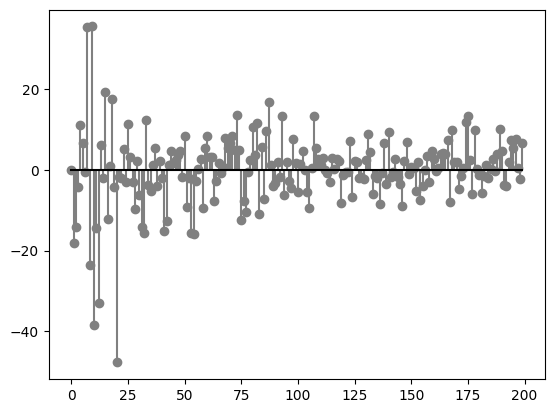

In [30]:
power_beta_age = power_glm_pre_post_df['beta_age']
power_p_age = power_glm_pre_post_df['p_age']
power_p_age_bonfcorr = power_glm_pre_post_df['p_age']*n_waves

# Define a condition for highlighting (e.g., y values > 5)
alpha_thr = 0.05
power_mask_age = power_p_age_bonfcorr < alpha_thr

# Plot non-highlighted stems
plt.stem(np.where(~power_mask_age)[0], power_beta_age[~power_mask_age], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(power_mask_age)[0], power_beta_age[power_mask_age],  linefmt='red', markerfmt='ro', basefmt='k-')
plt.show()


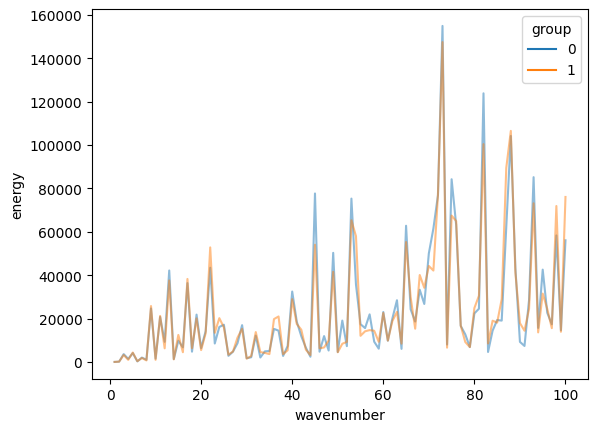

/home/chiuhan/cdrc/python_cdrc/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/chiuhan/cdrc/python_cdrc/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/chiuhan/cdrc/python_cdrc/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


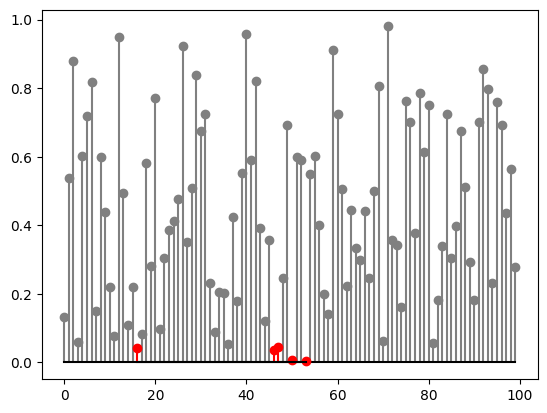

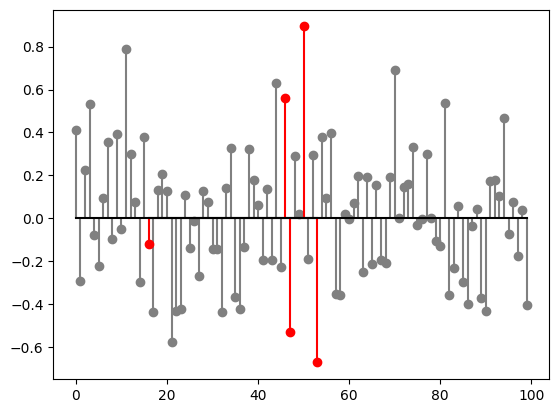

In [35]:
energy_df = pd.DataFrame.from_dict(pre_GED_energy_dict,orient='index')
energy_df = energy_df.stack().reset_index()
energy_df.columns = ['Participant ID', 'wavenumber', 'energy']
energy_df['wavenumber'] = energy_df['wavenumber']+1

energy_df_demog = pd.merge(df, energy_df, on='Participant ID', how='inner')
energy_df_demog = energy_df_demog.sort_values(by=['Participant ID', 'wavenumber'], ascending=True) #sort
energy_df_demog = energy_df_demog[['Participant ID','regist_sex_Male_is_0_Female_is_1','age_in_yrs','Cohort?','Hispanic / Latino','Race','wavenumber','energy']] #take only useful columns
energy_df_demog = energy_df_demog.rename(columns={'Participant ID': 'subj', 'regist_sex_Male_is_0_Female_is_1': 'sex', 'age_in_yrs':'age','Cohort?':'group','Hispanic / Latino':'hispanic','Race':'race'})
energy_df_demog['group'] = energy_df_demog['group'].map({'HC': 0, 'MDD': 1}) #remap HC as 0, MDD as 1
energy_df_demog

mean_energy = energy_df_demog.groupby(['group', 'wavenumber'])['energy'].mean().reset_index()
mean_energy
sns.lineplot(data=mean_energy, x='wavenumber', y='energy', hue='group', alpha=0.5,legend=True)
plt.show()

energy_glm = {}
for wn, subset in energy_df_demog.groupby('wavenumber'):
    model = smf.glm(formula='energy ~ group + age + sex', data=subset, family=sm.families.Gaussian())
    result = model.fit()
    energy_glm[wn] = result
    
rows = []
for wn, res in energy_glm.items():
    # Depending on your model, the intercept might be called 'Intercept' or 'const'
    if 'Intercept' in res.params:
        intercept = res.params['Intercept']
        p_intercept = res.pvalues['Intercept']
    elif 'const' in res.params:
        intercept = res.params['const']
        p_intercept = res.pvalues['const']
    else:
        intercept = None
        p_intercept = None

    # Extract coefficients for group, age, and sex (assuming they are named exactly as such)
    beta_group = res.params.get('group', None)
    p_group    = res.pvalues.get('group', None)
    beta_age   = res.params.get('age', None)
    p_age      = res.pvalues.get('age', None)
    beta_sex   = res.params.get('sex', None)
    p_sex      = res.pvalues.get('sex', None)

    rows.append({
        'wavenumber': wn,
        'intercept': intercept,
        'beta_group': beta_group,
        'beta_age': beta_age,
        'beta_sex': beta_sex,
        'p_intercept': p_intercept,
        'p_group': p_group,
        'p_age': p_age,
        'p_sex': p_sex
    })

# Create a summary DataFrame
energy_glm_df = pd.DataFrame(rows)

n_waves = pre_GED_data_dict['UNI012'].shape[0]
energy_p_group = energy_glm_df['p_group']
energy_p_group_bonfcorr = energy_glm_df['p_group']*n_waves

# Define a condition for highlighting (e.g., y values > 5)
alpha_thr = 0.05
energy_mask_group = energy_p_group < alpha_thr

# Plot non-highlighted stems
plt.stem(np.where(~energy_mask_group)[0], energy_p_group[~energy_mask_group], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(energy_mask_group)[0], energy_p_group[energy_mask_group],  linefmt='red', markerfmt='ro', basefmt='k-')
plt.show()

energy_smd_group = []
for wn, subset in energy_df_demog.groupby(['wavenumber']):
    g = hedges_g(subset[subset['group'] == 0]['energy'],subset[subset['group'] == 1]['energy'])
    energy_smd_group.append(g)
energy_smd_group = np.array(energy_smd_group)

# Plot non-highlighted stems
plt.stem(np.where(~energy_mask_group)[0], energy_smd_group[~np.array(energy_mask_group)], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(energy_mask_group)[0], energy_smd_group[np.array(energy_mask_group)],  linefmt='red', markerfmt='ro', basefmt='k-')
plt.show()

In [36]:
np.array(energy_p_group)[np.where(energy_p_group < 0.05)]

array([0.04313876, 0.0375575 , 0.04648051, 0.00735482, 0.00334245])

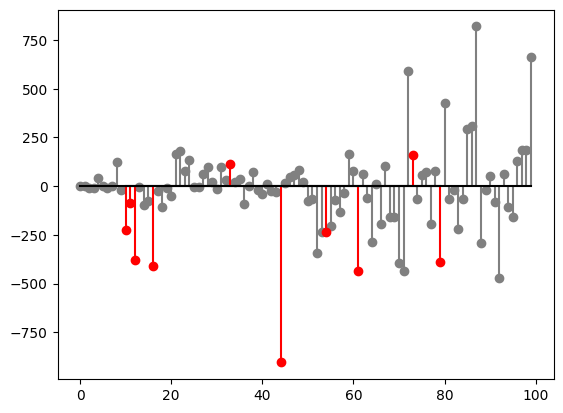

In [37]:
energy_beta_age = energy_glm_df['beta_age']
energy_p_age = energy_glm_df['p_age']
energy_p_age_bonfcorr = energy_glm_df['p_age']*n_waves

# Define a condition for highlighting (e.g., y values > 5)
alpha_thr = 0.05
energy_mask_age = energy_p_age < alpha_thr

# Plot non-highlighted stems
plt.stem(np.where(~energy_mask_age)[0], energy_beta_age[~energy_mask_age], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(energy_mask_age)[0], energy_beta_age[energy_mask_age],  linefmt='red', markerfmt='ro', basefmt='k-')
plt.show()


In [45]:
np.where(power_mask_group == True), np.where(power_mask_age == True), np.where(energy_mask_group == True), np.where(energy_mask_age == True)

((array([ 0, 16, 17, 36, 47, 50, 53]),),
 (array([10, 11, 12, 16, 33, 44, 61, 79]),),
 (array([16, 46, 47, 50, 53]),),
 (array([10, 11, 12, 16, 33, 44, 54, 61, 73, 79]),))

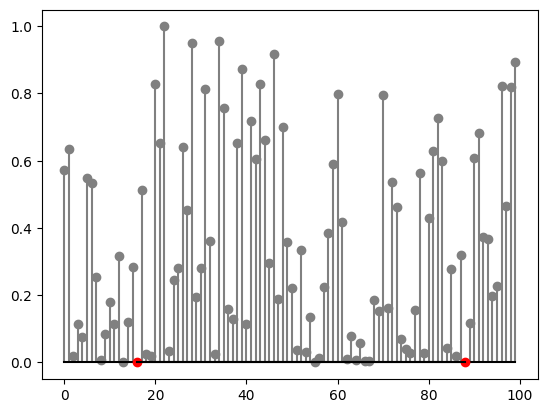

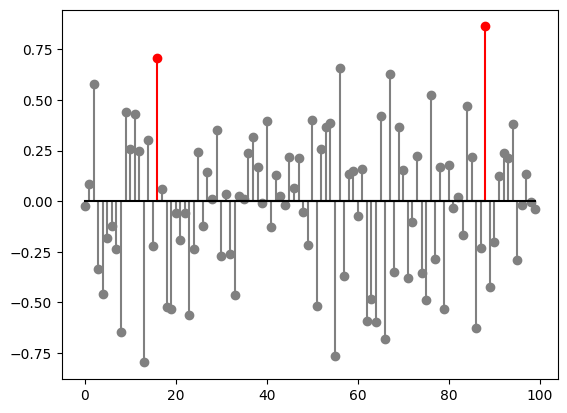

In [54]:
power_p_sex = power_glm_df['p_sex']
power_p_sex_bonfcorr = power_glm_df['p_sex']*n_waves

# Define a condition for highlighting (e.g., y values > 5)
alpha_thr = 0.05
power_mask_sex = power_p_sex_bonfcorr < alpha_thr

# Plot non-highlighted stems
plt.stem(np.where(~power_mask_sex)[0], power_p_sex[~power_mask_sex], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(power_mask_sex)[0], power_p_sex[power_mask_sex],  linefmt='red', markerfmt='ro', basefmt='k-')
plt.show()

power_smd_sex = []
for wn, subset in power_df_demog.groupby(['wavenumber']):
    g = hedges_g(subset[subset['sex'] == 0]['power'],subset[subset['sex'] == 1]['power'])
    power_smd_sex.append(g)
power_smd_sex = np.array(power_smd_sex)

# Plot non-highlighted stems
plt.stem(np.where(~power_mask_sex)[0], power_smd_sex[~np.array(power_mask_sex)], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(power_mask_sex)[0], power_smd_sex[np.array(power_mask_sex)],  linefmt='red', markerfmt='ro', basefmt='k-')
plt.show()

In [52]:
pd.options.display.max_rows = 10  # Change 50 to your desired number
power_p_sex.sort_values(), power_p_sex_bonfcorr.sort_values()

(88    0.000318
 16    0.000494
 55    0.000823
 13    0.000987
 67    0.004591
         ...   
 99    0.893389
 46    0.918395
 28    0.949460
 34    0.954821
 22    0.999247
 Name: p_sex, Length: 100, dtype: float64,
 88     0.031778
 16     0.049421
 55     0.082286
 13     0.098661
 67     0.459135
         ...    
 99    89.338927
 46    91.839462
 28    94.945950
 34    95.482084
 22    99.924724
 Name: p_sex, Length: 100, dtype: float64)

In [53]:
power_sex_rejected, power_sex_pvals_corrected, power_sex_alphacSidak, power_sex_alphacBonf = smm.multipletests(power_p_sex, alpha=0.05, method='fdr_bh')
pd.Series(power_sex_pvals_corrected).sort_values()

55    0.024665
88    0.024665
16    0.024665
13    0.024665
67    0.090364
        ...   
99    0.930614
46    0.946799
34    0.964465
28    0.964465
22    0.999247
Length: 100, dtype: float64

In [38]:
power_glm = smf.glm(formula='power ~ x1 + x2', data=df, family=sm.families.Gaussian())
results_formula = model_formula.fit()
print(results_formula.summary())

PatsyError: Error evaluating factor: NameError: name 'x2' is not defined
    power ~ x1 + x2
                 ^^

In [144]:
def hedges_g(sample1, sample2):
    # Sample sizes
    n1 = len(sample1)
    n2 = len(sample2)
    
    # Means
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    
    # Sample standard deviations (using ddof=1 for an unbiased estimator)
    std1 = np.std(sample1, ddof=1)
    std2 = np.std(sample2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    
    # Degrees of freedom
    #df = n1 + n2 - 2
    
    # Correction factor J for Hedges' g
    #J = 1 - (3 / (4 * df - 1))
    
    # Hedges' g
    #g = d * J
    #return g

    return d #just the uncorrected version

In [135]:
pre_GED_data_dict['UNI012'].shape[0]

(100, 730)

In [13]:
pre_GED_data = []
for file in baseline_pre_GED.values():
    with open(file,'rb') as f:
        pre_GED_data.append(pickle.load(f))
    f.close()

pre_GED_data = np.stack(pre_GED_data,axis=2)


In [6]:
def power(array): #harmonics x timepoints
    result = np.array([np.sum(np.abs(array[i,:])) for i in range(array.shape[0])])
    return result

def energy(array):
    result = np.array([np.sum((eigvals[i]**2)*(array[i,:]**2)) for i in range(array.shape[0])])
    return result

In [7]:
power_pre_data = np.stack([power(pre_GED_data[:,:,i]) for i in range(pre_GED_data.shape[2])],axis=1)
energy_pre_data = np.stack([energy(pre_GED_data[:,:,i]) for i in range(pre_GED_data.shape[2])],axis=1)
power_post_data = np.stack([power(post_GED_data[:,:,i]) for i in range(post_GED_data.shape[2])],axis=1)
energy_post_data = np.stack([energy(post_GED_data[:,:,i]) for i in range(post_GED_data.shape[2])],axis=1)
print(power_pre_data.shape, energy_pre_data.shape, power_post_data.shape, energy_post_data.shape)
nsubj = power_pre_data.shape[1]

(100, 63) (100, 63) (100, 63) (100, 63)


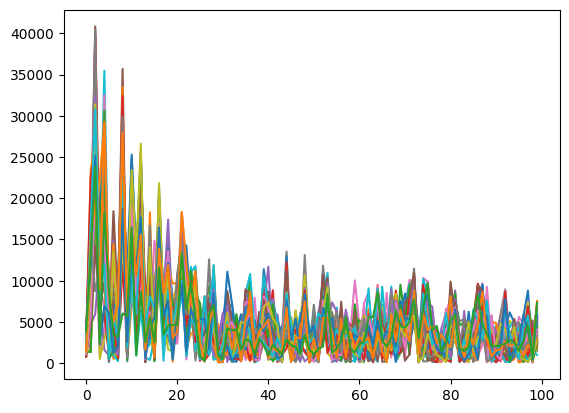

In [51]:
for i in range(nsubj):
    plt.plot(power_pre_data[:,i])
    
#cross check the shape of this plot with HCP data

<StemContainer object of 3 artists>

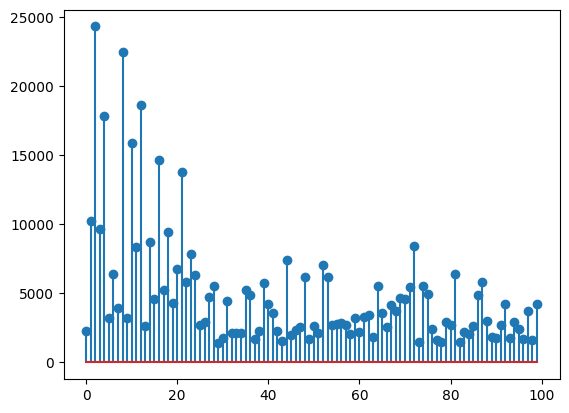

In [13]:
plt.stem(np.mean(power_data,axis=1))

In [26]:
from sklearn.cluster import KMeans

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(power_data.T) #must be n_samples x n_features

kmeans.labels_

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0], dtype=int32)

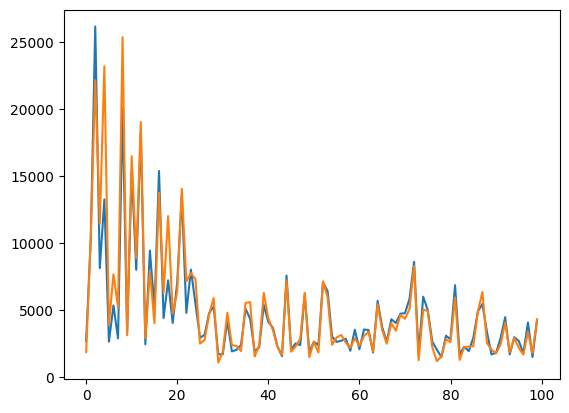

In [27]:
clusters = [power_data[:,kmeans.labels_==i] for i in range(n_clusters)]
cluster_means = [np.mean(clusters[i],axis=1) for i in range(n_clusters)]

for i in range(n_clusters):
    plt.plot(cluster_means[i])

<StemContainer object of 3 artists>

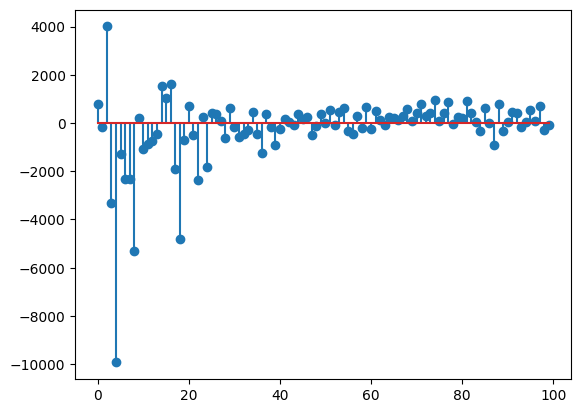

In [28]:
plt.stem((cluster_means[0]-cluster_means[1]))

In [29]:
def hedges_g(sample1, sample2):
    # Sample sizes
    n1 = len(sample1)
    n2 = len(sample2)
    
    # Means
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    
    # Sample standard deviations (using ddof=1 for an unbiased estimator)
    std1 = np.std(sample1, ddof=1)
    std2 = np.std(sample2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    
    # Degrees of freedom
    #df = n1 + n2 - 2
    
    # Correction factor J for Hedges' g
    #J = 1 - (3 / (4 * df - 1))
    
    # Hedges' g
    #g = d * J
    #return g

    return d #just the uncorrected version

In [30]:
clusters[0][0,:]

array([2862.39581061, 1608.88085208, 3161.06818249, 2882.65746716,
       2771.25206286, 4195.9784557 , 4712.07105308, 2273.39843773,
       3315.85210302, 5100.61677628, 4741.31219438, 2354.05612496,
       1775.83117503, 2627.56735255, 2860.69175166, 2393.54532856,
       2866.09342046, 2093.85215627, 1054.69429146,  868.13848359,
       4648.89550393, 1649.83028815, 1905.98333832, 2102.83570484,
       2173.35775651, 3189.80020024, 2196.83356081, 1988.35406845,
       1490.12737359,  990.06221396, 2793.08548549, 2971.36322574,
       3309.80060728, 2431.27531965, 2446.8219124 , 1510.21132612,
       1375.04400637, 2686.0425236 , 3802.82551573, 3869.81718496,
       2830.3737589 ])

<StemContainer object of 3 artists>

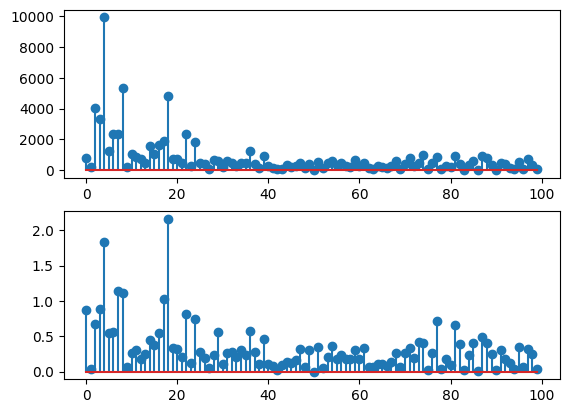

In [32]:
clusters_SMD = np.array([hedges_g(clusters[0][i,:],clusters[1][i,:]) for i in range(clusters[0].shape[0])])
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.stem(np.abs(cluster_means[0]-cluster_means[1]))
ax2.stem(np.abs(clusters_SMD))


In [43]:
power_data.shape

(100, 76)

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

power_data_std = StandardScaler().fit_transform(power_data)
pca = PCA()
#n_samples x n_features
power_pca = pca.fit_transform(power_data_std) #n_features x n_PCs

In [49]:
power_pca.shape

(100, 76)

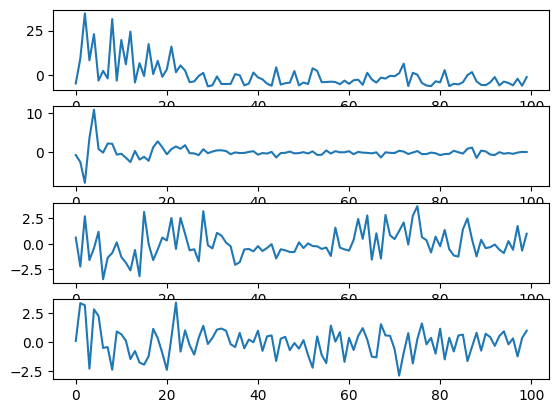

In [51]:
power_pca.shape

fig, (ax1, ax2, ax3,ax4) = plt.subplots(4,1)
ax1.plot(power_pca[:,0])
ax2.plot(power_pca[:,1])
ax3.plot(power_pca[:,2])
ax4.plot(power_pca[:,3])

In [6]:
with open('GED/sub-UNI03120230328_ses-pre_GED.pkl','rb') as f:
    data = pickle.load(f)
    

In [7]:
data.shape

(100, 730)

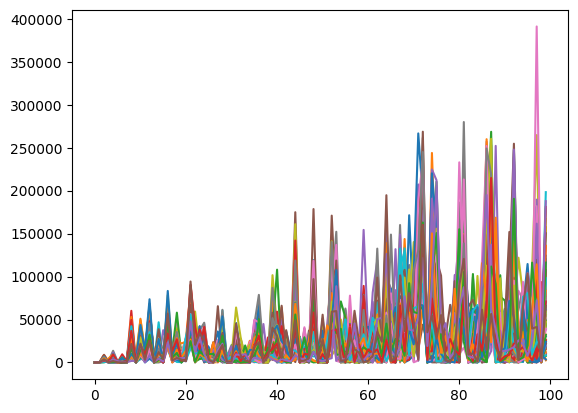

In [45]:
for i in range(76):
    plt.plot(energy_data[:,i])
    
#cross check the shape of this plot with HCP data

<StemContainer object of 3 artists>

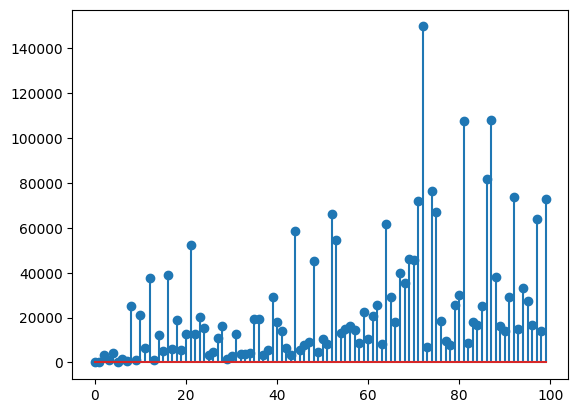

In [47]:
plt.stem(np.mean(energy_data,axis=1))

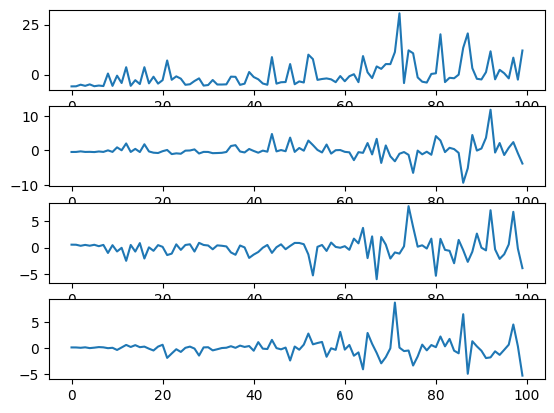

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

energy_data_std = StandardScaler().fit_transform(energy_data)
pca = PCA()
#n_samples x n_features
energy_pca = pca.fit_transform(energy_data_std) #n_features x n_PCs

fig, (ax1, ax2, ax3,ax4) = plt.subplots(4,1)
ax1.plot(energy_pca[:,0])
ax2.plot(energy_pca[:,1])
ax3.plot(energy_pca[:,2])
ax4.plot(energy_pca[:,3])

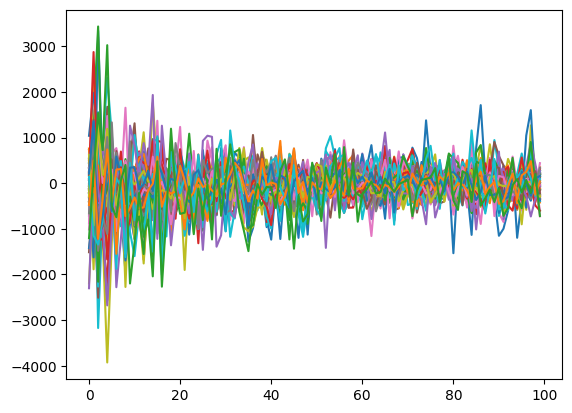

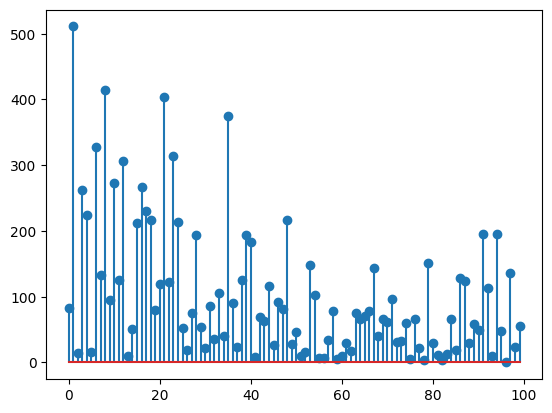

In [107]:
diff_power = power_post_data-power_pre_data

for i in range(nsubj):
    plt.plot(diff_power[:,i])
plt.show()
    
mean_diff_power = np.mean(diff_power,axis=1)
plt.stem(np.abs(mean_diff_power))
plt.show()

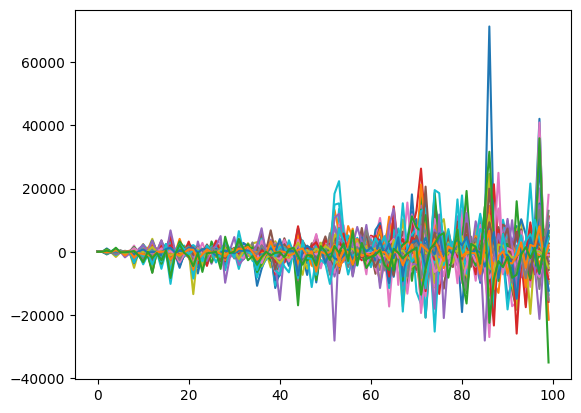

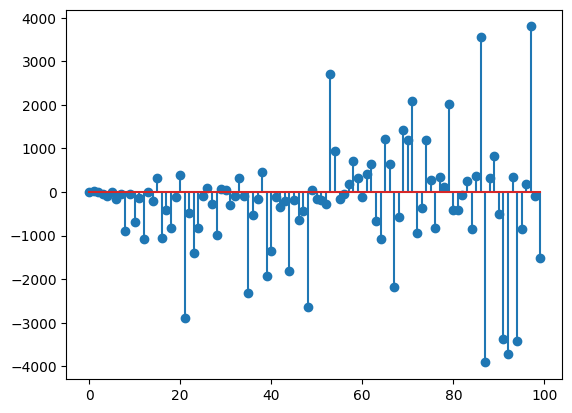

In [113]:
diff_energy = energy_post_data-energy_pre_data

for i in range(nsubj):
    plt.plot(diff_energy[:,i])
plt.show()
    
mean_diff_energy = np.mean(diff_energy,axis=1)

plt.stem(mean_diff_energy)
plt.show()

<StemContainer object of 3 artists>

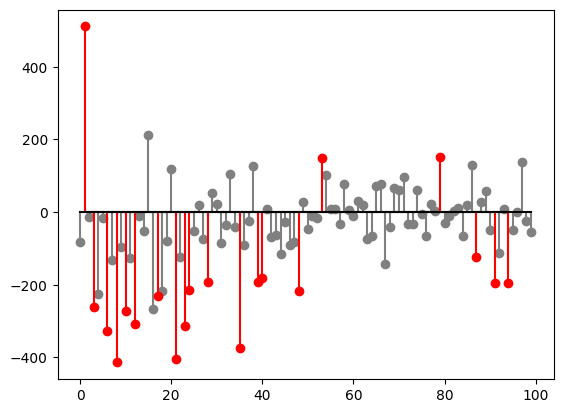

In [111]:
from scipy.stats import ttest_rel
power_t_test = []
n_waves = power_pre_data.shape[0]

for i in range(n_waves):
    power_t_test.append(ttest_rel(power_pre_data[i,:], power_post_data[i,:], axis=0, nan_policy='raise', alternative='two-sided', keepdims=False))

power_t = np.array([power_t_test[i].statistic for i in range(n_waves)])
power_p = np.array([power_t_test[i].pvalue for i in range(n_waves)])
power_p_bonfcorr = power_p*n_waves

np.where(power_p_bonfcorr < 0.05)[0]

# Define a condition for highlighting (e.g., y values > 5)
power_mask = power_p_bonfcorr < 0.05

# Plot non-highlighted stems
plt.stem(np.where(power_p_bonfcorr > 0.05)[0], mean_diff_power[~power_mask], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(power_p_bonfcorr < 0.05)[0], mean_diff_power[power_mask],  linefmt='red', markerfmt='ro', basefmt='k-')

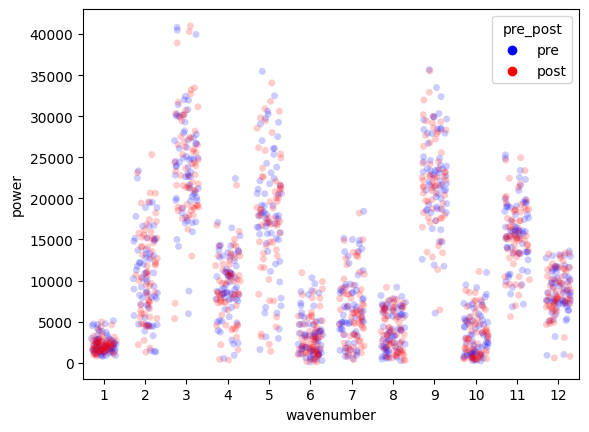

In [151]:
import seaborn as sns
import pandas as pd


pre_indices = np.indices(power_pre_data.shape)
pre_x = pre_indices[0].flatten()+1  # Coordinates for dimension 0
pre_y = pre_indices[1].flatten()  # Coordinates for dimension 1

# Flatten the array values
pre_values = power_pre_data.flatten()

# Create a DataFrame with the coordinates and their corresponding value
pre_df = pd.DataFrame({'wavenumber': pre_x, 'subj': pre_y, 'pre_post':'pre', 'power': pre_values})

post_indices = np.indices(power_post_data.shape)
post_x = post_indices[0].flatten()+1  # Coordinates for dimension 0
post_y = post_indices[1].flatten()  # Coordinates for dimension 1

# Flatten the array values
post_values = power_post_data.flatten()

# Create a DataFrame with the coordinates and their corresponding value
post_df = pd.DataFrame({'wavenumber': post_x, 'subj': post_y, 'pre_post':'post', 'power': post_values})

df = pd.concat([pre_df, post_df], ignore_index=True)

# Create a scatterplot, using hue to color the points by group
sns.stripplot(data=df.loc[df['wavenumber'] < 13], x='wavenumber', y='power', hue='pre_post', palette={'pre': 'blue', 'post': 'red'}, jitter=0.3, alpha=0.2)
plt.show()


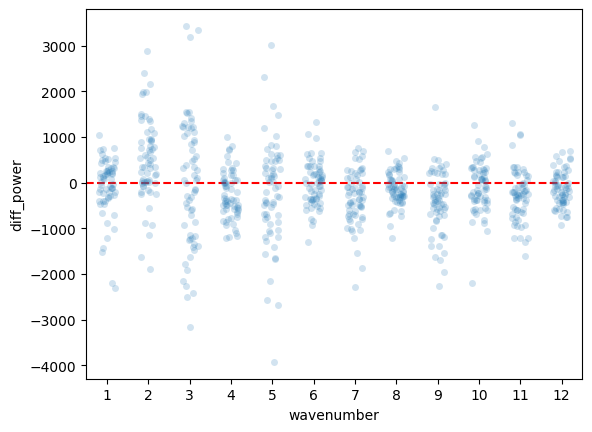

In [155]:
diff_power_indices = np.indices(diff_power.shape)
diff_power_x = diff_power_indices[0].flatten()+1  # Coordinates for dimension 0
diff_power_y = diff_power_indices[1].flatten()  # Coordinates for dimension 1
diff_power_values = diff_power.flatten()
diff_power_df = pd.DataFrame({'wavenumber': diff_power_x, 'subj': diff_power_y, 'diff_power': diff_power_values})
sns.stripplot(data=diff_power_df.loc[diff_power_df['wavenumber']<13], x='wavenumber', y='diff_power', jitter=0.2, alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [121]:
power_pre_data.shape

(100, 63)

In [118]:
np.concatenate([np.arange(100)+1, np.arange(100)+1])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  8

<StemContainer object of 3 artists>

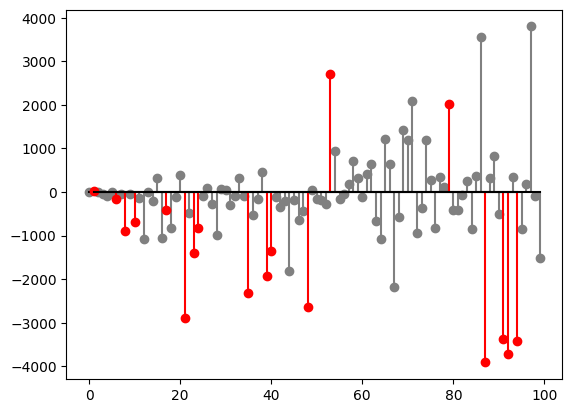

In [114]:
energy_t_test = []
n_waves = energy_pre_data.shape[0]

for i in range(n_waves):
    energy_t_test.append(ttest_rel(energy_pre_data[i,:], energy_post_data[i,:], axis=0, nan_policy='raise', alternative='two-sided', keepdims=False))

energy_t = np.array([energy_t_test[i].statistic for i in range(n_waves)])
energy_p = np.array([energy_t_test[i].pvalue for i in range(n_waves)])
energy_p_bonfcorr = energy_p*n_waves

np.where(energy_p_bonfcorr < 0.05)[0]

# Define a condition for highlighting (e.g., y values > 5)
energy_mask = energy_p_bonfcorr < 0.05

# Plot non-highlighted stems
plt.stem(np.where(energy_p_bonfcorr > 0.05)[0], mean_diff_energy[~energy_mask], linefmt='grey', markerfmt='o', basefmt='k-')

# Plot highlighted stems
plt.stem(np.where(energy_p_bonfcorr < 0.05)[0], mean_diff_energy[energy_mask],  linefmt='red', markerfmt='ro', basefmt='k-')

In [106]:
diff_power.shape

(100, 63)

In [66]:
power_pre_data[0,:]

array([1296.71494242, 2468.95463925, 1588.51716753, 2779.61137683,
       2352.65768507, 4195.9784557 , 4712.07105308, 1835.60029542,
       1356.07037638, 1719.70092396, 4513.80339955, 2273.39843773,
       3315.85210302, 5100.61677628, 4741.31219438, 2354.05612496,
       1775.83117503, 2627.56735255, 2860.69175166, 2393.54532856,
       2866.09342046, 1913.79769902, 2093.85215627, 1054.69429146,
       1360.7854935 , 1948.84381489, 2087.66545088,  868.13848359,
       4648.89550393, 3004.11267088, 1697.39186885, 1649.83028815,
       1549.77237688, 1905.98333832, 3676.50216119,  778.62684784,
       2102.83570484, 2173.35775651, 1699.08671526, 1611.52847347,
       2348.89556339,  878.2310535 , 1313.57389402,  827.83806574,
       1988.35406845, 1490.12737359, 1994.8733157 ,  990.06221396,
       2793.08548549, 2971.36322574, 1288.09395308, 1240.08716307,
       1407.13313899, 3309.80060728, 2431.27531965, 1510.21132612,
       1145.10304869, 1957.92777291, 1375.04400637, 2686.04252

In [8]:
demographics

,record_id,regist_sex_Male_is_0_Female_is_1,age_in_yrs,Study Status,Participant ID,Screening Date,Cohort?,Hispanic / Latino,Race
0,60,0,31,Complete,UNI060,09.29.2023,HC,No,Asian
1,55,0,24,Complete,UNI055,09.15.2023,HC,No,White
2,47,0,23,Complete,UNI047,06.29.23,HC,No,White
3,43,0,23,Complete,UNI043,06.14.23,HC,Yes,White
4,6,0,29,Complete,UNI006,2022-06-13 00:00:00,HC,No,White
...,...,...,...,...,...,...,...,...,...
82,105,1,45,early withdrawal,UNI105,7.31.2024,MDD,No,White
83,109,1,27,enrolled,UNI109,08.15.2024,MDD,No,White
84,146,1,45,randomized,UNI146,02.04.2025,MDD,No,White
85,139,1,56,randomized,UNI139,01.15.2025,MDD,No,Black/ African American


In [10]:
demographics[['Cohort?']]

KeyError: ('Cohort?', 'Participant ID')

In [9]:
pre_GED_data.shape

(100, 730, 63)